# DQN a partir de píxeles

## Arcade Learning Environment

La librería *gymnasium* se conecta con el [Arcade Learning Environment (ALE)](https://github.com/mgbellemare/Arcade-Learning-Environment) el cual tiene una colección de juegos de ATARI 2600 listos para utilizarle como benchmark de aprendizaje por refuerzo. La mayoría tiene una versión normal y una versión RAM:

- En la versión normal las observaciones son imágenes de 260x120x3
- En la versión RAM las observaciones son 128 bits que corresponden a la memoria de la consola

En este ejemplo nos concentraremos en la versión normal. Veamos por ejemplo el clásico juego [*Breakout*](https://en.wikipedia.org/wiki/Breakout_(video_game))

In [2]:
import gymnasium as gym

#env_name = "PongNoFrameskip-v4"
env_name ="BreakoutNoFrameskip-v4"
#env_name = "SpaceInvadersNoFrameskip-v4"

env = gym.make(env_name, render_mode="rgb_array")
state, _ = env.reset()

display("Las acciones de este ambiente:", env.unwrapped.get_action_meanings())
display("La dimensión del estado:", state.shape)

'Las acciones de este ambiente:'

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

'La dimensión del estado:'

(210, 160, 3)

El estado es una imagen de 210 x 160 x 3 pixeles:

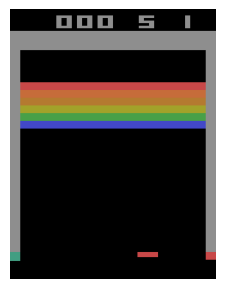

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True)
ax.imshow(state)
ax.axis('off');

## Entrenamiento con `stable_baselines3`

Para facilitar el entrenamiento se recomienda hacer un preprocesamiento como el que sigue:

1. Reescalar la imagen a un menor tamaño
1. Combinar los canales y generar una imagen de escala de grises
1. Crear un stack de cuatro frames como representación del estado
1. Convertir los pixeles a float y normalizar al rango [0, 1]

Adicionalmente es muy útil entrenar con más de un ambiente al mismo tiempo en paralelo. 

Para esto usaremos los wrappers vectoriales de `stable_baselines3`:

Tamaño del tensor transformado: ((4, 84, 84, 4), dtype('uint8'))


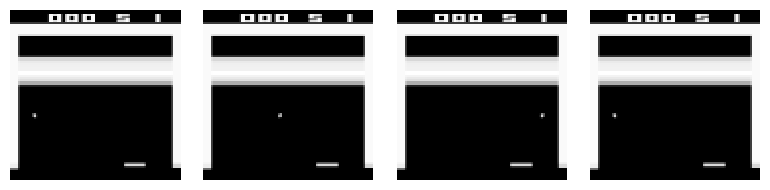

In [4]:
import numpy as np
import torch
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack

env = VecFrameStack(make_atari_env(env_name, n_envs=4), n_stack=4)

env.reset()
state, _, _, _ = env.step([2, 2, 2, 2])

print(f"Tamaño del tensor transformado: {state.shape, state.dtype}")
fig, ax = plt.subplots(1, 4, figsize=(8, 2), tight_layout=True)
for k in range(4):
    ax[k].matshow(state[k, :, :, 2], cmap=plt.cm.Greys_r);
    ax[k].axis('off')

Veamos un agente aleatorio desempeñándose en este ambiente:

/home/phuijse/.conda/envs/RL/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:364: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


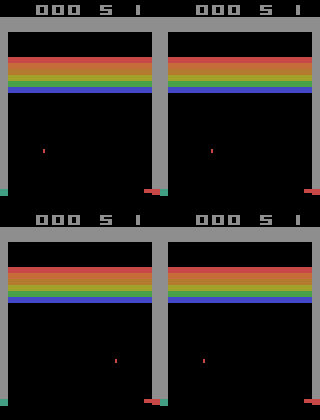

In [5]:
import imageio
import IPython

images = []

obs = env.reset()
for k in range(100):
    action = env.action_space.sample()
    obs, rewards, end, info = env.step([action]*4)
    img = env.render("rgb_array")
    images.append(img)

!rm random.gif
imageio.mimsave("random.gif", [np.array(img) for img in images], format='GIF', duration=1)
IPython.display.Image("random.gif")

Para entrenar el agente utilizaremos una red convolucional `CnnPolicy`. Utilizaremos un buffer de tamaño 100.000 y  durante las primeros 100.000 pasos no entrenamos, sólo llenamos el buffer. 

:::{warning}

Para llegar a un buen resultado en los ambientes de Atari con DQN se necesitan al menos 1.000.000 de pasos con la configuración que se muestra a continuación. Se recomienda utilizar una GPU para entrenar. En la práctica también es recomendable utilizar algoritmos más eficientes como A3C.

:::

In [21]:
%%time

import torch
from stable_baselines3 import DQN

np.random.seed(1234)
torch.manual_seed(1234)

env.reset()
model = DQN("CnnPolicy", env, verbose=1, tensorboard_log="/tmp/tensorboard/dqn_atari/",
            gamma=0.99, learning_rate=1e-4, batch_size=32, buffer_size=100_000, 
            target_update_interval=1_000, train_freq=4, gradient_steps=1,
            learning_starts=100_000, 
            exploration_fraction=0.1, exploration_final_eps=0.01, 
            )

model.learn(total_timesteps=10_000_000)

Using cpu device
Wrapping the env in a VecTransposeImage.
Logging to /tmp/tensorboard/dqn_atari/DQN_2
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 742      |
|    ep_rew_mean      | 2        |
|    exploration_rate | 1        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 459      |
|    time_elapsed     | 0        |
|    total_timesteps  | 244      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 693      |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 1        |
| time/               |          |
|    episodes         | 8        |
|    fps              | 479      |
|    time_elapsed     | 0        |
|    total_timesteps  | 440      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 693      |
|    ep_rew_mean      |

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 832      |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 92       |
|    fps              | 494      |
|    time_elapsed     | 7        |
|    total_timesteps  | 3712     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 816      |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 96       |
|    fps              | 493      |
|    time_elapsed     | 7        |
|    total_timesteps  | 3852     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 816      |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 821      |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.993    |
| time/               |          |
|    episodes         | 180      |
|    fps              | 485      |
|    time_elapsed     | 14       |
|    total_timesteps  | 6876     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 818      |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.993    |
| time/               |          |
|    episodes         | 184      |
|    fps              | 484      |
|    time_elapsed     | 14       |
|    total_timesteps  | 6968     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 818      |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.993    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 782      |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.99     |
| time/               |          |
|    episodes         | 268      |
|    fps              | 480      |
|    time_elapsed     | 20       |
|    total_timesteps  | 9620     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 780      |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.99     |
| time/               |          |
|    episodes         | 272      |
|    fps              | 481      |
|    time_elapsed     | 20       |
|    total_timesteps  | 9928     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 780      |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.99     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 774      |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.987    |
| time/               |          |
|    episodes         | 356      |
|    fps              | 477      |
|    time_elapsed     | 26       |
|    total_timesteps  | 12688    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 774      |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.987    |
| time/               |          |
|    episodes         | 360      |
|    fps              | 479      |
|    time_elapsed     | 26       |
|    total_timesteps  | 12904    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 776      |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.987    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 777      |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 444      |
|    fps              | 480      |
|    time_elapsed     | 32       |
|    total_timesteps  | 15828    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 775      |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 448      |
|    fps              | 480      |
|    time_elapsed     | 33       |
|    total_timesteps  | 16004    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 775      |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 755      |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.982    |
| time/               |          |
|    episodes         | 532      |
|    fps              | 476      |
|    time_elapsed     | 38       |
|    total_timesteps  | 18472    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 748      |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.982    |
| time/               |          |
|    episodes         | 536      |
|    fps              | 476      |
|    time_elapsed     | 39       |
|    total_timesteps  | 18596    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 748      |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.981    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 731      |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.979    |
| time/               |          |
|    episodes         | 620      |
|    fps              | 475      |
|    time_elapsed     | 44       |
|    total_timesteps  | 21392    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 731      |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.979    |
| time/               |          |
|    episodes         | 624      |
|    fps              | 475      |
|    time_elapsed     | 45       |
|    total_timesteps  | 21484    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 731      |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.978    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 736      |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.976    |
| time/               |          |
|    episodes         | 708      |
|    fps              | 476      |
|    time_elapsed     | 51       |
|    total_timesteps  | 24348    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 736      |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.976    |
| time/               |          |
|    episodes         | 712      |
|    fps              | 476      |
|    time_elapsed     | 51       |
|    total_timesteps  | 24432    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 731      |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.976    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 737      |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.973    |
| time/               |          |
|    episodes         | 796      |
|    fps              | 475      |
|    time_elapsed     | 57       |
|    total_timesteps  | 27280    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 737      |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.973    |
| time/               |          |
|    episodes         | 800      |
|    fps              | 475      |
|    time_elapsed     | 57       |
|    total_timesteps  | 27372    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 737      |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.973    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 725      |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.97     |
| time/               |          |
|    episodes         | 884      |
|    fps              | 475      |
|    time_elapsed     | 63       |
|    total_timesteps  | 29980    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 724      |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.97     |
| time/               |          |
|    episodes         | 888      |
|    fps              | 475      |
|    time_elapsed     | 63       |
|    total_timesteps  | 30076    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 724      |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.97     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 716      |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.967    |
| time/               |          |
|    episodes         | 972      |
|    fps              | 475      |
|    time_elapsed     | 69       |
|    total_timesteps  | 33048    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 716      |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.967    |
| time/               |          |
|    episodes         | 976      |
|    fps              | 476      |
|    time_elapsed     | 69       |
|    total_timesteps  | 33308    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 716      |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.967    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 752      |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.964    |
| time/               |          |
|    episodes         | 1060     |
|    fps              | 476      |
|    time_elapsed     | 76       |
|    total_timesteps  | 36400    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 752      |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.964    |
| time/               |          |
|    episodes         | 1064     |
|    fps              | 476      |
|    time_elapsed     | 76       |
|    total_timesteps  | 36672    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 750      |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.964    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 741      |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.961    |
| time/               |          |
|    episodes         | 1148     |
|    fps              | 476      |
|    time_elapsed     | 82       |
|    total_timesteps  | 39204    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 741      |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.961    |
| time/               |          |
|    episodes         | 1152     |
|    fps              | 476      |
|    time_elapsed     | 82       |
|    total_timesteps  | 39456    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 741      |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.961    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 743      |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.958    |
| time/               |          |
|    episodes         | 1236     |
|    fps              | 474      |
|    time_elapsed     | 88       |
|    total_timesteps  | 42012    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 743      |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.958    |
| time/               |          |
|    episodes         | 1240     |
|    fps              | 474      |
|    time_elapsed     | 88       |
|    total_timesteps  | 42136    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 745      |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.958    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 737      |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.955    |
| time/               |          |
|    episodes         | 1324     |
|    fps              | 472      |
|    time_elapsed     | 95       |
|    total_timesteps  | 45084    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 737      |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.955    |
| time/               |          |
|    episodes         | 1328     |
|    fps              | 472      |
|    time_elapsed     | 95       |
|    total_timesteps  | 45232    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 740      |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.955    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 756      |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.953    |
| time/               |          |
|    episodes         | 1412     |
|    fps              | 472      |
|    time_elapsed     | 101      |
|    total_timesteps  | 47868    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 753      |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.953    |
| time/               |          |
|    episodes         | 1416     |
|    fps              | 472      |
|    time_elapsed     | 101      |
|    total_timesteps  | 47960    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 751      |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.952    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 748      |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.949    |
| time/               |          |
|    episodes         | 1500     |
|    fps              | 473      |
|    time_elapsed     | 107      |
|    total_timesteps  | 51020    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 741      |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.949    |
| time/               |          |
|    episodes         | 1504     |
|    fps              | 473      |
|    time_elapsed     | 108      |
|    total_timesteps  | 51112    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 741      |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.949    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 717      |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.947    |
| time/               |          |
|    episodes         | 1588     |
|    fps              | 471      |
|    time_elapsed     | 113      |
|    total_timesteps  | 53576    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 714      |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.947    |
| time/               |          |
|    episodes         | 1592     |
|    fps              | 471      |
|    time_elapsed     | 113      |
|    total_timesteps  | 53668    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 714      |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.947    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 721      |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.944    |
| time/               |          |
|    episodes         | 1676     |
|    fps              | 469      |
|    time_elapsed     | 120      |
|    total_timesteps  | 56692    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 722      |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.944    |
| time/               |          |
|    episodes         | 1680     |
|    fps              | 469      |
|    time_elapsed     | 120      |
|    total_timesteps  | 56784    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 721      |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.944    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 731      |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.941    |
| time/               |          |
|    episodes         | 1764     |
|    fps              | 469      |
|    time_elapsed     | 127      |
|    total_timesteps  | 59640    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 729      |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.941    |
| time/               |          |
|    episodes         | 1768     |
|    fps              | 469      |
|    time_elapsed     | 127      |
|    total_timesteps  | 59752    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 737      |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.941    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 708      |
|    ep_rew_mean      | 1.2      |
|    exploration_rate | 0.938    |
| time/               |          |
|    episodes         | 1852     |
|    fps              | 469      |
|    time_elapsed     | 132      |
|    total_timesteps  | 62172    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 710      |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.938    |
| time/               |          |
|    episodes         | 1856     |
|    fps              | 469      |
|    time_elapsed     | 132      |
|    total_timesteps  | 62296    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 711      |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.938    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 718      |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.936    |
| time/               |          |
|    episodes         | 1940     |
|    fps              | 467      |
|    time_elapsed     | 139      |
|    total_timesteps  | 65140    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 718      |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.935    |
| time/               |          |
|    episodes         | 1944     |
|    fps              | 467      |
|    time_elapsed     | 139      |
|    total_timesteps  | 65280    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 718      |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.935    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 709      |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.933    |
| time/               |          |
|    episodes         | 2028     |
|    fps              | 466      |
|    time_elapsed     | 145      |
|    total_timesteps  | 67824    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 709      |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.933    |
| time/               |          |
|    episodes         | 2032     |
|    fps              | 466      |
|    time_elapsed     | 145      |
|    total_timesteps  | 67916    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 709      |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.933    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 723      |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.93     |
| time/               |          |
|    episodes         | 2116     |
|    fps              | 466      |
|    time_elapsed     | 151      |
|    total_timesteps  | 70804    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 723      |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.93     |
| time/               |          |
|    episodes         | 2120     |
|    fps              | 466      |
|    time_elapsed     | 152      |
|    total_timesteps  | 70892    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 723      |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.93     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 713      |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.927    |
| time/               |          |
|    episodes         | 2204     |
|    fps              | 466      |
|    time_elapsed     | 157      |
|    total_timesteps  | 73652    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 720      |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.927    |
| time/               |          |
|    episodes         | 2208     |
|    fps              | 466      |
|    time_elapsed     | 158      |
|    total_timesteps  | 73944    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 719      |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.927    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 717      |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.924    |
| time/               |          |
|    episodes         | 2292     |
|    fps              | 466      |
|    time_elapsed     | 164      |
|    total_timesteps  | 76860    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 721      |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.924    |
| time/               |          |
|    episodes         | 2296     |
|    fps              | 466      |
|    time_elapsed     | 165      |
|    total_timesteps  | 76992    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 721      |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.924    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 731      |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.921    |
| time/               |          |
|    episodes         | 2380     |
|    fps              | 465      |
|    time_elapsed     | 170      |
|    total_timesteps  | 79576    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 731      |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.921    |
| time/               |          |
|    episodes         | 2384     |
|    fps              | 465      |
|    time_elapsed     | 171      |
|    total_timesteps  | 79680    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 731      |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.921    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 715      |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.919    |
| time/               |          |
|    episodes         | 2468     |
|    fps              | 464      |
|    time_elapsed     | 176      |
|    total_timesteps  | 82124    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 716      |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.919    |
| time/               |          |
|    episodes         | 2472     |
|    fps              | 464      |
|    time_elapsed     | 177      |
|    total_timesteps  | 82300    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 716      |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.918    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 716      |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.916    |
| time/               |          |
|    episodes         | 2556     |
|    fps              | 464      |
|    time_elapsed     | 182      |
|    total_timesteps  | 84892    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 714      |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.916    |
| time/               |          |
|    episodes         | 2560     |
|    fps              | 464      |
|    time_elapsed     | 182      |
|    total_timesteps  | 84984    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 714      |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.916    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 715      |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.913    |
| time/               |          |
|    episodes         | 2644     |
|    fps              | 464      |
|    time_elapsed     | 189      |
|    total_timesteps  | 87804    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 715      |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.913    |
| time/               |          |
|    episodes         | 2648     |
|    fps              | 464      |
|    time_elapsed     | 189      |
|    total_timesteps  | 87932    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 715      |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.913    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 722      |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.91     |
| time/               |          |
|    episodes         | 2732     |
|    fps              | 464      |
|    time_elapsed     | 195      |
|    total_timesteps  | 91012    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 722      |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.91     |
| time/               |          |
|    episodes         | 2736     |
|    fps              | 464      |
|    time_elapsed     | 196      |
|    total_timesteps  | 91120    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 722      |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.91     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 717      |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.907    |
| time/               |          |
|    episodes         | 2820     |
|    fps              | 464      |
|    time_elapsed     | 201      |
|    total_timesteps  | 93820    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 717      |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.907    |
| time/               |          |
|    episodes         | 2824     |
|    fps              | 464      |
|    time_elapsed     | 202      |
|    total_timesteps  | 93912    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 717      |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.907    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 717      |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.904    |
| time/               |          |
|    episodes         | 2908     |
|    fps              | 464      |
|    time_elapsed     | 207      |
|    total_timesteps  | 96540    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 717      |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.904    |
| time/               |          |
|    episodes         | 2912     |
|    fps              | 464      |
|    time_elapsed     | 207      |
|    total_timesteps  | 96668    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 717      |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.904    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 737      |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.901    |
| time/               |          |
|    episodes         | 2996     |
|    fps              | 465      |
|    time_elapsed     | 214      |
|    total_timesteps  | 99688    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 737      |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.901    |
| time/               |          |
|    episodes         | 3000     |
|    fps              | 465      |
|    time_elapsed     | 214      |
|    total_timesteps  | 99800    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 737      |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.901    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 736      |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.899    |
| time/               |          |
|    episodes         | 3064     |
|    fps              | 445      |
|    time_elapsed     | 227      |
|    total_timesteps  | 101664   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000219 |
|    n_updates        | 103      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 736      |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.899    |
| time/               |          |
|    episodes         | 3068     |
|    fps              | 443      |
|    time_elapsed     | 229      |
|    total_timesteps  | 101840   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.66e-05 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 726      |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.897    |
| time/               |          |
|    episodes         | 3128     |
|    fps              | 426      |
|    time_elapsed     | 242      |
|    total_timesteps  | 103636   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0158   |
|    n_updates        | 227      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 726      |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.897    |
| time/               |          |
|    episodes         | 3132     |
|    fps              | 425      |
|    time_elapsed     | 243      |
|    total_timesteps  | 103728   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000445 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 716      |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.895    |
| time/               |          |
|    episodes         | 3192     |
|    fps              | 409      |
|    time_elapsed     | 257      |
|    total_timesteps  | 105616   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.016    |
|    n_updates        | 350      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 716      |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.895    |
| time/               |          |
|    episodes         | 3196     |
|    fps              | 408      |
|    time_elapsed     | 258      |
|    total_timesteps  | 105756   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0306   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 703      |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.893    |
| time/               |          |
|    episodes         | 3256     |
|    fps              | 394      |
|    time_elapsed     | 273      |
|    total_timesteps  | 107656   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.05e-06 |
|    n_updates        | 478      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 700      |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.893    |
| time/               |          |
|    episodes         | 3260     |
|    fps              | 393      |
|    time_elapsed     | 273      |
|    total_timesteps  | 107760   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.29e-05 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 708      |
|    ep_rew_mean      | 1.2      |
|    exploration_rate | 0.891    |
| time/               |          |
|    episodes         | 3320     |
|    fps              | 377      |
|    time_elapsed     | 291      |
|    total_timesteps  | 110160   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17e-05 |
|    n_updates        | 634      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 708      |
|    ep_rew_mean      | 1.2      |
|    exploration_rate | 0.891    |
| time/               |          |
|    episodes         | 3324     |
|    fps              | 376      |
|    time_elapsed     | 292      |
|    total_timesteps  | 110276   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.45e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 721      |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.889    |
| time/               |          |
|    episodes         | 3384     |
|    fps              | 365      |
|    time_elapsed     | 306      |
|    total_timesteps  | 112004   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.84e-05 |
|    n_updates        | 750      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 718      |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.889    |
| time/               |          |
|    episodes         | 3388     |
|    fps              | 364      |
|    time_elapsed     | 307      |
|    total_timesteps  | 112116   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0007   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 715      |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.887    |
| time/               |          |
|    episodes         | 3448     |
|    fps              | 354      |
|    time_elapsed     | 321      |
|    total_timesteps  | 113840   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.017    |
|    n_updates        | 864      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 714      |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.887    |
| time/               |          |
|    episodes         | 3452     |
|    fps              | 354      |
|    time_elapsed     | 321      |
|    total_timesteps  | 113932   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000588 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 685      |
|    ep_rew_mean      | 1.05     |
|    exploration_rate | 0.885    |
| time/               |          |
|    episodes         | 3512     |
|    fps              | 344      |
|    time_elapsed     | 336      |
|    total_timesteps  | 115776   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0011   |
|    n_updates        | 985      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 685      |
|    ep_rew_mean      | 1.05     |
|    exploration_rate | 0.885    |
| time/               |          |
|    episodes         | 3516     |
|    fps              | 343      |
|    time_elapsed     | 337      |
|    total_timesteps  | 115936   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000504 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 699      |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.883    |
| time/               |          |
|    episodes         | 3576     |
|    fps              | 334      |
|    time_elapsed     | 351      |
|    total_timesteps  | 117700   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000707 |
|    n_updates        | 1106     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 692      |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.883    |
| time/               |          |
|    episodes         | 3580     |
|    fps              | 333      |
|    time_elapsed     | 352      |
|    total_timesteps  | 117876   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.04e-05 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 689      |
|    ep_rew_mean      | 1.1      |
|    exploration_rate | 0.882    |
| time/               |          |
|    episodes         | 3640     |
|    fps              | 326      |
|    time_elapsed     | 365      |
|    total_timesteps  | 119496   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00104  |
|    n_updates        | 1218     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 687      |
|    ep_rew_mean      | 1.09     |
|    exploration_rate | 0.882    |
| time/               |          |
|    episodes         | 3644     |
|    fps              | 326      |
|    time_elapsed     | 366      |
|    total_timesteps  | 119580   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0161   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 700      |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.88     |
| time/               |          |
|    episodes         | 3704     |
|    fps              | 318      |
|    time_elapsed     | 382      |
|    total_timesteps  | 121660   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.017    |
|    n_updates        | 1353     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 698      |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.879    |
| time/               |          |
|    episodes         | 3708     |
|    fps              | 317      |
|    time_elapsed     | 383      |
|    total_timesteps  | 121780   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00117  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 683      |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.878    |
| time/               |          |
|    episodes         | 3768     |
|    fps              | 310      |
|    time_elapsed     | 397      |
|    total_timesteps  | 123496   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00147  |
|    n_updates        | 1468     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 682      |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.878    |
| time/               |          |
|    episodes         | 3772     |
|    fps              | 310      |
|    time_elapsed     | 398      |
|    total_timesteps  | 123584   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00275  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 658      |
|    ep_rew_mean      | 0.89     |
|    exploration_rate | 0.876    |
| time/               |          |
|    episodes         | 3832     |
|    fps              | 304      |
|    time_elapsed     | 411      |
|    total_timesteps  | 125268   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00471  |
|    n_updates        | 1579     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 663      |
|    ep_rew_mean      | 0.92     |
|    exploration_rate | 0.876    |
| time/               |          |
|    episodes         | 3836     |
|    fps              | 304      |
|    time_elapsed     | 412      |
|    total_timesteps  | 125360   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.56e-05 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 682      |
|    ep_rew_mean      | 1.04     |
|    exploration_rate | 0.873    |
| time/               |          |
|    episodes         | 3896     |
|    fps              | 296      |
|    time_elapsed     | 430      |
|    total_timesteps  | 127780   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00459  |
|    n_updates        | 1736     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 680      |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.873    |
| time/               |          |
|    episodes         | 3900     |
|    fps              | 296      |
|    time_elapsed     | 432      |
|    total_timesteps  | 127920   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00166  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 693      |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.871    |
| time/               |          |
|    episodes         | 3960     |
|    fps              | 290      |
|    time_elapsed     | 447      |
|    total_timesteps  | 129856   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000115 |
|    n_updates        | 1865     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 699      |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.871    |
| time/               |          |
|    episodes         | 3964     |
|    fps              | 289      |
|    time_elapsed     | 449      |
|    total_timesteps  | 130008   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000349 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 707      |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.869    |
| time/               |          |
|    episodes         | 4024     |
|    fps              | 283      |
|    time_elapsed     | 465      |
|    total_timesteps  | 132076   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.98e-05 |
|    n_updates        | 2004     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 702      |
|    ep_rew_mean      | 1.12     |
|    exploration_rate | 0.869    |
| time/               |          |
|    episodes         | 4028     |
|    fps              | 283      |
|    time_elapsed     | 466      |
|    total_timesteps  | 132172   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00199  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 703      |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.867    |
| time/               |          |
|    episodes         | 4088     |
|    fps              | 278      |
|    time_elapsed     | 481      |
|    total_timesteps  | 134176   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00219  |
|    n_updates        | 2135     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 703      |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.867    |
| time/               |          |
|    episodes         | 4092     |
|    fps              | 278      |
|    time_elapsed     | 482      |
|    total_timesteps  | 134316   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0021   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 729      |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.865    |
| time/               |          |
|    episodes         | 4152     |
|    fps              | 273      |
|    time_elapsed     | 498      |
|    total_timesteps  | 136340   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0283   |
|    n_updates        | 2271     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 731      |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.865    |
| time/               |          |
|    episodes         | 4156     |
|    fps              | 272      |
|    time_elapsed     | 500      |
|    total_timesteps  | 136524   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0177   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 742      |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.863    |
| time/               |          |
|    episodes         | 4216     |
|    fps              | 267      |
|    time_elapsed     | 517      |
|    total_timesteps  | 138736   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00478  |
|    n_updates        | 2420     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 742      |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.863    |
| time/               |          |
|    episodes         | 4220     |
|    fps              | 267      |
|    time_elapsed     | 518      |
|    total_timesteps  | 138844   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00245  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 753      |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.86     |
| time/               |          |
|    episodes         | 4280     |
|    fps              | 263      |
|    time_elapsed     | 535      |
|    total_timesteps  | 140980   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.84e-05 |
|    n_updates        | 2561     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 756      |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.86     |
| time/               |          |
|    episodes         | 4284     |
|    fps              | 263      |
|    time_elapsed     | 535      |
|    total_timesteps  | 141072   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000117 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 763      |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.858    |
| time/               |          |
|    episodes         | 4344     |
|    fps              | 259      |
|    time_elapsed     | 551      |
|    total_timesteps  | 143096   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00533  |
|    n_updates        | 2693     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 766      |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.858    |
| time/               |          |
|    episodes         | 4348     |
|    fps              | 259      |
|    time_elapsed     | 552      |
|    total_timesteps  | 143204   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00274  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 740      |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.857    |
| time/               |          |
|    episodes         | 4408     |
|    fps              | 256      |
|    time_elapsed     | 565      |
|    total_timesteps  | 144808   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00276  |
|    n_updates        | 2800     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 740      |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.856    |
| time/               |          |
|    episodes         | 4412     |
|    fps              | 255      |
|    time_elapsed     | 566      |
|    total_timesteps  | 144992   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000134 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 724      |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.855    |
| time/               |          |
|    episodes         | 4472     |
|    fps              | 252      |
|    time_elapsed     | 580      |
|    total_timesteps  | 146648   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0278   |
|    n_updates        | 2915     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 721      |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.855    |
| time/               |          |
|    episodes         | 4476     |
|    fps              | 252      |
|    time_elapsed     | 581      |
|    total_timesteps  | 146804   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.72e-05 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 720      |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.853    |
| time/               |          |
|    episodes         | 4536     |
|    fps              | 249      |
|    time_elapsed     | 596      |
|    total_timesteps  | 148700   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000332 |
|    n_updates        | 3043     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 720      |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.853    |
| time/               |          |
|    episodes         | 4540     |
|    fps              | 249      |
|    time_elapsed     | 597      |
|    total_timesteps  | 148832   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000332 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 734      |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.851    |
| time/               |          |
|    episodes         | 4600     |
|    fps              | 245      |
|    time_elapsed     | 613      |
|    total_timesteps  | 150904   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00536  |
|    n_updates        | 3181     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 731      |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.85     |
| time/               |          |
|    episodes         | 4604     |
|    fps              | 245      |
|    time_elapsed     | 615      |
|    total_timesteps  | 151072   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00555  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 715      |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.849    |
| time/               |          |
|    episodes         | 4664     |
|    fps              | 242      |
|    time_elapsed     | 629      |
|    total_timesteps  | 152916   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00318  |
|    n_updates        | 3307     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 722      |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.848    |
| time/               |          |
|    episodes         | 4668     |
|    fps              | 242      |
|    time_elapsed     | 630      |
|    total_timesteps  | 153048   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00772  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 694      |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.847    |
| time/               |          |
|    episodes         | 4728     |
|    fps              | 240      |
|    time_elapsed     | 643      |
|    total_timesteps  | 154660   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0057   |
|    n_updates        | 3416     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 692      |
|    ep_rew_mean      | 1.12     |
|    exploration_rate | 0.847    |
| time/               |          |
|    episodes         | 4732     |
|    fps              | 240      |
|    time_elapsed     | 644      |
|    total_timesteps  | 154752   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00301  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 679      |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.845    |
| time/               |          |
|    episodes         | 4792     |
|    fps              | 238      |
|    time_elapsed     | 657      |
|    total_timesteps  | 156504   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00159  |
|    n_updates        | 3531     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 677      |
|    ep_rew_mean      | 1.01     |
|    exploration_rate | 0.845    |
| time/               |          |
|    episodes         | 4796     |
|    fps              | 237      |
|    time_elapsed     | 658      |
|    total_timesteps  | 156596   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00339  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 676      |
|    ep_rew_mean      | 1        |
|    exploration_rate | 0.843    |
| time/               |          |
|    episodes         | 4856     |
|    fps              | 235      |
|    time_elapsed     | 673      |
|    total_timesteps  | 158620   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00345  |
|    n_updates        | 3663     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 673      |
|    ep_rew_mean      | 0.98     |
|    exploration_rate | 0.843    |
| time/               |          |
|    episodes         | 4860     |
|    fps              | 235      |
|    time_elapsed     | 674      |
|    total_timesteps  | 158712   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00681  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 676      |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.841    |
| time/               |          |
|    episodes         | 4920     |
|    fps              | 233      |
|    time_elapsed     | 688      |
|    total_timesteps  | 160452   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0021   |
|    n_updates        | 3778     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 676      |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.841    |
| time/               |          |
|    episodes         | 4924     |
|    fps              | 232      |
|    time_elapsed     | 689      |
|    total_timesteps  | 160600   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0037   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 691      |
|    ep_rew_mean      | 1.12     |
|    exploration_rate | 0.839    |
| time/               |          |
|    episodes         | 4984     |
|    fps              | 230      |
|    time_elapsed     | 706      |
|    total_timesteps  | 162628   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00172  |
|    n_updates        | 3914     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 689      |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.839    |
| time/               |          |
|    episodes         | 4988     |
|    fps              | 230      |
|    time_elapsed     | 707      |
|    total_timesteps  | 162832   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00606  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 695      |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.837    |
| time/               |          |
|    episodes         | 5048     |
|    fps              | 227      |
|    time_elapsed     | 722      |
|    total_timesteps  | 164676   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0185   |
|    n_updates        | 4042     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 694      |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.837    |
| time/               |          |
|    episodes         | 5052     |
|    fps              | 227      |
|    time_elapsed     | 724      |
|    total_timesteps  | 164844   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00504  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 684      |
|    ep_rew_mean      | 1.08     |
|    exploration_rate | 0.835    |
| time/               |          |
|    episodes         | 5112     |
|    fps              | 225      |
|    time_elapsed     | 738      |
|    total_timesteps  | 166592   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00333  |
|    n_updates        | 4161     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 682      |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.835    |
| time/               |          |
|    episodes         | 5116     |
|    fps              | 225      |
|    time_elapsed     | 739      |
|    total_timesteps  | 166768   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0156   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 683      |
|    ep_rew_mean      | 1.05     |
|    exploration_rate | 0.833    |
| time/               |          |
|    episodes         | 5176     |
|    fps              | 223      |
|    time_elapsed     | 755      |
|    total_timesteps  | 168720   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00172  |
|    n_updates        | 4294     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 686      |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.833    |
| time/               |          |
|    episodes         | 5180     |
|    fps              | 223      |
|    time_elapsed     | 756      |
|    total_timesteps  | 168868   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00285  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 700      |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.831    |
| time/               |          |
|    episodes         | 5240     |
|    fps              | 220      |
|    time_elapsed     | 773      |
|    total_timesteps  | 170916   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.002    |
|    n_updates        | 4432     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 708      |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.831    |
| time/               |          |
|    episodes         | 5244     |
|    fps              | 220      |
|    time_elapsed     | 774      |
|    total_timesteps  | 171000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00428  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 714      |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.828    |
| time/               |          |
|    episodes         | 5304     |
|    fps              | 218      |
|    time_elapsed     | 792      |
|    total_timesteps  | 173300   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00246  |
|    n_updates        | 4581     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 720      |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.828    |
| time/               |          |
|    episodes         | 5308     |
|    fps              | 218      |
|    time_elapsed     | 793      |
|    total_timesteps  | 173420   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00171  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 735      |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.826    |
| time/               |          |
|    episodes         | 5368     |
|    fps              | 216      |
|    time_elapsed     | 811      |
|    total_timesteps  | 175648   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00268  |
|    n_updates        | 4727     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 737      |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.826    |
| time/               |          |
|    episodes         | 5372     |
|    fps              | 216      |
|    time_elapsed     | 813      |
|    total_timesteps  | 175792   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00583  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 747      |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.824    |
| time/               |          |
|    episodes         | 5432     |
|    fps              | 214      |
|    time_elapsed     | 828      |
|    total_timesteps  | 177780   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00607  |
|    n_updates        | 4861     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 743      |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.824    |
| time/               |          |
|    episodes         | 5436     |
|    fps              | 214      |
|    time_elapsed     | 829      |
|    total_timesteps  | 177872   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00169  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 761      |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.822    |
| time/               |          |
|    episodes         | 5496     |
|    fps              | 212      |
|    time_elapsed     | 848      |
|    total_timesteps  | 180272   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00262  |
|    n_updates        | 5016     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 761      |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.821    |
| time/               |          |
|    episodes         | 5500     |
|    fps              | 212      |
|    time_elapsed     | 849      |
|    total_timesteps  | 180368   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0121   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 756      |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.82     |
| time/               |          |
|    episodes         | 5560     |
|    fps              | 210      |
|    time_elapsed     | 864      |
|    total_timesteps  | 182304   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00481  |
|    n_updates        | 5143     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 757      |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.819    |
| time/               |          |
|    episodes         | 5564     |
|    fps              | 210      |
|    time_elapsed     | 865      |
|    total_timesteps  | 182424   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0163   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 759      |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.818    |
| time/               |          |
|    episodes         | 5624     |
|    fps              | 209      |
|    time_elapsed     | 880      |
|    total_timesteps  | 184340   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00227  |
|    n_updates        | 5271     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 759      |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.817    |
| time/               |          |
|    episodes         | 5628     |
|    fps              | 209      |
|    time_elapsed     | 881      |
|    total_timesteps  | 184468   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00101  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 740      |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.816    |
| time/               |          |
|    episodes         | 5688     |
|    fps              | 208      |
|    time_elapsed     | 894      |
|    total_timesteps  | 186044   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00325  |
|    n_updates        | 5377     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 739      |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.816    |
| time/               |          |
|    episodes         | 5692     |
|    fps              | 207      |
|    time_elapsed     | 895      |
|    total_timesteps  | 186164   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0157   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 738      |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.814    |
| time/               |          |
|    episodes         | 5752     |
|    fps              | 206      |
|    time_elapsed     | 909      |
|    total_timesteps  | 187996   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0161   |
|    n_updates        | 5499     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 736      |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.814    |
| time/               |          |
|    episodes         | 5756     |
|    fps              | 206      |
|    time_elapsed     | 910      |
|    total_timesteps  | 188132   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0119   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 734      |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.812    |
| time/               |          |
|    episodes         | 5816     |
|    fps              | 204      |
|    time_elapsed     | 929      |
|    total_timesteps  | 190400   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00942  |
|    n_updates        | 5649     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 736      |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.811    |
| time/               |          |
|    episodes         | 5820     |
|    fps              | 204      |
|    time_elapsed     | 930      |
|    total_timesteps  | 190504   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.013    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 727      |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.809    |
| time/               |          |
|    episodes         | 5880     |
|    fps              | 203      |
|    time_elapsed     | 947      |
|    total_timesteps  | 192584   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00344  |
|    n_updates        | 5786     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 727      |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.809    |
| time/               |          |
|    episodes         | 5884     |
|    fps              | 203      |
|    time_elapsed     | 948      |
|    total_timesteps  | 192760   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00721  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 750      |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.807    |
| time/               |          |
|    episodes         | 5944     |
|    fps              | 201      |
|    time_elapsed     | 968      |
|    total_timesteps  | 195220   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00801  |
|    n_updates        | 5951     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 750      |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.807    |
| time/               |          |
|    episodes         | 5948     |
|    fps              | 201      |
|    time_elapsed     | 968      |
|    total_timesteps  | 195332   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00464  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 740      |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.805    |
| time/               |          |
|    episodes         | 6008     |
|    fps              | 200      |
|    time_elapsed     | 985      |
|    total_timesteps  | 197360   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00277  |
|    n_updates        | 6084     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 740      |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.804    |
| time/               |          |
|    episodes         | 6012     |
|    fps              | 200      |
|    time_elapsed     | 986      |
|    total_timesteps  | 197516   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00351  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 745      |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.802    |
| time/               |          |
|    episodes         | 6072     |
|    fps              | 199      |
|    time_elapsed     | 1002     |
|    total_timesteps  | 199548   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00607  |
|    n_updates        | 6221     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 745      |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.802    |
| time/               |          |
|    episodes         | 6076     |
|    fps              | 198      |
|    time_elapsed     | 1003     |
|    total_timesteps  | 199704   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0116   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 766      |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.8      |
| time/               |          |
|    episodes         | 6136     |
|    fps              | 197      |
|    time_elapsed     | 1022     |
|    total_timesteps  | 202048   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00668  |
|    n_updates        | 6377     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 767      |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.8      |
| time/               |          |
|    episodes         | 6140     |
|    fps              | 197      |
|    time_elapsed     | 1023     |
|    total_timesteps  | 202192   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0082   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 785      |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.798    |
| time/               |          |
|    episodes         | 6200     |
|    fps              | 196      |
|    time_elapsed     | 1040     |
|    total_timesteps  | 204292   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00481  |
|    n_updates        | 6518     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 785      |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.798    |
| time/               |          |
|    episodes         | 6204     |
|    fps              | 196      |
|    time_elapsed     | 1042     |
|    total_timesteps  | 204516   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0197   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 795      |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.796    |
| time/               |          |
|    episodes         | 6264     |
|    fps              | 194      |
|    time_elapsed     | 1059     |
|    total_timesteps  | 206496   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00289  |
|    n_updates        | 6655     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 791      |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.795    |
| time/               |          |
|    episodes         | 6268     |
|    fps              | 194      |
|    time_elapsed     | 1060     |
|    total_timesteps  | 206588   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0188   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 768      |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.794    |
| time/               |          |
|    episodes         | 6328     |
|    fps              | 193      |
|    time_elapsed     | 1073     |
|    total_timesteps  | 208300   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00382  |
|    n_updates        | 6768     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 771      |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.794    |
| time/               |          |
|    episodes         | 6332     |
|    fps              | 193      |
|    time_elapsed     | 1074     |
|    total_timesteps  | 208412   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0174   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 776      |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.791    |
| time/               |          |
|    episodes         | 6392     |
|    fps              | 192      |
|    time_elapsed     | 1093     |
|    total_timesteps  | 210820   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00804  |
|    n_updates        | 6926     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 779      |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.791    |
| time/               |          |
|    episodes         | 6396     |
|    fps              | 192      |
|    time_elapsed     | 1094     |
|    total_timesteps  | 210928   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0151   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 761      |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.789    |
| time/               |          |
|    episodes         | 6456     |
|    fps              | 191      |
|    time_elapsed     | 1110     |
|    total_timesteps  | 212928   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00494  |
|    n_updates        | 7057     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 761      |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.789    |
| time/               |          |
|    episodes         | 6460     |
|    fps              | 191      |
|    time_elapsed     | 1112     |
|    total_timesteps  | 213112   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0037   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 752      |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.787    |
| time/               |          |
|    episodes         | 6520     |
|    fps              | 190      |
|    time_elapsed     | 1129     |
|    total_timesteps  | 215288   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00239  |
|    n_updates        | 7205     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 761      |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.787    |
| time/               |          |
|    episodes         | 6524     |
|    fps              | 190      |
|    time_elapsed     | 1131     |
|    total_timesteps  | 215532   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00494  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 768      |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.785    |
| time/               |          |
|    episodes         | 6584     |
|    fps              | 189      |
|    time_elapsed     | 1147     |
|    total_timesteps  | 217452   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0065   |
|    n_updates        | 7340     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 768      |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.785    |
| time/               |          |
|    episodes         | 6588     |
|    fps              | 189      |
|    time_elapsed     | 1148     |
|    total_timesteps  | 217636   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0101   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 755      |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.783    |
| time/               |          |
|    episodes         | 6648     |
|    fps              | 188      |
|    time_elapsed     | 1164     |
|    total_timesteps  | 219648   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00975  |
|    n_updates        | 7477     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 754      |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.782    |
| time/               |          |
|    episodes         | 6652     |
|    fps              | 188      |
|    time_elapsed     | 1165     |
|    total_timesteps  | 219740   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0118   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 752      |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.78     |
| time/               |          |
|    episodes         | 6712     |
|    fps              | 187      |
|    time_elapsed     | 1181     |
|    total_timesteps  | 221800   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00919  |
|    n_updates        | 7612     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 752      |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.78     |
| time/               |          |
|    episodes         | 6716     |
|    fps              | 187      |
|    time_elapsed     | 1182     |
|    total_timesteps  | 221936   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00356  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 767      |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.778    |
| time/               |          |
|    episodes         | 6776     |
|    fps              | 186      |
|    time_elapsed     | 1202     |
|    total_timesteps  | 224424   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00648  |
|    n_updates        | 7776     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 767      |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.778    |
| time/               |          |
|    episodes         | 6780     |
|    fps              | 186      |
|    time_elapsed     | 1203     |
|    total_timesteps  | 224516   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00933  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 773      |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.776    |
| time/               |          |
|    episodes         | 6840     |
|    fps              | 185      |
|    time_elapsed     | 1219     |
|    total_timesteps  | 226552   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00243  |
|    n_updates        | 7909     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 782      |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.776    |
| time/               |          |
|    episodes         | 6844     |
|    fps              | 185      |
|    time_elapsed     | 1220     |
|    total_timesteps  | 226656   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0132   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 796      |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.773    |
| time/               |          |
|    episodes         | 6904     |
|    fps              | 184      |
|    time_elapsed     | 1243     |
|    total_timesteps  | 229388   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00271  |
|    n_updates        | 8086     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 796      |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.773    |
| time/               |          |
|    episodes         | 6908     |
|    fps              | 184      |
|    time_elapsed     | 1246     |
|    total_timesteps  | 229732   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00766  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 803      |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.77     |
| time/               |          |
|    episodes         | 6968     |
|    fps              | 183      |
|    time_elapsed     | 1264     |
|    total_timesteps  | 232100   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0126   |
|    n_updates        | 8256     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 803      |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.77     |
| time/               |          |
|    episodes         | 6972     |
|    fps              | 183      |
|    time_elapsed     | 1266     |
|    total_timesteps  | 232280   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00571  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 812      |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.768    |
| time/               |          |
|    episodes         | 7032     |
|    fps              | 182      |
|    time_elapsed     | 1281     |
|    total_timesteps  | 234068   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00508  |
|    n_updates        | 8379     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 812      |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.768    |
| time/               |          |
|    episodes         | 7036     |
|    fps              | 182      |
|    time_elapsed     | 1283     |
|    total_timesteps  | 234252   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00268  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 803      |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.766    |
| time/               |          |
|    episodes         | 7096     |
|    fps              | 181      |
|    time_elapsed     | 1301     |
|    total_timesteps  | 236452   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00433  |
|    n_updates        | 8528     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 804      |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.766    |
| time/               |          |
|    episodes         | 7100     |
|    fps              | 181      |
|    time_elapsed     | 1302     |
|    total_timesteps  | 236596   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00312  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 813      |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.764    |
| time/               |          |
|    episodes         | 7160     |
|    fps              | 180      |
|    time_elapsed     | 1320     |
|    total_timesteps  | 238816   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00184  |
|    n_updates        | 8675     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 818      |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.763    |
| time/               |          |
|    episodes         | 7164     |
|    fps              | 180      |
|    time_elapsed     | 1322     |
|    total_timesteps  | 239136   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00323  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 843      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.761    |
| time/               |          |
|    episodes         | 7224     |
|    fps              | 179      |
|    time_elapsed     | 1341     |
|    total_timesteps  | 241516   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00376  |
|    n_updates        | 8844     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 843      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.761    |
| time/               |          |
|    episodes         | 7228     |
|    fps              | 179      |
|    time_elapsed     | 1342     |
|    total_timesteps  | 241624   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00293  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 831      |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.759    |
| time/               |          |
|    episodes         | 7288     |
|    fps              | 179      |
|    time_elapsed     | 1358     |
|    total_timesteps  | 243632   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0029   |
|    n_updates        | 8976     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 831      |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.759    |
| time/               |          |
|    episodes         | 7292     |
|    fps              | 179      |
|    time_elapsed     | 1358     |
|    total_timesteps  | 243724   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00544  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 814      |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.757    |
| time/               |          |
|    episodes         | 7352     |
|    fps              | 178      |
|    time_elapsed     | 1372     |
|    total_timesteps  | 245328   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00283  |
|    n_updates        | 9082     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 809      |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.757    |
| time/               |          |
|    episodes         | 7356     |
|    fps              | 178      |
|    time_elapsed     | 1373     |
|    total_timesteps  | 245464   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00547  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 774      |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.755    |
| time/               |          |
|    episodes         | 7416     |
|    fps              | 178      |
|    time_elapsed     | 1391     |
|    total_timesteps  | 247724   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00746  |
|    n_updates        | 9232     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 776      |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.755    |
| time/               |          |
|    episodes         | 7420     |
|    fps              | 178      |
|    time_elapsed     | 1391     |
|    total_timesteps  | 247836   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00293  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 744      |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.753    |
| time/               |          |
|    episodes         | 7480     |
|    fps              | 177      |
|    time_elapsed     | 1407     |
|    total_timesteps  | 249684   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0113   |
|    n_updates        | 9355     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 746      |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.753    |
| time/               |          |
|    episodes         | 7484     |
|    fps              | 177      |
|    time_elapsed     | 1407     |
|    total_timesteps  | 249776   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00769  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 789      |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.75     |
| time/               |          |
|    episodes         | 7544     |
|    fps              | 176      |
|    time_elapsed     | 1431     |
|    total_timesteps  | 252812   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00507  |
|    n_updates        | 9550     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 796      |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.75     |
| time/               |          |
|    episodes         | 7548     |
|    fps              | 176      |
|    time_elapsed     | 1433     |
|    total_timesteps  | 252948   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00472  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 807      |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.747    |
| time/               |          |
|    episodes         | 7608     |
|    fps              | 175      |
|    time_elapsed     | 1450     |
|    total_timesteps  | 255088   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00444  |
|    n_updates        | 9692     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 796      |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.747    |
| time/               |          |
|    episodes         | 7612     |
|    fps              | 175      |
|    time_elapsed     | 1450     |
|    total_timesteps  | 255180   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00634  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 801      |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.745    |
| time/               |          |
|    episodes         | 7672     |
|    fps              | 175      |
|    time_elapsed     | 1471     |
|    total_timesteps  | 257680   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00297  |
|    n_updates        | 9854     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 801      |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.745    |
| time/               |          |
|    episodes         | 7676     |
|    fps              | 175      |
|    time_elapsed     | 1472     |
|    total_timesteps  | 257856   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00697  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 789      |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.743    |
| time/               |          |
|    episodes         | 7736     |
|    fps              | 174      |
|    time_elapsed     | 1489     |
|    total_timesteps  | 259948   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00815  |
|    n_updates        | 9996     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 789      |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.743    |
| time/               |          |
|    episodes         | 7740     |
|    fps              | 174      |
|    time_elapsed     | 1490     |
|    total_timesteps  | 260064   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00164  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 797      |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.74     |
| time/               |          |
|    episodes         | 7800     |
|    fps              | 173      |
|    time_elapsed     | 1508     |
|    total_timesteps  | 262332   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00473  |
|    n_updates        | 10145    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 797      |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.74     |
| time/               |          |
|    episodes         | 7804     |
|    fps              | 173      |
|    time_elapsed     | 1509     |
|    total_timesteps  | 262452   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00763  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 804      |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.738    |
| time/               |          |
|    episodes         | 7864     |
|    fps              | 173      |
|    time_elapsed     | 1525     |
|    total_timesteps  | 264388   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0037   |
|    n_updates        | 10274    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 810      |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.738    |
| time/               |          |
|    episodes         | 7868     |
|    fps              | 173      |
|    time_elapsed     | 1527     |
|    total_timesteps  | 264664   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00297  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 820      |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.736    |
| time/               |          |
|    episodes         | 7928     |
|    fps              | 172      |
|    time_elapsed     | 1545     |
|    total_timesteps  | 266784   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00841  |
|    n_updates        | 10423    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 820      |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.736    |
| time/               |          |
|    episodes         | 7932     |
|    fps              | 172      |
|    time_elapsed     | 1546     |
|    total_timesteps  | 266936   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00594  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 830      |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.734    |
| time/               |          |
|    episodes         | 7992     |
|    fps              | 172      |
|    time_elapsed     | 1562     |
|    total_timesteps  | 268944   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00515  |
|    n_updates        | 10558    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 830      |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.734    |
| time/               |          |
|    episodes         | 7996     |
|    fps              | 172      |
|    time_elapsed     | 1563     |
|    total_timesteps  | 269052   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00515  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 792      |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.732    |
| time/               |          |
|    episodes         | 8056     |
|    fps              | 171      |
|    time_elapsed     | 1580     |
|    total_timesteps  | 271200   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00554  |
|    n_updates        | 10699    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 791      |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.731    |
| time/               |          |
|    episodes         | 8060     |
|    fps              | 171      |
|    time_elapsed     | 1581     |
|    total_timesteps  | 271348   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00406  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 799      |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.729    |
| time/               |          |
|    episodes         | 8120     |
|    fps              | 171      |
|    time_elapsed     | 1601     |
|    total_timesteps  | 273920   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00696  |
|    n_updates        | 10869    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 799      |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.729    |
| time/               |          |
|    episodes         | 8124     |
|    fps              | 170      |
|    time_elapsed     | 1602     |
|    total_timesteps  | 274012   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00826  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 787      |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.727    |
| time/               |          |
|    episodes         | 8184     |
|    fps              | 170      |
|    time_elapsed     | 1618     |
|    total_timesteps  | 275964   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00619  |
|    n_updates        | 10997    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 787      |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.727    |
| time/               |          |
|    episodes         | 8188     |
|    fps              | 170      |
|    time_elapsed     | 1619     |
|    total_timesteps  | 276164   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0101   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 817      |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.724    |
| time/               |          |
|    episodes         | 8248     |
|    fps              | 169      |
|    time_elapsed     | 1644     |
|    total_timesteps  | 279072   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00528  |
|    n_updates        | 11191    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 818      |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.724    |
| time/               |          |
|    episodes         | 8252     |
|    fps              | 169      |
|    time_elapsed     | 1645     |
|    total_timesteps  | 279164   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0117   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 817      |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.721    |
| time/               |          |
|    episodes         | 8312     |
|    fps              | 169      |
|    time_elapsed     | 1665     |
|    total_timesteps  | 281640   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00734  |
|    n_updates        | 11352    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 823      |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.721    |
| time/               |          |
|    episodes         | 8316     |
|    fps              | 169      |
|    time_elapsed     | 1667     |
|    total_timesteps  | 281924   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00687  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 844      |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.718    |
| time/               |          |
|    episodes         | 8376     |
|    fps              | 168      |
|    time_elapsed     | 1687     |
|    total_timesteps  | 284600   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00235  |
|    n_updates        | 11537    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 850      |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.718    |
| time/               |          |
|    episodes         | 8380     |
|    fps              | 168      |
|    time_elapsed     | 1688     |
|    total_timesteps  | 284724   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00676  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 869      |
|    ep_rew_mean      | 2.26     |
|    exploration_rate | 0.716    |
| time/               |          |
|    episodes         | 8440     |
|    fps              | 168      |
|    time_elapsed     | 1709     |
|    total_timesteps  | 287284   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00675  |
|    n_updates        | 11705    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 869      |
|    ep_rew_mean      | 2.26     |
|    exploration_rate | 0.715    |
| time/               |          |
|    episodes         | 8444     |
|    fps              | 168      |
|    time_elapsed     | 1709     |
|    total_timesteps  | 287376   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0091   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 909      |
|    ep_rew_mean      | 2.51     |
|    exploration_rate | 0.713    |
| time/               |          |
|    episodes         | 8504     |
|    fps              | 167      |
|    time_elapsed     | 1735     |
|    total_timesteps  | 290388   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00803  |
|    n_updates        | 11899    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 909      |
|    ep_rew_mean      | 2.51     |
|    exploration_rate | 0.712    |
| time/               |          |
|    episodes         | 8508     |
|    fps              | 167      |
|    time_elapsed     | 1737     |
|    total_timesteps  | 290656   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0111   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 947      |
|    ep_rew_mean      | 2.77     |
|    exploration_rate | 0.71     |
| time/               |          |
|    episodes         | 8568     |
|    fps              | 166      |
|    time_elapsed     | 1760     |
|    total_timesteps  | 293400   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0197   |
|    n_updates        | 12087    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 947      |
|    ep_rew_mean      | 2.77     |
|    exploration_rate | 0.709    |
| time/               |          |
|    episodes         | 8572     |
|    fps              | 166      |
|    time_elapsed     | 1761     |
|    total_timesteps  | 293596   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0126   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 944      |
|    ep_rew_mean      | 2.7      |
|    exploration_rate | 0.707    |
| time/               |          |
|    episodes         | 8632     |
|    fps              | 166      |
|    time_elapsed     | 1781     |
|    total_timesteps  | 295956   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0076   |
|    n_updates        | 12247    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 931      |
|    ep_rew_mean      | 2.6      |
|    exploration_rate | 0.707    |
| time/               |          |
|    episodes         | 8636     |
|    fps              | 166      |
|    time_elapsed     | 1783     |
|    total_timesteps  | 296132   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0117   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 975      |
|    ep_rew_mean      | 2.93     |
|    exploration_rate | 0.704    |
| time/               |          |
|    episodes         | 8696     |
|    fps              | 165      |
|    time_elapsed     | 1807     |
|    total_timesteps  | 299048   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00913  |
|    n_updates        | 12440    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 975      |
|    ep_rew_mean      | 2.93     |
|    exploration_rate | 0.704    |
| time/               |          |
|    episodes         | 8700     |
|    fps              | 165      |
|    time_elapsed     | 1808     |
|    total_timesteps  | 299224   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.015    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 969      |
|    ep_rew_mean      | 2.86     |
|    exploration_rate | 0.701    |
| time/               |          |
|    episodes         | 8760     |
|    fps              | 164      |
|    time_elapsed     | 1831     |
|    total_timesteps  | 302088   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00478  |
|    n_updates        | 12630    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 969      |
|    ep_rew_mean      | 2.86     |
|    exploration_rate | 0.701    |
| time/               |          |
|    episodes         | 8764     |
|    fps              | 164      |
|    time_elapsed     | 1832     |
|    total_timesteps  | 302180   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00454  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 961      |
|    ep_rew_mean      | 2.79     |
|    exploration_rate | 0.698    |
| time/               |          |
|    episodes         | 8824     |
|    fps              | 164      |
|    time_elapsed     | 1852     |
|    total_timesteps  | 304676   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0142   |
|    n_updates        | 12792    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 961      |
|    ep_rew_mean      | 2.79     |
|    exploration_rate | 0.698    |
| time/               |          |
|    episodes         | 8828     |
|    fps              | 164      |
|    time_elapsed     | 1855     |
|    total_timesteps  | 305032   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00718  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 967      |
|    ep_rew_mean      | 2.86     |
|    exploration_rate | 0.696    |
| time/               |          |
|    episodes         | 8888     |
|    fps              | 163      |
|    time_elapsed     | 1874     |
|    total_timesteps  | 307468   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00703  |
|    n_updates        | 12966    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 962      |
|    ep_rew_mean      | 2.83     |
|    exploration_rate | 0.696    |
| time/               |          |
|    episodes         | 8892     |
|    fps              | 163      |
|    time_elapsed     | 1875     |
|    total_timesteps  | 307560   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00481  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 987      |
|    ep_rew_mean      | 3.02     |
|    exploration_rate | 0.692    |
| time/               |          |
|    episodes         | 8952     |
|    fps              | 163      |
|    time_elapsed     | 1899     |
|    total_timesteps  | 310688   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00724  |
|    n_updates        | 13167    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 990      |
|    ep_rew_mean      | 3.05     |
|    exploration_rate | 0.692    |
| time/               |          |
|    episodes         | 8956     |
|    fps              | 163      |
|    time_elapsed     | 1900     |
|    total_timesteps  | 310780   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00893  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 968      |
|    ep_rew_mean      | 2.9      |
|    exploration_rate | 0.69     |
| time/               |          |
|    episodes         | 9016     |
|    fps              | 163      |
|    time_elapsed     | 1921     |
|    total_timesteps  | 313516   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00451  |
|    n_updates        | 13344    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 961      |
|    ep_rew_mean      | 2.86     |
|    exploration_rate | 0.69     |
| time/               |          |
|    episodes         | 9020     |
|    fps              | 163      |
|    time_elapsed     | 1922     |
|    total_timesteps  | 313608   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00971  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 969      |
|    ep_rew_mean      | 2.94     |
|    exploration_rate | 0.687    |
| time/               |          |
|    episodes         | 9080     |
|    fps              | 162      |
|    time_elapsed     | 1944     |
|    total_timesteps  | 316448   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00308  |
|    n_updates        | 13527    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 969      |
|    ep_rew_mean      | 2.94     |
|    exploration_rate | 0.687    |
| time/               |          |
|    episodes         | 9084     |
|    fps              | 162      |
|    time_elapsed     | 1946     |
|    total_timesteps  | 316624   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0104   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 983      |
|    ep_rew_mean      | 3.1      |
|    exploration_rate | 0.684    |
| time/               |          |
|    episodes         | 9144     |
|    fps              | 162      |
|    time_elapsed     | 1969     |
|    total_timesteps  | 319440   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00849  |
|    n_updates        | 13714    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 984      |
|    ep_rew_mean      | 3.11     |
|    exploration_rate | 0.684    |
| time/               |          |
|    episodes         | 9148     |
|    fps              | 162      |
|    time_elapsed     | 1972     |
|    total_timesteps  | 319660   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00874  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 974      |
|    ep_rew_mean      | 3.02     |
|    exploration_rate | 0.681    |
| time/               |          |
|    episodes         | 9208     |
|    fps              | 161      |
|    time_elapsed     | 1995     |
|    total_timesteps  | 322488   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0116   |
|    n_updates        | 13905    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 973      |
|    ep_rew_mean      | 3.05     |
|    exploration_rate | 0.681    |
| time/               |          |
|    episodes         | 9212     |
|    fps              | 161      |
|    time_elapsed     | 1997     |
|    total_timesteps  | 322664   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00689  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 966      |
|    ep_rew_mean      | 3.02     |
|    exploration_rate | 0.678    |
| time/               |          |
|    episodes         | 9272     |
|    fps              | 161      |
|    time_elapsed     | 2017     |
|    total_timesteps  | 325132   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00565  |
|    n_updates        | 14070    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 973      |
|    ep_rew_mean      | 3.12     |
|    exploration_rate | 0.678    |
| time/               |          |
|    episodes         | 9276     |
|    fps              | 161      |
|    time_elapsed     | 2019     |
|    total_timesteps  | 325400   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00717  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 980      |
|    ep_rew_mean      | 3.18     |
|    exploration_rate | 0.675    |
| time/               |          |
|    episodes         | 9336     |
|    fps              | 160      |
|    time_elapsed     | 2041     |
|    total_timesteps  | 328032   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0149   |
|    n_updates        | 14251    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 971      |
|    ep_rew_mean      | 3.1      |
|    exploration_rate | 0.675    |
| time/               |          |
|    episodes         | 9340     |
|    fps              | 160      |
|    time_elapsed     | 2042     |
|    total_timesteps  | 328152   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00279  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 985      |
|    ep_rew_mean      | 3.18     |
|    exploration_rate | 0.673    |
| time/               |          |
|    episodes         | 9400     |
|    fps              | 160      |
|    time_elapsed     | 2063     |
|    total_timesteps  | 330804   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0082   |
|    n_updates        | 14425    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 984      |
|    ep_rew_mean      | 3.18     |
|    exploration_rate | 0.672    |
| time/               |          |
|    episodes         | 9404     |
|    fps              | 160      |
|    time_elapsed     | 2064     |
|    total_timesteps  | 330996   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0122   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 976      |
|    ep_rew_mean      | 3.08     |
|    exploration_rate | 0.669    |
| time/               |          |
|    episodes         | 9464     |
|    fps              | 159      |
|    time_elapsed     | 2088     |
|    total_timesteps  | 333964   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00985  |
|    n_updates        | 14622    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 976      |
|    ep_rew_mean      | 3.08     |
|    exploration_rate | 0.669    |
| time/               |          |
|    episodes         | 9468     |
|    fps              | 159      |
|    time_elapsed     | 2089     |
|    total_timesteps  | 334100   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00233  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 975      |
|    ep_rew_mean      | 3.07     |
|    exploration_rate | 0.667    |
| time/               |          |
|    episodes         | 9528     |
|    fps              | 159      |
|    time_elapsed     | 2110     |
|    total_timesteps  | 336692   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0038   |
|    n_updates        | 14793    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 961      |
|    ep_rew_mean      | 2.96     |
|    exploration_rate | 0.667    |
| time/               |          |
|    episodes         | 9532     |
|    fps              | 159      |
|    time_elapsed     | 2111     |
|    total_timesteps  | 336820   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00531  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 974      |
|    ep_rew_mean      | 2.99     |
|    exploration_rate | 0.664    |
| time/               |          |
|    episodes         | 9592     |
|    fps              | 159      |
|    time_elapsed     | 2133     |
|    total_timesteps  | 339584   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00726  |
|    n_updates        | 14973    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 970      |
|    ep_rew_mean      | 2.97     |
|    exploration_rate | 0.664    |
| time/               |          |
|    episodes         | 9596     |
|    fps              | 159      |
|    time_elapsed     | 2135     |
|    total_timesteps  | 339768   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0054   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 977      |
|    ep_rew_mean      | 2.98     |
|    exploration_rate | 0.661    |
| time/               |          |
|    episodes         | 9656     |
|    fps              | 158      |
|    time_elapsed     | 2158     |
|    total_timesteps  | 342676   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00408  |
|    n_updates        | 15167    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 969      |
|    ep_rew_mean      | 2.93     |
|    exploration_rate | 0.661    |
| time/               |          |
|    episodes         | 9660     |
|    fps              | 158      |
|    time_elapsed     | 2160     |
|    total_timesteps  | 342896   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00882  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 965      |
|    ep_rew_mean      | 2.86     |
|    exploration_rate | 0.658    |
| time/               |          |
|    episodes         | 9720     |
|    fps              | 158      |
|    time_elapsed     | 2180     |
|    total_timesteps  | 345232   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00944  |
|    n_updates        | 15326    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 970      |
|    ep_rew_mean      | 2.89     |
|    exploration_rate | 0.658    |
| time/               |          |
|    episodes         | 9724     |
|    fps              | 158      |
|    time_elapsed     | 2181     |
|    total_timesteps  | 345344   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00927  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 966      |
|    ep_rew_mean      | 2.8      |
|    exploration_rate | 0.655    |
| time/               |          |
|    episodes         | 9784     |
|    fps              | 157      |
|    time_elapsed     | 2205     |
|    total_timesteps  | 348220   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0069   |
|    n_updates        | 15513    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 970      |
|    ep_rew_mean      | 2.83     |
|    exploration_rate | 0.655    |
| time/               |          |
|    episodes         | 9788     |
|    fps              | 157      |
|    time_elapsed     | 2206     |
|    total_timesteps  | 348424   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.023    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 976      |
|    ep_rew_mean      | 2.89     |
|    exploration_rate | 0.653    |
| time/               |          |
|    episodes         | 9848     |
|    fps              | 157      |
|    time_elapsed     | 2228     |
|    total_timesteps  | 350980   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00711  |
|    n_updates        | 15686    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 967      |
|    ep_rew_mean      | 2.82     |
|    exploration_rate | 0.652    |
| time/               |          |
|    episodes         | 9852     |
|    fps              | 157      |
|    time_elapsed     | 2229     |
|    total_timesteps  | 351104   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0097   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 978      |
|    ep_rew_mean      | 2.87     |
|    exploration_rate | 0.649    |
| time/               |          |
|    episodes         | 9912     |
|    fps              | 157      |
|    time_elapsed     | 2256     |
|    total_timesteps  | 354348   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00617  |
|    n_updates        | 15896    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 981      |
|    ep_rew_mean      | 2.87     |
|    exploration_rate | 0.649    |
| time/               |          |
|    episodes         | 9916     |
|    fps              | 157      |
|    time_elapsed     | 2258     |
|    total_timesteps  | 354636   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.011    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 977      |
|    ep_rew_mean      | 2.85     |
|    exploration_rate | 0.647    |
| time/               |          |
|    episodes         | 9976     |
|    fps              | 156      |
|    time_elapsed     | 2278     |
|    total_timesteps  | 357068   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00686  |
|    n_updates        | 16066    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 971      |
|    ep_rew_mean      | 2.82     |
|    exploration_rate | 0.646    |
| time/               |          |
|    episodes         | 9980     |
|    fps              | 156      |
|    time_elapsed     | 2280     |
|    total_timesteps  | 357292   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00667  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 984      |
|    ep_rew_mean      | 2.92     |
|    exploration_rate | 0.644    |
| time/               |          |
|    episodes         | 10040    |
|    fps              | 156      |
|    time_elapsed     | 2302     |
|    total_timesteps  | 359996   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00491  |
|    n_updates        | 16249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 984      |
|    ep_rew_mean      | 2.92     |
|    exploration_rate | 0.643    |
| time/               |          |
|    episodes         | 10044    |
|    fps              | 156      |
|    time_elapsed     | 2304     |
|    total_timesteps  | 360252   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00663  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 3.01     |
|    exploration_rate | 0.64     |
| time/               |          |
|    episodes         | 10104    |
|    fps              | 155      |
|    time_elapsed     | 2331     |
|    total_timesteps  | 363648   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0135   |
|    n_updates        | 16477    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.01e+03 |
|    ep_rew_mean      | 3.04     |
|    exploration_rate | 0.64     |
| time/               |          |
|    episodes         | 10108    |
|    fps              | 155      |
|    time_elapsed     | 2334     |
|    total_timesteps  | 364040   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00597  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.01e+03 |
|    ep_rew_mean      | 3.13     |
|    exploration_rate | 0.637    |
| time/               |          |
|    episodes         | 10168    |
|    fps              | 155      |
|    time_elapsed     | 2358     |
|    total_timesteps  | 367008   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00393  |
|    n_updates        | 16687    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.02e+03 |
|    ep_rew_mean      | 3.14     |
|    exploration_rate | 0.636    |
| time/               |          |
|    episodes         | 10172    |
|    fps              | 155      |
|    time_elapsed     | 2360     |
|    total_timesteps  | 367304   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00586  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.04e+03 |
|    ep_rew_mean      | 3.35     |
|    exploration_rate | 0.634    |
| time/               |          |
|    episodes         | 10232    |
|    fps              | 155      |
|    time_elapsed     | 2384     |
|    total_timesteps  | 370112   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00443  |
|    n_updates        | 16881    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.04e+03 |
|    ep_rew_mean      | 3.35     |
|    exploration_rate | 0.633    |
| time/               |          |
|    episodes         | 10236    |
|    fps              | 155      |
|    time_elapsed     | 2385     |
|    total_timesteps  | 370244   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0113   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.05e+03 |
|    ep_rew_mean      | 3.4      |
|    exploration_rate | 0.631    |
| time/               |          |
|    episodes         | 10296    |
|    fps              | 154      |
|    time_elapsed     | 2407     |
|    total_timesteps  | 373008   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00579  |
|    n_updates        | 17062    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.05e+03 |
|    ep_rew_mean      | 3.41     |
|    exploration_rate | 0.631    |
| time/               |          |
|    episodes         | 10300    |
|    fps              | 154      |
|    time_elapsed     | 2409     |
|    total_timesteps  | 373216   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00753  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.07e+03 |
|    ep_rew_mean      | 3.55     |
|    exploration_rate | 0.627    |
| time/               |          |
|    episodes         | 10360    |
|    fps              | 154      |
|    time_elapsed     | 2436     |
|    total_timesteps  | 376572   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00386  |
|    n_updates        | 17285    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.07e+03 |
|    ep_rew_mean      | 3.55     |
|    exploration_rate | 0.627    |
| time/               |          |
|    episodes         | 10364    |
|    fps              | 154      |
|    time_elapsed     | 2436     |
|    total_timesteps  | 376684   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0175   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.05e+03 |
|    ep_rew_mean      | 3.41     |
|    exploration_rate | 0.625    |
| time/               |          |
|    episodes         | 10424    |
|    fps              | 154      |
|    time_elapsed     | 2457     |
|    total_timesteps  | 379244   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0119   |
|    n_updates        | 17452    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.05e+03 |
|    ep_rew_mean      | 3.41     |
|    exploration_rate | 0.624    |
| time/               |          |
|    episodes         | 10428    |
|    fps              | 154      |
|    time_elapsed     | 2459     |
|    total_timesteps  | 379492   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00242  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.07e+03 |
|    ep_rew_mean      | 3.61     |
|    exploration_rate | 0.621    |
| time/               |          |
|    episodes         | 10488    |
|    fps              | 154      |
|    time_elapsed     | 2484     |
|    total_timesteps  | 382672   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0111   |
|    n_updates        | 17666    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.07e+03 |
|    ep_rew_mean      | 3.61     |
|    exploration_rate | 0.621    |
| time/               |          |
|    episodes         | 10492    |
|    fps              | 154      |
|    time_elapsed     | 2487     |
|    total_timesteps  | 383036   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0102   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.08e+03 |
|    ep_rew_mean      | 3.66     |
|    exploration_rate | 0.618    |
| time/               |          |
|    episodes         | 10552    |
|    fps              | 153      |
|    time_elapsed     | 2511     |
|    total_timesteps  | 386056   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00368  |
|    n_updates        | 17878    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.09e+03 |
|    ep_rew_mean      | 3.7      |
|    exploration_rate | 0.618    |
| time/               |          |
|    episodes         | 10556    |
|    fps              | 153      |
|    time_elapsed     | 2512     |
|    total_timesteps  | 386220   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00381  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.12e+03 |
|    ep_rew_mean      | 3.98     |
|    exploration_rate | 0.614    |
| time/               |          |
|    episodes         | 10616    |
|    fps              | 153      |
|    time_elapsed     | 2544     |
|    total_timesteps  | 390360   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00653  |
|    n_updates        | 18147    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.1e+03  |
|    ep_rew_mean      | 3.86     |
|    exploration_rate | 0.613    |
| time/               |          |
|    episodes         | 10620    |
|    fps              | 153      |
|    time_elapsed     | 2547     |
|    total_timesteps  | 390732   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00551  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.1e+03  |
|    ep_rew_mean      | 3.83     |
|    exploration_rate | 0.611    |
| time/               |          |
|    episodes         | 10680    |
|    fps              | 153      |
|    time_elapsed     | 2569     |
|    total_timesteps  | 393416   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00554  |
|    n_updates        | 18338    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.1e+03  |
|    ep_rew_mean      | 3.83     |
|    exploration_rate | 0.61     |
| time/               |          |
|    episodes         | 10684    |
|    fps              | 153      |
|    time_elapsed     | 2571     |
|    total_timesteps  | 393636   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00213  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.1e+03  |
|    ep_rew_mean      | 3.77     |
|    exploration_rate | 0.608    |
| time/               |          |
|    episodes         | 10744    |
|    fps              | 152      |
|    time_elapsed     | 2592     |
|    total_timesteps  | 396192   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0055   |
|    n_updates        | 18511    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.09e+03 |
|    ep_rew_mean      | 3.72     |
|    exploration_rate | 0.608    |
| time/               |          |
|    episodes         | 10748    |
|    fps              | 152      |
|    time_elapsed     | 2593     |
|    total_timesteps  | 396360   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0104   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.09e+03 |
|    ep_rew_mean      | 3.72     |
|    exploration_rate | 0.605    |
| time/               |          |
|    episodes         | 10808    |
|    fps              | 152      |
|    time_elapsed     | 2616     |
|    total_timesteps  | 399288   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00986  |
|    n_updates        | 18705    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.1e+03  |
|    ep_rew_mean      | 3.75     |
|    exploration_rate | 0.605    |
| time/               |          |
|    episodes         | 10812    |
|    fps              | 152      |
|    time_elapsed     | 2618     |
|    total_timesteps  | 399468   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00383  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.08e+03 |
|    ep_rew_mean      | 3.65     |
|    exploration_rate | 0.602    |
| time/               |          |
|    episodes         | 10872    |
|    fps              | 152      |
|    time_elapsed     | 2642     |
|    total_timesteps  | 402416   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00774  |
|    n_updates        | 18900    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.08e+03 |
|    ep_rew_mean      | 3.65     |
|    exploration_rate | 0.602    |
| time/               |          |
|    episodes         | 10876    |
|    fps              | 152      |
|    time_elapsed     | 2643     |
|    total_timesteps  | 402508   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00464  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.1e+03  |
|    ep_rew_mean      | 3.83     |
|    exploration_rate | 0.598    |
| time/               |          |
|    episodes         | 10936    |
|    fps              | 152      |
|    time_elapsed     | 2670     |
|    total_timesteps  | 406000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00486  |
|    n_updates        | 19124    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.11e+03 |
|    ep_rew_mean      | 3.94     |
|    exploration_rate | 0.598    |
| time/               |          |
|    episodes         | 10940    |
|    fps              | 151      |
|    time_elapsed     | 2672     |
|    total_timesteps  | 406216   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0133   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.1e+03  |
|    ep_rew_mean      | 3.78     |
|    exploration_rate | 0.595    |
| time/               |          |
|    episodes         | 11000    |
|    fps              | 151      |
|    time_elapsed     | 2692     |
|    total_timesteps  | 408700   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00518  |
|    n_updates        | 19293    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.09e+03 |
|    ep_rew_mean      | 3.72     |
|    exploration_rate | 0.595    |
| time/               |          |
|    episodes         | 11004    |
|    fps              | 151      |
|    time_elapsed     | 2694     |
|    total_timesteps  | 408920   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00418  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.08e+03 |
|    ep_rew_mean      | 3.68     |
|    exploration_rate | 0.592    |
| time/               |          |
|    episodes         | 11064    |
|    fps              | 151      |
|    time_elapsed     | 2716     |
|    total_timesteps  | 411832   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00385  |
|    n_updates        | 19489    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.08e+03 |
|    ep_rew_mean      | 3.68     |
|    exploration_rate | 0.592    |
| time/               |          |
|    episodes         | 11068    |
|    fps              | 151      |
|    time_elapsed     | 2718     |
|    total_timesteps  | 412080   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.004    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.03e+03 |
|    ep_rew_mean      | 3.29     |
|    exploration_rate | 0.589    |
| time/               |          |
|    episodes         | 11128    |
|    fps              | 151      |
|    time_elapsed     | 2741     |
|    total_timesteps  | 415156   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00309  |
|    n_updates        | 19697    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.03e+03 |
|    ep_rew_mean      | 3.29     |
|    exploration_rate | 0.589    |
| time/               |          |
|    episodes         | 11132    |
|    fps              | 151      |
|    time_elapsed     | 2742     |
|    total_timesteps  | 415248   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00695  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.04e+03 |
|    ep_rew_mean      | 3.36     |
|    exploration_rate | 0.586    |
| time/               |          |
|    episodes         | 11192    |
|    fps              | 151      |
|    time_elapsed     | 2766     |
|    total_timesteps  | 418396   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00986  |
|    n_updates        | 19899    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.05e+03 |
|    ep_rew_mean      | 3.38     |
|    exploration_rate | 0.586    |
| time/               |          |
|    episodes         | 11196    |
|    fps              | 151      |
|    time_elapsed     | 2767     |
|    total_timesteps  | 418492   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0069   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.05e+03 |
|    ep_rew_mean      | 3.47     |
|    exploration_rate | 0.583    |
| time/               |          |
|    episodes         | 11256    |
|    fps              | 151      |
|    time_elapsed     | 2789     |
|    total_timesteps  | 421296   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0072   |
|    n_updates        | 20080    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.05e+03 |
|    ep_rew_mean      | 3.47     |
|    exploration_rate | 0.583    |
| time/               |          |
|    episodes         | 11260    |
|    fps              | 151      |
|    time_elapsed     | 2790     |
|    total_timesteps  | 421420   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00227  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.04e+03 |
|    ep_rew_mean      | 3.39     |
|    exploration_rate | 0.58     |
| time/               |          |
|    episodes         | 11320    |
|    fps              | 150      |
|    time_elapsed     | 2810     |
|    total_timesteps  | 424028   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00455  |
|    n_updates        | 20251    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.04e+03 |
|    ep_rew_mean      | 3.39     |
|    exploration_rate | 0.58     |
| time/               |          |
|    episodes         | 11324    |
|    fps              | 150      |
|    time_elapsed     | 2811     |
|    total_timesteps  | 424172   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0283   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.06e+03 |
|    ep_rew_mean      | 3.46     |
|    exploration_rate | 0.577    |
| time/               |          |
|    episodes         | 11384    |
|    fps              | 150      |
|    time_elapsed     | 2838     |
|    total_timesteps  | 427700   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00474  |
|    n_updates        | 20481    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.06e+03 |
|    ep_rew_mean      | 3.46     |
|    exploration_rate | 0.576    |
| time/               |          |
|    episodes         | 11388    |
|    fps              | 150      |
|    time_elapsed     | 2840     |
|    total_timesteps  | 427900   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00796  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.05e+03 |
|    ep_rew_mean      | 3.29     |
|    exploration_rate | 0.573    |
| time/               |          |
|    episodes         | 11448    |
|    fps              | 150      |
|    time_elapsed     | 2864     |
|    total_timesteps  | 430952   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0037   |
|    n_updates        | 20684    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.05e+03 |
|    ep_rew_mean      | 3.3      |
|    exploration_rate | 0.573    |
| time/               |          |
|    episodes         | 11452    |
|    fps              | 150      |
|    time_elapsed     | 2866     |
|    total_timesteps  | 431276   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00441  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.09e+03 |
|    ep_rew_mean      | 3.59     |
|    exploration_rate | 0.57     |
| time/               |          |
|    episodes         | 11512    |
|    fps              | 150      |
|    time_elapsed     | 2891     |
|    total_timesteps  | 434572   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0099   |
|    n_updates        | 20910    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.08e+03 |
|    ep_rew_mean      | 3.56     |
|    exploration_rate | 0.57     |
| time/               |          |
|    episodes         | 11516    |
|    fps              | 150      |
|    time_elapsed     | 2892     |
|    total_timesteps  | 434664   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0254   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.06e+03 |
|    ep_rew_mean      | 3.45     |
|    exploration_rate | 0.567    |
| time/               |          |
|    episodes         | 11576    |
|    fps              | 150      |
|    time_elapsed     | 2914     |
|    total_timesteps  | 437492   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0037   |
|    n_updates        | 21093    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.06e+03 |
|    ep_rew_mean      | 3.41     |
|    exploration_rate | 0.567    |
| time/               |          |
|    episodes         | 11580    |
|    fps              | 150      |
|    time_elapsed     | 2916     |
|    total_timesteps  | 437704   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00735  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.06e+03 |
|    ep_rew_mean      | 3.48     |
|    exploration_rate | 0.564    |
| time/               |          |
|    episodes         | 11640    |
|    fps              | 149      |
|    time_elapsed     | 2936     |
|    total_timesteps  | 440344   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00291  |
|    n_updates        | 21271    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.06e+03 |
|    ep_rew_mean      | 3.48     |
|    exploration_rate | 0.564    |
| time/               |          |
|    episodes         | 11644    |
|    fps              | 149      |
|    time_elapsed     | 2938     |
|    total_timesteps  | 440528   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00649  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.07e+03 |
|    ep_rew_mean      | 3.55     |
|    exploration_rate | 0.561    |
| time/               |          |
|    episodes         | 11704    |
|    fps              | 149      |
|    time_elapsed     | 2962     |
|    total_timesteps  | 443732   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00635  |
|    n_updates        | 21483    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.07e+03 |
|    ep_rew_mean      | 3.54     |
|    exploration_rate | 0.561    |
| time/               |          |
|    episodes         | 11708    |
|    fps              | 149      |
|    time_elapsed     | 2963     |
|    total_timesteps  | 443824   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0182   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.06e+03 |
|    ep_rew_mean      | 3.45     |
|    exploration_rate | 0.558    |
| time/               |          |
|    episodes         | 11768    |
|    fps              | 149      |
|    time_elapsed     | 2987     |
|    total_timesteps  | 446864   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00658  |
|    n_updates        | 21678    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.07e+03 |
|    ep_rew_mean      | 3.48     |
|    exploration_rate | 0.557    |
| time/               |          |
|    episodes         | 11772    |
|    fps              | 149      |
|    time_elapsed     | 2988     |
|    total_timesteps  | 446972   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0135   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.1e+03  |
|    ep_rew_mean      | 3.66     |
|    exploration_rate | 0.554    |
| time/               |          |
|    episodes         | 11832    |
|    fps              | 149      |
|    time_elapsed     | 3015     |
|    total_timesteps  | 450440   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0131   |
|    n_updates        | 21902    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.1e+03  |
|    ep_rew_mean      | 3.66     |
|    exploration_rate | 0.554    |
| time/               |          |
|    episodes         | 11836    |
|    fps              | 149      |
|    time_elapsed     | 3016     |
|    total_timesteps  | 450624   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00494  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.1e+03  |
|    ep_rew_mean      | 3.65     |
|    exploration_rate | 0.551    |
| time/               |          |
|    episodes         | 11896    |
|    fps              | 149      |
|    time_elapsed     | 3040     |
|    total_timesteps  | 453720   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0115   |
|    n_updates        | 22107    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.09e+03 |
|    ep_rew_mean      | 3.6      |
|    exploration_rate | 0.551    |
| time/               |          |
|    episodes         | 11900    |
|    fps              | 149      |
|    time_elapsed     | 3041     |
|    total_timesteps  | 453904   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00456  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.08e+03 |
|    ep_rew_mean      | 3.57     |
|    exploration_rate | 0.547    |
| time/               |          |
|    episodes         | 11960    |
|    fps              | 149      |
|    time_elapsed     | 3068     |
|    total_timesteps  | 457280   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.024    |
|    n_updates        | 22329    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.09e+03 |
|    ep_rew_mean      | 3.62     |
|    exploration_rate | 0.547    |
| time/               |          |
|    episodes         | 11964    |
|    fps              | 149      |
|    time_elapsed     | 3069     |
|    total_timesteps  | 457424   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00858  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.08e+03 |
|    ep_rew_mean      | 3.56     |
|    exploration_rate | 0.544    |
| time/               |          |
|    episodes         | 12024    |
|    fps              | 148      |
|    time_elapsed     | 3093     |
|    total_timesteps  | 460544   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00962  |
|    n_updates        | 22533    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.08e+03 |
|    ep_rew_mean      | 3.54     |
|    exploration_rate | 0.544    |
| time/               |          |
|    episodes         | 12028    |
|    fps              | 148      |
|    time_elapsed     | 3094     |
|    total_timesteps  | 460640   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00561  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.14e+03 |
|    ep_rew_mean      | 3.98     |
|    exploration_rate | 0.54     |
| time/               |          |
|    episodes         | 12088    |
|    fps              | 148      |
|    time_elapsed     | 3125     |
|    total_timesteps  | 464684   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00791  |
|    n_updates        | 22792    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.14e+03 |
|    ep_rew_mean      | 3.98     |
|    exploration_rate | 0.54     |
| time/               |          |
|    episodes         | 12092    |
|    fps              | 148      |
|    time_elapsed     | 3126     |
|    total_timesteps  | 464820   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.018    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.16e+03 |
|    ep_rew_mean      | 4.09     |
|    exploration_rate | 0.536    |
| time/               |          |
|    episodes         | 12152    |
|    fps              | 148      |
|    time_elapsed     | 3153     |
|    total_timesteps  | 468312   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00887  |
|    n_updates        | 23019    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.16e+03 |
|    ep_rew_mean      | 4.09     |
|    exploration_rate | 0.536    |
| time/               |          |
|    episodes         | 12156    |
|    fps              | 148      |
|    time_elapsed     | 3154     |
|    total_timesteps  | 468496   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0188   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.2e+03  |
|    ep_rew_mean      | 4.4      |
|    exploration_rate | 0.532    |
| time/               |          |
|    episodes         | 12216    |
|    fps              | 148      |
|    time_elapsed     | 3185     |
|    total_timesteps  | 472248   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00565  |
|    n_updates        | 23265    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.2e+03  |
|    ep_rew_mean      | 4.4      |
|    exploration_rate | 0.532    |
| time/               |          |
|    episodes         | 12220    |
|    fps              | 148      |
|    time_elapsed     | 3186     |
|    total_timesteps  | 472376   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0116   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.21e+03 |
|    ep_rew_mean      | 4.46     |
|    exploration_rate | 0.529    |
| time/               |          |
|    episodes         | 12280    |
|    fps              | 148      |
|    time_elapsed     | 3215     |
|    total_timesteps  | 476100   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00858  |
|    n_updates        | 23506    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.22e+03 |
|    ep_rew_mean      | 4.5      |
|    exploration_rate | 0.529    |
| time/               |          |
|    episodes         | 12284    |
|    fps              | 148      |
|    time_elapsed     | 3216     |
|    total_timesteps  | 476216   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0048   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.22e+03 |
|    ep_rew_mean      | 4.6      |
|    exploration_rate | 0.525    |
| time/               |          |
|    episodes         | 12344    |
|    fps              | 147      |
|    time_elapsed     | 3242     |
|    total_timesteps  | 479608   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0124   |
|    n_updates        | 23725    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.22e+03 |
|    ep_rew_mean      | 4.58     |
|    exploration_rate | 0.525    |
| time/               |          |
|    episodes         | 12348    |
|    fps              | 147      |
|    time_elapsed     | 3244     |
|    total_timesteps  | 479844   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0051   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.2e+03  |
|    ep_rew_mean      | 4.48     |
|    exploration_rate | 0.522    |
| time/               |          |
|    episodes         | 12408    |
|    fps              | 147      |
|    time_elapsed     | 3268     |
|    total_timesteps  | 482872   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0119   |
|    n_updates        | 23929    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.21e+03 |
|    ep_rew_mean      | 4.52     |
|    exploration_rate | 0.522    |
| time/               |          |
|    episodes         | 12412    |
|    fps              | 147      |
|    time_elapsed     | 3270     |
|    total_timesteps  | 483092   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0046   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.22e+03 |
|    ep_rew_mean      | 4.64     |
|    exploration_rate | 0.518    |
| time/               |          |
|    episodes         | 12472    |
|    fps              | 147      |
|    time_elapsed     | 3297     |
|    total_timesteps  | 486724   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00969  |
|    n_updates        | 24170    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.22e+03 |
|    ep_rew_mean      | 4.64     |
|    exploration_rate | 0.518    |
| time/               |          |
|    episodes         | 12476    |
|    fps              | 147      |
|    time_elapsed     | 3299     |
|    total_timesteps  | 486864   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0107   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.22e+03 |
|    ep_rew_mean      | 4.64     |
|    exploration_rate | 0.515    |
| time/               |          |
|    episodes         | 12536    |
|    fps              | 147      |
|    time_elapsed     | 3323     |
|    total_timesteps  | 489968   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00576  |
|    n_updates        | 24372    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.22e+03 |
|    ep_rew_mean      | 4.64     |
|    exploration_rate | 0.515    |
| time/               |          |
|    episodes         | 12540    |
|    fps              | 147      |
|    time_elapsed     | 3325     |
|    total_timesteps  | 490248   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00511  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.22e+03 |
|    ep_rew_mean      | 4.62     |
|    exploration_rate | 0.511    |
| time/               |          |
|    episodes         | 12600    |
|    fps              | 147      |
|    time_elapsed     | 3354     |
|    total_timesteps  | 494032   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00609  |
|    n_updates        | 24626    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.22e+03 |
|    ep_rew_mean      | 4.65     |
|    exploration_rate | 0.511    |
| time/               |          |
|    episodes         | 12604    |
|    fps              | 147      |
|    time_elapsed     | 3356     |
|    total_timesteps  | 494344   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00338  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.21e+03 |
|    ep_rew_mean      | 4.6      |
|    exploration_rate | 0.508    |
| time/               |          |
|    episodes         | 12664    |
|    fps              | 147      |
|    time_elapsed     | 3381     |
|    total_timesteps  | 497452   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0105   |
|    n_updates        | 24840    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.2e+03  |
|    ep_rew_mean      | 4.51     |
|    exploration_rate | 0.507    |
| time/               |          |
|    episodes         | 12668    |
|    fps              | 147      |
|    time_elapsed     | 3382     |
|    total_timesteps  | 497664   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00372  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.21e+03 |
|    ep_rew_mean      | 4.59     |
|    exploration_rate | 0.504    |
| time/               |          |
|    episodes         | 12728    |
|    fps              | 146      |
|    time_elapsed     | 3412     |
|    total_timesteps  | 501472   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00491  |
|    n_updates        | 25091    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.22e+03 |
|    ep_rew_mean      | 4.64     |
|    exploration_rate | 0.503    |
| time/               |          |
|    episodes         | 12732    |
|    fps              | 146      |
|    time_elapsed     | 3413     |
|    total_timesteps  | 501620   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00392  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.19e+03 |
|    ep_rew_mean      | 4.55     |
|    exploration_rate | 0.5      |
| time/               |          |
|    episodes         | 12792    |
|    fps              | 146      |
|    time_elapsed     | 3440     |
|    total_timesteps  | 505100   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00315  |
|    n_updates        | 25318    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.19e+03 |
|    ep_rew_mean      | 4.55     |
|    exploration_rate | 0.5      |
| time/               |          |
|    episodes         | 12796    |
|    fps              | 146      |
|    time_elapsed     | 3442     |
|    total_timesteps  | 505344   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0119   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.23e+03 |
|    ep_rew_mean      | 4.75     |
|    exploration_rate | 0.496    |
| time/               |          |
|    episodes         | 12856    |
|    fps              | 146      |
|    time_elapsed     | 3474     |
|    total_timesteps  | 509532   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00854  |
|    n_updates        | 25595    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.23e+03 |
|    ep_rew_mean      | 4.75     |
|    exploration_rate | 0.495    |
| time/               |          |
|    episodes         | 12860    |
|    fps              | 146      |
|    time_elapsed     | 3476     |
|    total_timesteps  | 509772   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00714  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.27e+03 |
|    ep_rew_mean      | 4.97     |
|    exploration_rate | 0.492    |
| time/               |          |
|    episodes         | 12920    |
|    fps              | 146      |
|    time_elapsed     | 3504     |
|    total_timesteps  | 513352   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00513  |
|    n_updates        | 25834    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.26e+03 |
|    ep_rew_mean      | 4.87     |
|    exploration_rate | 0.492    |
| time/               |          |
|    episodes         | 12924    |
|    fps              | 146      |
|    time_elapsed     | 3507     |
|    total_timesteps  | 513636   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00497  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.25e+03 |
|    ep_rew_mean      | 4.91     |
|    exploration_rate | 0.488    |
| time/               |          |
|    episodes         | 12984    |
|    fps              | 146      |
|    time_elapsed     | 3534     |
|    total_timesteps  | 517096   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0112   |
|    n_updates        | 26068    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.25e+03 |
|    ep_rew_mean      | 4.91     |
|    exploration_rate | 0.488    |
| time/               |          |
|    episodes         | 12988    |
|    fps              | 146      |
|    time_elapsed     | 3535     |
|    total_timesteps  | 517244   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00592  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.28e+03 |
|    ep_rew_mean      | 5.17     |
|    exploration_rate | 0.484    |
| time/               |          |
|    episodes         | 13048    |
|    fps              | 146      |
|    time_elapsed     | 3563     |
|    total_timesteps  | 520936   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0107   |
|    n_updates        | 26308    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.28e+03 |
|    ep_rew_mean      | 5.18     |
|    exploration_rate | 0.484    |
| time/               |          |
|    episodes         | 13052    |
|    fps              | 146      |
|    time_elapsed     | 3566     |
|    total_timesteps  | 521228   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00768  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.3e+03  |
|    ep_rew_mean      | 5.16     |
|    exploration_rate | 0.48     |
| time/               |          |
|    episodes         | 13112    |
|    fps              | 146      |
|    time_elapsed     | 3600     |
|    total_timesteps  | 525660   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0285   |
|    n_updates        | 26603    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.3e+03  |
|    ep_rew_mean      | 5.2      |
|    exploration_rate | 0.479    |
| time/               |          |
|    episodes         | 13116    |
|    fps              | 145      |
|    time_elapsed     | 3602     |
|    total_timesteps  | 525924   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0132   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.33e+03 |
|    ep_rew_mean      | 5.4      |
|    exploration_rate | 0.475    |
| time/               |          |
|    episodes         | 13176    |
|    fps              | 145      |
|    time_elapsed     | 3633     |
|    total_timesteps  | 529924   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0131   |
|    n_updates        | 26870    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.33e+03 |
|    ep_rew_mean      | 5.42     |
|    exploration_rate | 0.475    |
| time/               |          |
|    episodes         | 13180    |
|    fps              | 145      |
|    time_elapsed     | 3634     |
|    total_timesteps  | 530104   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00528  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.35e+03 |
|    ep_rew_mean      | 5.54     |
|    exploration_rate | 0.471    |
| time/               |          |
|    episodes         | 13240    |
|    fps              | 145      |
|    time_elapsed     | 3666     |
|    total_timesteps  | 534224   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.005    |
|    n_updates        | 27138    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.34e+03 |
|    ep_rew_mean      | 5.53     |
|    exploration_rate | 0.471    |
| time/               |          |
|    episodes         | 13244    |
|    fps              | 145      |
|    time_elapsed     | 3669     |
|    total_timesteps  | 534488   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0129   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.36e+03 |
|    ep_rew_mean      | 5.67     |
|    exploration_rate | 0.467    |
| time/               |          |
|    episodes         | 13304    |
|    fps              | 145      |
|    time_elapsed     | 3697     |
|    total_timesteps  | 538168   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00891  |
|    n_updates        | 27385    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.36e+03 |
|    ep_rew_mean      | 5.73     |
|    exploration_rate | 0.467    |
| time/               |          |
|    episodes         | 13308    |
|    fps              | 145      |
|    time_elapsed     | 3699     |
|    total_timesteps  | 538416   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00563  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.35e+03 |
|    ep_rew_mean      | 5.82     |
|    exploration_rate | 0.463    |
| time/               |          |
|    episodes         | 13368    |
|    fps              | 145      |
|    time_elapsed     | 3729     |
|    total_timesteps  | 542248   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00463  |
|    n_updates        | 27640    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.35e+03 |
|    ep_rew_mean      | 5.81     |
|    exploration_rate | 0.463    |
| time/               |          |
|    episodes         | 13372    |
|    fps              | 145      |
|    time_elapsed     | 3731     |
|    total_timesteps  | 542516   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0147   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.37e+03 |
|    ep_rew_mean      | 5.99     |
|    exploration_rate | 0.459    |
| time/               |          |
|    episodes         | 13432    |
|    fps              | 145      |
|    time_elapsed     | 3762     |
|    total_timesteps  | 546480   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00649  |
|    n_updates        | 27904    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.37e+03 |
|    ep_rew_mean      | 6        |
|    exploration_rate | 0.459    |
| time/               |          |
|    episodes         | 13436    |
|    fps              | 145      |
|    time_elapsed     | 3765     |
|    total_timesteps  | 546872   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.029    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.37e+03 |
|    ep_rew_mean      | 6        |
|    exploration_rate | 0.455    |
| time/               |          |
|    episodes         | 13496    |
|    fps              | 145      |
|    time_elapsed     | 3793     |
|    total_timesteps  | 550468   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00491  |
|    n_updates        | 28154    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.37e+03 |
|    ep_rew_mean      | 5.98     |
|    exploration_rate | 0.455    |
| time/               |          |
|    episodes         | 13500    |
|    fps              | 145      |
|    time_elapsed     | 3794     |
|    total_timesteps  | 550568   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00607  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.4e+03  |
|    ep_rew_mean      | 6.12     |
|    exploration_rate | 0.451    |
| time/               |          |
|    episodes         | 13560    |
|    fps              | 144      |
|    time_elapsed     | 3828     |
|    total_timesteps  | 554868   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00853  |
|    n_updates        | 28429    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.4e+03  |
|    ep_rew_mean      | 6.12     |
|    exploration_rate | 0.45     |
| time/               |          |
|    episodes         | 13564    |
|    fps              | 144      |
|    time_elapsed     | 3830     |
|    total_timesteps  | 555128   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00889  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.4e+03  |
|    ep_rew_mean      | 6.31     |
|    exploration_rate | 0.446    |
| time/               |          |
|    episodes         | 13624    |
|    fps              | 144      |
|    time_elapsed     | 3867     |
|    total_timesteps  | 559964   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00846  |
|    n_updates        | 28747    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.41e+03 |
|    ep_rew_mean      | 6.37     |
|    exploration_rate | 0.445    |
| time/               |          |
|    episodes         | 13628    |
|    fps              | 144      |
|    time_elapsed     | 3870     |
|    total_timesteps  | 560320   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0165   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.42e+03 |
|    ep_rew_mean      | 6.5      |
|    exploration_rate | 0.441    |
| time/               |          |
|    episodes         | 13688    |
|    fps              | 144      |
|    time_elapsed     | 3900     |
|    total_timesteps  | 564192   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.018    |
|    n_updates        | 29011    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.42e+03 |
|    ep_rew_mean      | 6.49     |
|    exploration_rate | 0.441    |
| time/               |          |
|    episodes         | 13692    |
|    fps              | 144      |
|    time_elapsed     | 3901     |
|    total_timesteps  | 564404   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0223   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.4e+03  |
|    ep_rew_mean      | 6.3      |
|    exploration_rate | 0.437    |
| time/               |          |
|    episodes         | 13752    |
|    fps              | 144      |
|    time_elapsed     | 3934     |
|    total_timesteps  | 568556   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00941  |
|    n_updates        | 29284    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.41e+03 |
|    ep_rew_mean      | 6.36     |
|    exploration_rate | 0.437    |
| time/               |          |
|    episodes         | 13756    |
|    fps              | 144      |
|    time_elapsed     | 3935     |
|    total_timesteps  | 568768   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00844  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.42e+03 |
|    ep_rew_mean      | 6.4      |
|    exploration_rate | 0.433    |
| time/               |          |
|    episodes         | 13816    |
|    fps              | 144      |
|    time_elapsed     | 3968     |
|    total_timesteps  | 572884   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.013    |
|    n_updates        | 29555    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.42e+03 |
|    ep_rew_mean      | 6.4      |
|    exploration_rate | 0.433    |
| time/               |          |
|    episodes         | 13820    |
|    fps              | 144      |
|    time_elapsed     | 3969     |
|    total_timesteps  | 573040   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00824  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.42e+03 |
|    ep_rew_mean      | 6.57     |
|    exploration_rate | 0.429    |
| time/               |          |
|    episodes         | 13880    |
|    fps              | 144      |
|    time_elapsed     | 3999     |
|    total_timesteps  | 576912   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00454  |
|    n_updates        | 29806    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.43e+03 |
|    ep_rew_mean      | 6.63     |
|    exploration_rate | 0.429    |
| time/               |          |
|    episodes         | 13884    |
|    fps              | 144      |
|    time_elapsed     | 4001     |
|    total_timesteps  | 577200   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0184   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.43e+03 |
|    ep_rew_mean      | 6.75     |
|    exploration_rate | 0.425    |
| time/               |          |
|    episodes         | 13944    |
|    fps              | 144      |
|    time_elapsed     | 4032     |
|    total_timesteps  | 581148   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00517  |
|    n_updates        | 30071    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.43e+03 |
|    ep_rew_mean      | 6.75     |
|    exploration_rate | 0.424    |
| time/               |          |
|    episodes         | 13948    |
|    fps              | 144      |
|    time_elapsed     | 4034     |
|    total_timesteps  | 581424   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0167   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.49e+03 |
|    ep_rew_mean      | 7.13     |
|    exploration_rate | 0.419    |
| time/               |          |
|    episodes         | 14008    |
|    fps              | 143      |
|    time_elapsed     | 4075     |
|    total_timesteps  | 586660   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00815  |
|    n_updates        | 30416    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.49e+03 |
|    ep_rew_mean      | 7.13     |
|    exploration_rate | 0.419    |
| time/               |          |
|    episodes         | 14012    |
|    fps              | 143      |
|    time_elapsed     | 4076     |
|    total_timesteps  | 586840   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0351   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.49e+03 |
|    ep_rew_mean      | 7.2      |
|    exploration_rate | 0.414    |
| time/               |          |
|    episodes         | 14072    |
|    fps              | 143      |
|    time_elapsed     | 4114     |
|    total_timesteps  | 591632   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0104   |
|    n_updates        | 30726    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.5e+03  |
|    ep_rew_mean      | 7.25     |
|    exploration_rate | 0.414    |
| time/               |          |
|    episodes         | 14076    |
|    fps              | 143      |
|    time_elapsed     | 4115     |
|    total_timesteps  | 591724   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0103   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.5e+03  |
|    ep_rew_mean      | 7.12     |
|    exploration_rate | 0.41     |
| time/               |          |
|    episodes         | 14136    |
|    fps              | 143      |
|    time_elapsed     | 4151     |
|    total_timesteps  | 596372   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0376   |
|    n_updates        | 31023    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.5e+03  |
|    ep_rew_mean      | 7.12     |
|    exploration_rate | 0.409    |
| time/               |          |
|    episodes         | 14140    |
|    fps              | 143      |
|    time_elapsed     | 4152     |
|    total_timesteps  | 596532   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0195   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.52e+03 |
|    ep_rew_mean      | 7.28     |
|    exploration_rate | 0.405    |
| time/               |          |
|    episodes         | 14200    |
|    fps              | 143      |
|    time_elapsed     | 4189     |
|    total_timesteps  | 601276   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0253   |
|    n_updates        | 31329    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.52e+03 |
|    ep_rew_mean      | 7.34     |
|    exploration_rate | 0.405    |
| time/               |          |
|    episodes         | 14204    |
|    fps              | 143      |
|    time_elapsed     | 4191     |
|    total_timesteps  | 601472   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00764  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.55e+03 |
|    ep_rew_mean      | 7.67     |
|    exploration_rate | 0.4      |
| time/               |          |
|    episodes         | 14264    |
|    fps              | 143      |
|    time_elapsed     | 4228     |
|    total_timesteps  | 606256   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.033    |
|    n_updates        | 31640    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.55e+03 |
|    ep_rew_mean      | 7.67     |
|    exploration_rate | 0.399    |
| time/               |          |
|    episodes         | 14268    |
|    fps              | 143      |
|    time_elapsed     | 4231     |
|    total_timesteps  | 606624   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0121   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.55e+03 |
|    ep_rew_mean      | 7.75     |
|    exploration_rate | 0.396    |
| time/               |          |
|    episodes         | 14328    |
|    fps              | 143      |
|    time_elapsed     | 4262     |
|    total_timesteps  | 610536   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.026    |
|    n_updates        | 31908    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.55e+03 |
|    ep_rew_mean      | 7.73     |
|    exploration_rate | 0.395    |
| time/               |          |
|    episodes         | 14332    |
|    fps              | 143      |
|    time_elapsed     | 4264     |
|    total_timesteps  | 610820   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0186   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.57e+03 |
|    ep_rew_mean      | 7.7      |
|    exploration_rate | 0.391    |
| time/               |          |
|    episodes         | 14392    |
|    fps              | 143      |
|    time_elapsed     | 4301     |
|    total_timesteps  | 615400   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0128   |
|    n_updates        | 32212    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.57e+03 |
|    ep_rew_mean      | 7.7      |
|    exploration_rate | 0.391    |
| time/               |          |
|    episodes         | 14396    |
|    fps              | 143      |
|    time_elapsed     | 4302     |
|    total_timesteps  | 615592   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0146   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.59e+03 |
|    ep_rew_mean      | 7.71     |
|    exploration_rate | 0.386    |
| time/               |          |
|    episodes         | 14456    |
|    fps              | 142      |
|    time_elapsed     | 4338     |
|    total_timesteps  | 620188   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0102   |
|    n_updates        | 32511    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.59e+03 |
|    ep_rew_mean      | 7.71     |
|    exploration_rate | 0.386    |
| time/               |          |
|    episodes         | 14460    |
|    fps              | 142      |
|    time_elapsed     | 4341     |
|    total_timesteps  | 620488   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0118   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.58e+03 |
|    ep_rew_mean      | 7.71     |
|    exploration_rate | 0.381    |
| time/               |          |
|    episodes         | 14520    |
|    fps              | 142      |
|    time_elapsed     | 4378     |
|    total_timesteps  | 625232   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00483  |
|    n_updates        | 32826    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.58e+03 |
|    ep_rew_mean      | 7.71     |
|    exploration_rate | 0.381    |
| time/               |          |
|    episodes         | 14524    |
|    fps              | 142      |
|    time_elapsed     | 4380     |
|    total_timesteps  | 625560   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00919  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.61e+03 |
|    ep_rew_mean      | 8.13     |
|    exploration_rate | 0.375    |
| time/               |          |
|    episodes         | 14584    |
|    fps              | 142      |
|    time_elapsed     | 4423     |
|    total_timesteps  | 630992   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00716  |
|    n_updates        | 33186    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.61e+03 |
|    ep_rew_mean      | 8.15     |
|    exploration_rate | 0.375    |
| time/               |          |
|    episodes         | 14588    |
|    fps              | 142      |
|    time_elapsed     | 4426     |
|    total_timesteps  | 631368   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0108   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.63e+03 |
|    ep_rew_mean      | 8.41     |
|    exploration_rate | 0.37     |
| time/               |          |
|    episodes         | 14648    |
|    fps              | 142      |
|    time_elapsed     | 4466     |
|    total_timesteps  | 636484   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00998  |
|    n_updates        | 33530    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.63e+03 |
|    ep_rew_mean      | 8.41     |
|    exploration_rate | 0.369    |
| time/               |          |
|    episodes         | 14652    |
|    fps              | 142      |
|    time_elapsed     | 4469     |
|    total_timesteps  | 636972   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0341   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.64e+03 |
|    ep_rew_mean      | 8.33     |
|    exploration_rate | 0.365    |
| time/               |          |
|    episodes         | 14712    |
|    fps              | 142      |
|    time_elapsed     | 4504     |
|    total_timesteps  | 641436   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00572  |
|    n_updates        | 33839    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.64e+03 |
|    ep_rew_mean      | 8.33     |
|    exploration_rate | 0.365    |
| time/               |          |
|    episodes         | 14716    |
|    fps              | 142      |
|    time_elapsed     | 4507     |
|    total_timesteps  | 641792   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0126   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.65e+03 |
|    ep_rew_mean      | 8.51     |
|    exploration_rate | 0.36     |
| time/               |          |
|    episodes         | 14776    |
|    fps              | 142      |
|    time_elapsed     | 4547     |
|    total_timesteps  | 646884   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0372   |
|    n_updates        | 34180    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.65e+03 |
|    ep_rew_mean      | 8.51     |
|    exploration_rate | 0.359    |
| time/               |          |
|    episodes         | 14780    |
|    fps              | 142      |
|    time_elapsed     | 4550     |
|    total_timesteps  | 647184   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00948  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.69e+03 |
|    ep_rew_mean      | 8.89     |
|    exploration_rate | 0.354    |
| time/               |          |
|    episodes         | 14840    |
|    fps              | 142      |
|    time_elapsed     | 4590     |
|    total_timesteps  | 652364   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00674  |
|    n_updates        | 34522    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.69e+03 |
|    ep_rew_mean      | 8.9      |
|    exploration_rate | 0.354    |
| time/               |          |
|    episodes         | 14844    |
|    fps              | 142      |
|    time_elapsed     | 4593     |
|    total_timesteps  | 652656   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00567  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.73e+03 |
|    ep_rew_mean      | 9.37     |
|    exploration_rate | 0.349    |
| time/               |          |
|    episodes         | 14904    |
|    fps              | 141      |
|    time_elapsed     | 4633     |
|    total_timesteps  | 657812   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00779  |
|    n_updates        | 34863    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.73e+03 |
|    ep_rew_mean      | 9.37     |
|    exploration_rate | 0.348    |
| time/               |          |
|    episodes         | 14908    |
|    fps              | 141      |
|    time_elapsed     | 4635     |
|    total_timesteps  | 658092   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00963  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.76e+03 |
|    ep_rew_mean      | 9.84     |
|    exploration_rate | 0.343    |
| time/               |          |
|    episodes         | 14968    |
|    fps              | 141      |
|    time_elapsed     | 4678     |
|    total_timesteps  | 663560   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0111   |
|    n_updates        | 35222    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.78e+03 |
|    ep_rew_mean      | 10.1     |
|    exploration_rate | 0.343    |
| time/               |          |
|    episodes         | 14972    |
|    fps              | 141      |
|    time_elapsed     | 4680     |
|    total_timesteps  | 663820   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00299  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81e+03 |
|    ep_rew_mean      | 10.2     |
|    exploration_rate | 0.337    |
| time/               |          |
|    episodes         | 15032    |
|    fps              | 141      |
|    time_elapsed     | 4726     |
|    total_timesteps  | 669652   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0051   |
|    n_updates        | 35603    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81e+03 |
|    ep_rew_mean      | 10.2     |
|    exploration_rate | 0.337    |
| time/               |          |
|    episodes         | 15036    |
|    fps              | 141      |
|    time_elapsed     | 4728     |
|    total_timesteps  | 669952   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0157   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.77e+03 |
|    ep_rew_mean      | 9.91     |
|    exploration_rate | 0.332    |
| time/               |          |
|    episodes         | 15096    |
|    fps              | 141      |
|    time_elapsed     | 4766     |
|    total_timesteps  | 674740   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0152   |
|    n_updates        | 35921    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.78e+03 |
|    ep_rew_mean      | 10       |
|    exploration_rate | 0.331    |
| time/               |          |
|    episodes         | 15100    |
|    fps              | 141      |
|    time_elapsed     | 4770     |
|    total_timesteps  | 675288   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00567  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.79e+03 |
|    ep_rew_mean      | 10.2     |
|    exploration_rate | 0.326    |
| time/               |          |
|    episodes         | 15160    |
|    fps              | 141      |
|    time_elapsed     | 4813     |
|    total_timesteps  | 680804   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0138   |
|    n_updates        | 36300    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.79e+03 |
|    ep_rew_mean      | 10.2     |
|    exploration_rate | 0.326    |
| time/               |          |
|    episodes         | 15164    |
|    fps              | 141      |
|    time_elapsed     | 4815     |
|    total_timesteps  | 681052   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.015    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84e+03 |
|    ep_rew_mean      | 10.6     |
|    exploration_rate | 0.32     |
| time/               |          |
|    episodes         | 15224    |
|    fps              | 141      |
|    time_elapsed     | 4862     |
|    total_timesteps  | 686984   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00821  |
|    n_updates        | 36686    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84e+03 |
|    ep_rew_mean      | 10.6     |
|    exploration_rate | 0.319    |
| time/               |          |
|    episodes         | 15228    |
|    fps              | 141      |
|    time_elapsed     | 4865     |
|    total_timesteps  | 687400   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00294  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87e+03 |
|    ep_rew_mean      | 10.9     |
|    exploration_rate | 0.314    |
| time/               |          |
|    episodes         | 15288    |
|    fps              | 141      |
|    time_elapsed     | 4905     |
|    total_timesteps  | 692476   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0154   |
|    n_updates        | 37029    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87e+03 |
|    ep_rew_mean      | 10.9     |
|    exploration_rate | 0.314    |
| time/               |          |
|    episodes         | 15292    |
|    fps              | 141      |
|    time_elapsed     | 4910     |
|    total_timesteps  | 693076   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0034   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91e+03 |
|    ep_rew_mean      | 11.1     |
|    exploration_rate | 0.308    |
| time/               |          |
|    episodes         | 15352    |
|    fps              | 141      |
|    time_elapsed     | 4959     |
|    total_timesteps  | 699344   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00361  |
|    n_updates        | 37458    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92e+03 |
|    ep_rew_mean      | 11.1     |
|    exploration_rate | 0.307    |
| time/               |          |
|    episodes         | 15356    |
|    fps              | 141      |
|    time_elapsed     | 4962     |
|    total_timesteps  | 699696   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00631  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95e+03 |
|    ep_rew_mean      | 11.4     |
|    exploration_rate | 0.302    |
| time/               |          |
|    episodes         | 15416    |
|    fps              | 140      |
|    time_elapsed     | 5008     |
|    total_timesteps  | 705540   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0123   |
|    n_updates        | 37846    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94e+03 |
|    ep_rew_mean      | 11.3     |
|    exploration_rate | 0.301    |
| time/               |          |
|    episodes         | 15420    |
|    fps              | 140      |
|    time_elapsed     | 5009     |
|    total_timesteps  | 705804   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.021    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95e+03 |
|    ep_rew_mean      | 11.2     |
|    exploration_rate | 0.295    |
| time/               |          |
|    episodes         | 15480    |
|    fps              | 140      |
|    time_elapsed     | 5055     |
|    total_timesteps  | 711624   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.022    |
|    n_updates        | 38226    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95e+03 |
|    ep_rew_mean      | 11.4     |
|    exploration_rate | 0.295    |
| time/               |          |
|    episodes         | 15484    |
|    fps              | 140      |
|    time_elapsed     | 5057     |
|    total_timesteps  | 711864   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0128   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96e+03 |
|    ep_rew_mean      | 11.6     |
|    exploration_rate | 0.289    |
| time/               |          |
|    episodes         | 15544    |
|    fps              | 140      |
|    time_elapsed     | 5107     |
|    total_timesteps  | 718256   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00652  |
|    n_updates        | 38640    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96e+03 |
|    ep_rew_mean      | 11.6     |
|    exploration_rate | 0.289    |
| time/               |          |
|    episodes         | 15548    |
|    fps              | 140      |
|    time_elapsed     | 5109     |
|    total_timesteps  | 718544   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00905  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2e+03    |
|    ep_rew_mean      | 11.9     |
|    exploration_rate | 0.283    |
| time/               |          |
|    episodes         | 15608    |
|    fps              | 140      |
|    time_elapsed     | 5157     |
|    total_timesteps  | 724560   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0175   |
|    n_updates        | 39034    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01e+03 |
|    ep_rew_mean      | 11.8     |
|    exploration_rate | 0.282    |
| time/               |          |
|    episodes         | 15612    |
|    fps              | 140      |
|    time_elapsed     | 5160     |
|    total_timesteps  | 724928   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00986  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02e+03 |
|    ep_rew_mean      | 11.9     |
|    exploration_rate | 0.277    |
| time/               |          |
|    episodes         | 15672    |
|    fps              | 140      |
|    time_elapsed     | 5203     |
|    total_timesteps  | 730484   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00857  |
|    n_updates        | 39405    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01e+03 |
|    ep_rew_mean      | 11.9     |
|    exploration_rate | 0.277    |
| time/               |          |
|    episodes         | 15676    |
|    fps              | 140      |
|    time_elapsed     | 5206     |
|    total_timesteps  | 730760   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00608  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2e+03    |
|    ep_rew_mean      | 12.1     |
|    exploration_rate | 0.271    |
| time/               |          |
|    episodes         | 15736    |
|    fps              | 140      |
|    time_elapsed     | 5247     |
|    total_timesteps  | 736072   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00994  |
|    n_updates        | 39754    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2e+03    |
|    ep_rew_mean      | 12.1     |
|    exploration_rate | 0.271    |
| time/               |          |
|    episodes         | 15740    |
|    fps              | 140      |
|    time_elapsed     | 5250     |
|    total_timesteps  | 736360   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0243   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03e+03 |
|    ep_rew_mean      | 12.4     |
|    exploration_rate | 0.264    |
| time/               |          |
|    episodes         | 15800    |
|    fps              | 140      |
|    time_elapsed     | 5303     |
|    total_timesteps  | 743112   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0111   |
|    n_updates        | 40194    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04e+03 |
|    ep_rew_mean      | 12.4     |
|    exploration_rate | 0.264    |
| time/               |          |
|    episodes         | 15804    |
|    fps              | 140      |
|    time_elapsed     | 5307     |
|    total_timesteps  | 743624   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00383  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03e+03 |
|    ep_rew_mean      | 12.5     |
|    exploration_rate | 0.258    |
| time/               |          |
|    episodes         | 15864    |
|    fps              | 139      |
|    time_elapsed     | 5351     |
|    total_timesteps  | 749240   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.019    |
|    n_updates        | 40577    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02e+03 |
|    ep_rew_mean      | 12.4     |
|    exploration_rate | 0.258    |
| time/               |          |
|    episodes         | 15868    |
|    fps              | 139      |
|    time_elapsed     | 5356     |
|    total_timesteps  | 749860   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0134   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02e+03 |
|    ep_rew_mean      | 12.5     |
|    exploration_rate | 0.252    |
| time/               |          |
|    episodes         | 15928    |
|    fps              | 139      |
|    time_elapsed     | 5402     |
|    total_timesteps  | 755632   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.037    |
|    n_updates        | 40976    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02e+03 |
|    ep_rew_mean      | 12.5     |
|    exploration_rate | 0.252    |
| time/               |          |
|    episodes         | 15932    |
|    fps              | 139      |
|    time_elapsed     | 5405     |
|    total_timesteps  | 756032   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00919  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03e+03 |
|    ep_rew_mean      | 12.6     |
|    exploration_rate | 0.246    |
| time/               |          |
|    episodes         | 15992    |
|    fps              | 139      |
|    time_elapsed     | 5450     |
|    total_timesteps  | 761712   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.018    |
|    n_updates        | 41356    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03e+03 |
|    ep_rew_mean      | 12.6     |
|    exploration_rate | 0.246    |
| time/               |          |
|    episodes         | 15996    |
|    fps              | 139      |
|    time_elapsed     | 5452     |
|    total_timesteps  | 761956   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0089   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99e+03 |
|    ep_rew_mean      | 12.5     |
|    exploration_rate | 0.24     |
| time/               |          |
|    episodes         | 16056    |
|    fps              | 139      |
|    time_elapsed     | 5493     |
|    total_timesteps  | 767188   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0103   |
|    n_updates        | 41699    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99e+03 |
|    ep_rew_mean      | 12.4     |
|    exploration_rate | 0.24     |
| time/               |          |
|    episodes         | 16060    |
|    fps              | 139      |
|    time_elapsed     | 5496     |
|    total_timesteps  | 767504   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0309   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94e+03 |
|    ep_rew_mean      | 12.1     |
|    exploration_rate | 0.235    |
| time/               |          |
|    episodes         | 16120    |
|    fps              | 139      |
|    time_elapsed     | 5535     |
|    total_timesteps  | 772464   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0073   |
|    n_updates        | 42028    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94e+03 |
|    ep_rew_mean      | 12.1     |
|    exploration_rate | 0.235    |
| time/               |          |
|    episodes         | 16124    |
|    fps              | 139      |
|    time_elapsed     | 5538     |
|    total_timesteps  | 772880   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0148   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95e+03 |
|    ep_rew_mean      | 12.2     |
|    exploration_rate | 0.229    |
| time/               |          |
|    episodes         | 16184    |
|    fps              | 139      |
|    time_elapsed     | 5583     |
|    total_timesteps  | 778408   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00461  |
|    n_updates        | 42400    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94e+03 |
|    ep_rew_mean      | 12.1     |
|    exploration_rate | 0.229    |
| time/               |          |
|    episodes         | 16188    |
|    fps              | 139      |
|    time_elapsed     | 5584     |
|    total_timesteps  | 778640   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00494  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94e+03 |
|    ep_rew_mean      | 11.8     |
|    exploration_rate | 0.224    |
| time/               |          |
|    episodes         | 16248    |
|    fps              | 139      |
|    time_elapsed     | 5625     |
|    total_timesteps  | 783800   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00378  |
|    n_updates        | 42737    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94e+03 |
|    ep_rew_mean      | 11.7     |
|    exploration_rate | 0.224    |
| time/               |          |
|    episodes         | 16252    |
|    fps              | 139      |
|    time_elapsed     | 5629     |
|    total_timesteps  | 784280   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0452   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94e+03 |
|    ep_rew_mean      | 11.8     |
|    exploration_rate | 0.217    |
| time/               |          |
|    episodes         | 16312    |
|    fps              | 139      |
|    time_elapsed     | 5683     |
|    total_timesteps  | 791084   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0498   |
|    n_updates        | 43192    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94e+03 |
|    ep_rew_mean      | 11.7     |
|    exploration_rate | 0.216    |
| time/               |          |
|    episodes         | 16316    |
|    fps              | 139      |
|    time_elapsed     | 5685     |
|    total_timesteps  | 791432   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00743  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97e+03 |
|    ep_rew_mean      | 12.2     |
|    exploration_rate | 0.21     |
| time/               |          |
|    episodes         | 16376    |
|    fps              | 139      |
|    time_elapsed     | 5737     |
|    total_timesteps  | 797984   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0159   |
|    n_updates        | 43623    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97e+03 |
|    ep_rew_mean      | 12.2     |
|    exploration_rate | 0.21     |
| time/               |          |
|    episodes         | 16380    |
|    fps              | 139      |
|    time_elapsed     | 5740     |
|    total_timesteps  | 798292   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0288   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01e+03 |
|    ep_rew_mean      | 12.5     |
|    exploration_rate | 0.203    |
| time/               |          |
|    episodes         | 16440    |
|    fps              | 138      |
|    time_elapsed     | 5796     |
|    total_timesteps  | 805448   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.012    |
|    n_updates        | 44090    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01e+03 |
|    ep_rew_mean      | 12.6     |
|    exploration_rate | 0.202    |
| time/               |          |
|    episodes         | 16444    |
|    fps              | 138      |
|    time_elapsed     | 5799     |
|    total_timesteps  | 805728   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0115   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02e+03 |
|    ep_rew_mean      | 12.5     |
|    exploration_rate | 0.196    |
| time/               |          |
|    episodes         | 16504    |
|    fps              | 138      |
|    time_elapsed     | 5846     |
|    total_timesteps  | 811724   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00493  |
|    n_updates        | 44482    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02e+03 |
|    ep_rew_mean      | 12.5     |
|    exploration_rate | 0.196    |
| time/               |          |
|    episodes         | 16508    |
|    fps              | 138      |
|    time_elapsed     | 5851     |
|    total_timesteps  | 812324   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.013    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08e+03 |
|    ep_rew_mean      | 13       |
|    exploration_rate | 0.19     |
| time/               |          |
|    episodes         | 16568    |
|    fps              | 138      |
|    time_elapsed     | 5900     |
|    total_timesteps  | 818508   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00936  |
|    n_updates        | 44906    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08e+03 |
|    ep_rew_mean      | 13       |
|    exploration_rate | 0.189    |
| time/               |          |
|    episodes         | 16572    |
|    fps              | 138      |
|    time_elapsed     | 5906     |
|    total_timesteps  | 819276   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00589  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13e+03 |
|    ep_rew_mean      | 13.6     |
|    exploration_rate | 0.183    |
| time/               |          |
|    episodes         | 16632    |
|    fps              | 138      |
|    time_elapsed     | 5951     |
|    total_timesteps  | 824864   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0122   |
|    n_updates        | 45303    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13e+03 |
|    ep_rew_mean      | 13.7     |
|    exploration_rate | 0.183    |
| time/               |          |
|    episodes         | 16636    |
|    fps              | 138      |
|    time_elapsed     | 5954     |
|    total_timesteps  | 825264   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0217   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15e+03 |
|    ep_rew_mean      | 14.1     |
|    exploration_rate | 0.177    |
| time/               |          |
|    episodes         | 16696    |
|    fps              | 138      |
|    time_elapsed     | 6003     |
|    total_timesteps  | 831484   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00698  |
|    n_updates        | 45717    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15e+03 |
|    ep_rew_mean      | 14.1     |
|    exploration_rate | 0.176    |
| time/               |          |
|    episodes         | 16700    |
|    fps              | 138      |
|    time_elapsed     | 6008     |
|    total_timesteps  | 832096   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0243   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.21e+03 |
|    ep_rew_mean      | 14.8     |
|    exploration_rate | 0.17     |
| time/               |          |
|    episodes         | 16760    |
|    fps              | 138      |
|    time_elapsed     | 6061     |
|    total_timesteps  | 838760   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00758  |
|    n_updates        | 46172    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.21e+03 |
|    ep_rew_mean      | 14.8     |
|    exploration_rate | 0.169    |
| time/               |          |
|    episodes         | 16764    |
|    fps              | 138      |
|    time_elapsed     | 6065     |
|    total_timesteps  | 839264   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00663  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.25e+03 |
|    ep_rew_mean      | 15.1     |
|    exploration_rate | 0.161    |
| time/               |          |
|    episodes         | 16824    |
|    fps              | 138      |
|    time_elapsed     | 6128     |
|    total_timesteps  | 847204   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0117   |
|    n_updates        | 46700    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.27e+03 |
|    ep_rew_mean      | 15.4     |
|    exploration_rate | 0.161    |
| time/               |          |
|    episodes         | 16828    |
|    fps              | 138      |
|    time_elapsed     | 6130     |
|    total_timesteps  | 847424   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00948  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.29e+03 |
|    ep_rew_mean      | 15.3     |
|    exploration_rate | 0.155    |
| time/               |          |
|    episodes         | 16888    |
|    fps              | 138      |
|    time_elapsed     | 6182     |
|    total_timesteps  | 853976   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00888  |
|    n_updates        | 47123    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.27e+03 |
|    ep_rew_mean      | 15.1     |
|    exploration_rate | 0.154    |
| time/               |          |
|    episodes         | 16892    |
|    fps              | 138      |
|    time_elapsed     | 6185     |
|    total_timesteps  | 854300   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00908  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.25e+03 |
|    ep_rew_mean      | 14.8     |
|    exploration_rate | 0.147    |
| time/               |          |
|    episodes         | 16952    |
|    fps              | 138      |
|    time_elapsed     | 6241     |
|    total_timesteps  | 861332   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0101   |
|    n_updates        | 47583    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.25e+03 |
|    ep_rew_mean      | 14.8     |
|    exploration_rate | 0.147    |
| time/               |          |
|    episodes         | 16956    |
|    fps              | 138      |
|    time_elapsed     | 6244     |
|    total_timesteps  | 861792   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0518   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.32e+03 |
|    ep_rew_mean      | 15.5     |
|    exploration_rate | 0.139    |
| time/               |          |
|    episodes         | 17016    |
|    fps              | 137      |
|    time_elapsed     | 6304     |
|    total_timesteps  | 869304   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0309   |
|    n_updates        | 48081    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.32e+03 |
|    ep_rew_mean      | 15.5     |
|    exploration_rate | 0.139    |
| time/               |          |
|    episodes         | 17020    |
|    fps              | 137      |
|    time_elapsed     | 6307     |
|    total_timesteps  | 869700   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0039   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.31e+03 |
|    ep_rew_mean      | 15.3     |
|    exploration_rate | 0.133    |
| time/               |          |
|    episodes         | 17080    |
|    fps              | 137      |
|    time_elapsed     | 6360     |
|    total_timesteps  | 876208   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00847  |
|    n_updates        | 48512    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.31e+03 |
|    ep_rew_mean      | 15.3     |
|    exploration_rate | 0.132    |
| time/               |          |
|    episodes         | 17084    |
|    fps              | 137      |
|    time_elapsed     | 6363     |
|    total_timesteps  | 876612   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0192   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.35e+03 |
|    ep_rew_mean      | 15.6     |
|    exploration_rate | 0.125    |
| time/               |          |
|    episodes         | 17144    |
|    fps              | 137      |
|    time_elapsed     | 6419     |
|    total_timesteps  | 883652   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0107   |
|    n_updates        | 48978    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.37e+03 |
|    ep_rew_mean      | 15.8     |
|    exploration_rate | 0.125    |
| time/               |          |
|    episodes         | 17148    |
|    fps              | 137      |
|    time_elapsed     | 6423     |
|    total_timesteps  | 884136   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00672  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.42e+03 |
|    ep_rew_mean      | 16.1     |
|    exploration_rate | 0.117    |
| time/               |          |
|    episodes         | 17208    |
|    fps              | 137      |
|    time_elapsed     | 6488     |
|    total_timesteps  | 892212   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0169   |
|    n_updates        | 49513    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.43e+03 |
|    ep_rew_mean      | 16.2     |
|    exploration_rate | 0.116    |
| time/               |          |
|    episodes         | 17212    |
|    fps              | 137      |
|    time_elapsed     | 6491     |
|    total_timesteps  | 892592   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00913  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.48e+03 |
|    ep_rew_mean      | 16.5     |
|    exploration_rate | 0.108    |
| time/               |          |
|    episodes         | 17272    |
|    fps              | 137      |
|    time_elapsed     | 6555     |
|    total_timesteps  | 900612   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0071   |
|    n_updates        | 50038    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.49e+03 |
|    ep_rew_mean      | 16.6     |
|    exploration_rate | 0.108    |
| time/               |          |
|    episodes         | 17276    |
|    fps              | 137      |
|    time_elapsed     | 6558     |
|    total_timesteps  | 901044   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0242   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.46e+03 |
|    ep_rew_mean      | 16.1     |
|    exploration_rate | 0.101    |
| time/               |          |
|    episodes         | 17336    |
|    fps              | 137      |
|    time_elapsed     | 6615     |
|    total_timesteps  | 908160   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0515   |
|    n_updates        | 50509    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.46e+03 |
|    ep_rew_mean      | 15.9     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 17340    |
|    fps              | 137      |
|    time_elapsed     | 6621     |
|    total_timesteps  | 908860   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0351   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.5e+03  |
|    ep_rew_mean      | 16.3     |
|    exploration_rate | 0.0928   |
| time/               |          |
|    episodes         | 17400    |
|    fps              | 137      |
|    time_elapsed     | 6681     |
|    total_timesteps  | 916324   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.024    |
|    n_updates        | 51020    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.51e+03 |
|    ep_rew_mean      | 16.4     |
|    exploration_rate | 0.0924   |
| time/               |          |
|    episodes         | 17404    |
|    fps              | 137      |
|    time_elapsed     | 6684     |
|    total_timesteps  | 916724   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00941  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.5e+03  |
|    ep_rew_mean      | 16.5     |
|    exploration_rate | 0.0855   |
| time/               |          |
|    episodes         | 17464    |
|    fps              | 137      |
|    time_elapsed     | 6741     |
|    total_timesteps  | 923736   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0116   |
|    n_updates        | 51483    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.51e+03 |
|    ep_rew_mean      | 16.6     |
|    exploration_rate | 0.0851   |
| time/               |          |
|    episodes         | 17468    |
|    fps              | 137      |
|    time_elapsed     | 6744     |
|    total_timesteps  | 924124   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00585  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.53e+03 |
|    ep_rew_mean      | 16.7     |
|    exploration_rate | 0.0779   |
| time/               |          |
|    episodes         | 17528    |
|    fps              | 136      |
|    time_elapsed     | 6803     |
|    total_timesteps  | 931464   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00871  |
|    n_updates        | 51966    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.53e+03 |
|    ep_rew_mean      | 16.7     |
|    exploration_rate | 0.0772   |
| time/               |          |
|    episodes         | 17532    |
|    fps              | 136      |
|    time_elapsed     | 6809     |
|    total_timesteps  | 932152   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0164   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.56e+03 |
|    ep_rew_mean      | 17       |
|    exploration_rate | 0.0694   |
| time/               |          |
|    episodes         | 17592    |
|    fps              | 136      |
|    time_elapsed     | 6876     |
|    total_timesteps  | 940024   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0265   |
|    n_updates        | 52501    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.57e+03 |
|    ep_rew_mean      | 17.1     |
|    exploration_rate | 0.0687   |
| time/               |          |
|    episodes         | 17596    |
|    fps              | 136      |
|    time_elapsed     | 6882     |
|    total_timesteps  | 940724   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00955  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.57e+03 |
|    ep_rew_mean      | 17.2     |
|    exploration_rate | 0.0616   |
| time/               |          |
|    episodes         | 17656    |
|    fps              | 136      |
|    time_elapsed     | 6939     |
|    total_timesteps  | 947832   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0252   |
|    n_updates        | 52989    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.57e+03 |
|    ep_rew_mean      | 17.2     |
|    exploration_rate | 0.0611   |
| time/               |          |
|    episodes         | 17660    |
|    fps              | 136      |
|    time_elapsed     | 6944     |
|    total_timesteps  | 948364   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0143   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.55e+03 |
|    ep_rew_mean      | 17.2     |
|    exploration_rate | 0.054    |
| time/               |          |
|    episodes         | 17720    |
|    fps              | 136      |
|    time_elapsed     | 7002     |
|    total_timesteps  | 955596   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0133   |
|    n_updates        | 53474    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.55e+03 |
|    ep_rew_mean      | 17.2     |
|    exploration_rate | 0.0535   |
| time/               |          |
|    episodes         | 17724    |
|    fps              | 136      |
|    time_elapsed     | 7006     |
|    total_timesteps  | 956036   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0197   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.55e+03 |
|    ep_rew_mean      | 17.6     |
|    exploration_rate | 0.0462   |
| time/               |          |
|    episodes         | 17784    |
|    fps              | 136      |
|    time_elapsed     | 7066     |
|    total_timesteps  | 963448   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0189   |
|    n_updates        | 53965    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.53e+03 |
|    ep_rew_mean      | 17.4     |
|    exploration_rate | 0.0458   |
| time/               |          |
|    episodes         | 17788    |
|    fps              | 136      |
|    time_elapsed     | 7069     |
|    total_timesteps  | 963796   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00799  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.56e+03 |
|    ep_rew_mean      | 17.9     |
|    exploration_rate | 0.0379   |
| time/               |          |
|    episodes         | 17848    |
|    fps              | 136      |
|    time_elapsed     | 7134     |
|    total_timesteps  | 971868   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0223   |
|    n_updates        | 54491    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.56e+03 |
|    ep_rew_mean      | 17.9     |
|    exploration_rate | 0.0373   |
| time/               |          |
|    episodes         | 17852    |
|    fps              | 136      |
|    time_elapsed     | 7139     |
|    total_timesteps  | 972400   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0151   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.58e+03 |
|    ep_rew_mean      | 18.2     |
|    exploration_rate | 0.0291   |
| time/               |          |
|    episodes         | 17912    |
|    fps              | 136      |
|    time_elapsed     | 7206     |
|    total_timesteps  | 980660   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00959  |
|    n_updates        | 55041    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.58e+03 |
|    ep_rew_mean      | 18.4     |
|    exploration_rate | 0.0287   |
| time/               |          |
|    episodes         | 17916    |
|    fps              | 136      |
|    time_elapsed     | 7209     |
|    total_timesteps  | 981100   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0205   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.62e+03 |
|    ep_rew_mean      | 18.5     |
|    exploration_rate | 0.0205   |
| time/               |          |
|    episodes         | 17976    |
|    fps              | 135      |
|    time_elapsed     | 7277     |
|    total_timesteps  | 989420   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.026    |
|    n_updates        | 55588    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.63e+03 |
|    ep_rew_mean      | 18.5     |
|    exploration_rate | 0.0202   |
| time/               |          |
|    episodes         | 17980    |
|    fps              | 135      |
|    time_elapsed     | 7279     |
|    total_timesteps  | 989740   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0461   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.66e+03 |
|    ep_rew_mean      | 18.8     |
|    exploration_rate | 0.0113   |
| time/               |          |
|    episodes         | 18040    |
|    fps              | 135      |
|    time_elapsed     | 7352     |
|    total_timesteps  | 998688   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.026    |
|    n_updates        | 56167    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.68e+03 |
|    ep_rew_mean      | 19       |
|    exploration_rate | 0.0108   |
| time/               |          |
|    episodes         | 18044    |
|    fps              | 135      |
|    time_elapsed     | 7357     |
|    total_timesteps  | 999224   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0121   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.68e+03 |
|    ep_rew_mean      | 19.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18104    |
|    fps              | 135      |
|    time_elapsed     | 7420     |
|    total_timesteps  | 1006964  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00816  |
|    n_updates        | 56685    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.7e+03  |
|    ep_rew_mean      | 19.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18108    |
|    fps              | 135      |
|    time_elapsed     | 7424     |
|    total_timesteps  | 1007508  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0365   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.74e+03 |
|    ep_rew_mean      | 19.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18168    |
|    fps              | 135      |
|    time_elapsed     | 7498     |
|    total_timesteps  | 1016512  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0129   |
|    n_updates        | 57281    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.74e+03 |
|    ep_rew_mean      | 19.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18172    |
|    fps              | 135      |
|    time_elapsed     | 7504     |
|    total_timesteps  | 1017232  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0178   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.79e+03 |
|    ep_rew_mean      | 20.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18232    |
|    fps              | 135      |
|    time_elapsed     | 7573     |
|    total_timesteps  | 1025700  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0138   |
|    n_updates        | 57856    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.8e+03  |
|    ep_rew_mean      | 20.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18236    |
|    fps              | 135      |
|    time_elapsed     | 7578     |
|    total_timesteps  | 1026316  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0181   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.87e+03 |
|    ep_rew_mean      | 21       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18296    |
|    fps              | 135      |
|    time_elapsed     | 7647     |
|    total_timesteps  | 1034736  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.023    |
|    n_updates        | 58420    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.87e+03 |
|    ep_rew_mean      | 21       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18300    |
|    fps              | 135      |
|    time_elapsed     | 7651     |
|    total_timesteps  | 1035236  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0453   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.88e+03 |
|    ep_rew_mean      | 21       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18360    |
|    fps              | 135      |
|    time_elapsed     | 7731     |
|    total_timesteps  | 1044956  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0132   |
|    n_updates        | 59059    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.91e+03 |
|    ep_rew_mean      | 21.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18364    |
|    fps              | 135      |
|    time_elapsed     | 7733     |
|    total_timesteps  | 1045228  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00674  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.88e+03 |
|    ep_rew_mean      | 21       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18424    |
|    fps              | 135      |
|    time_elapsed     | 7795     |
|    total_timesteps  | 1052708  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00609  |
|    n_updates        | 59544    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.89e+03 |
|    ep_rew_mean      | 21       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18428    |
|    fps              | 135      |
|    time_elapsed     | 7804     |
|    total_timesteps  | 1053900  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00843  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.93e+03 |
|    ep_rew_mean      | 21.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18488    |
|    fps              | 134      |
|    time_elapsed     | 7878     |
|    total_timesteps  | 1062816  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0252   |
|    n_updates        | 60175    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.94e+03 |
|    ep_rew_mean      | 21.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18492    |
|    fps              | 134      |
|    time_elapsed     | 7883     |
|    total_timesteps  | 1063416  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00522  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.97e+03 |
|    ep_rew_mean      | 22.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18552    |
|    fps              | 134      |
|    time_elapsed     | 7962     |
|    total_timesteps  | 1072888  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00876  |
|    n_updates        | 60805    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.97e+03 |
|    ep_rew_mean      | 22.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18556    |
|    fps              | 134      |
|    time_elapsed     | 7964     |
|    total_timesteps  | 1073196  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0309   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.03e+03 |
|    ep_rew_mean      | 23.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18616    |
|    fps              | 134      |
|    time_elapsed     | 8045     |
|    total_timesteps  | 1082980  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0267   |
|    n_updates        | 61436    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.03e+03 |
|    ep_rew_mean      | 23.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18620    |
|    fps              | 134      |
|    time_elapsed     | 8050     |
|    total_timesteps  | 1083548  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0287   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.01e+03 |
|    ep_rew_mean      | 22.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18680    |
|    fps              | 134      |
|    time_elapsed     | 8118     |
|    total_timesteps  | 1091700  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0409   |
|    n_updates        | 61981    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.01e+03 |
|    ep_rew_mean      | 22.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18684    |
|    fps              | 134      |
|    time_elapsed     | 8124     |
|    total_timesteps  | 1092536  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0155   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.05e+03 |
|    ep_rew_mean      | 23.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18744    |
|    fps              | 134      |
|    time_elapsed     | 8207     |
|    total_timesteps  | 1102532  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0168   |
|    n_updates        | 62658    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.04e+03 |
|    ep_rew_mean      | 23.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18748    |
|    fps              | 134      |
|    time_elapsed     | 8212     |
|    total_timesteps  | 1103152  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0128   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.11e+03 |
|    ep_rew_mean      | 24.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18808    |
|    fps              | 134      |
|    time_elapsed     | 8293     |
|    total_timesteps  | 1112840  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0307   |
|    n_updates        | 63302    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.11e+03 |
|    ep_rew_mean      | 24.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18812    |
|    fps              | 134      |
|    time_elapsed     | 8296     |
|    total_timesteps  | 1113248  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0128   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.1e+03  |
|    ep_rew_mean      | 24.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18872    |
|    fps              | 134      |
|    time_elapsed     | 8367     |
|    total_timesteps  | 1121732  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0216   |
|    n_updates        | 63858    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.09e+03 |
|    ep_rew_mean      | 24.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18876    |
|    fps              | 134      |
|    time_elapsed     | 8370     |
|    total_timesteps  | 1122076  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00623  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.16e+03 |
|    ep_rew_mean      | 25.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18936    |
|    fps              | 133      |
|    time_elapsed     | 8450     |
|    total_timesteps  | 1131716  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0133   |
|    n_updates        | 64482    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.14e+03 |
|    ep_rew_mean      | 25.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 18940    |
|    fps              | 133      |
|    time_elapsed     | 8456     |
|    total_timesteps  | 1132368  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00732  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.1e+03  |
|    ep_rew_mean      | 24.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19000    |
|    fps              | 133      |
|    time_elapsed     | 8525     |
|    total_timesteps  | 1140660  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00817  |
|    n_updates        | 65041    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.1e+03  |
|    ep_rew_mean      | 24.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19004    |
|    fps              | 133      |
|    time_elapsed     | 8527     |
|    total_timesteps  | 1140888  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0279   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.1e+03  |
|    ep_rew_mean      | 24.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19064    |
|    fps              | 133      |
|    time_elapsed     | 8608     |
|    total_timesteps  | 1150720  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0113   |
|    n_updates        | 65669    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.1e+03  |
|    ep_rew_mean      | 24.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19068    |
|    fps              | 133      |
|    time_elapsed     | 8613     |
|    total_timesteps  | 1151248  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00465  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.16e+03 |
|    ep_rew_mean      | 25.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19128    |
|    fps              | 133      |
|    time_elapsed     | 8701     |
|    total_timesteps  | 1161928  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0126   |
|    n_updates        | 66370    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.16e+03 |
|    ep_rew_mean      | 25.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19132    |
|    fps              | 133      |
|    time_elapsed     | 8706     |
|    total_timesteps  | 1162604  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0105   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.19e+03 |
|    ep_rew_mean      | 25.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19192    |
|    fps              | 133      |
|    time_elapsed     | 8786     |
|    total_timesteps  | 1172088  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0107   |
|    n_updates        | 67005    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.23e+03 |
|    ep_rew_mean      | 26.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19196    |
|    fps              | 133      |
|    time_elapsed     | 8794     |
|    total_timesteps  | 1173100  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0207   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.23e+03 |
|    ep_rew_mean      | 25.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19256    |
|    fps              | 133      |
|    time_elapsed     | 8875     |
|    total_timesteps  | 1182872  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0747   |
|    n_updates        | 67679    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.23e+03 |
|    ep_rew_mean      | 26       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19260    |
|    fps              | 133      |
|    time_elapsed     | 8880     |
|    total_timesteps  | 1183440  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0379   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.17e+03 |
|    ep_rew_mean      | 25.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19320    |
|    fps              | 133      |
|    time_elapsed     | 8957     |
|    total_timesteps  | 1192620  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0111   |
|    n_updates        | 68288    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.18e+03 |
|    ep_rew_mean      | 25.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19324    |
|    fps              | 133      |
|    time_elapsed     | 8961     |
|    total_timesteps  | 1193136  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0409   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.25e+03 |
|    ep_rew_mean      | 26.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19384    |
|    fps              | 133      |
|    time_elapsed     | 9049     |
|    total_timesteps  | 1203644  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0111   |
|    n_updates        | 68977    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.26e+03 |
|    ep_rew_mean      | 26.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19388    |
|    fps              | 132      |
|    time_elapsed     | 9056     |
|    total_timesteps  | 1204500  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00899  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.3e+03  |
|    ep_rew_mean      | 27.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19448    |
|    fps              | 132      |
|    time_elapsed     | 9134     |
|    total_timesteps  | 1213900  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00744  |
|    n_updates        | 69618    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.3e+03  |
|    ep_rew_mean      | 27.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19452    |
|    fps              | 132      |
|    time_elapsed     | 9141     |
|    total_timesteps  | 1214680  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0127   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.34e+03 |
|    ep_rew_mean      | 27.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19512    |
|    fps              | 132      |
|    time_elapsed     | 9215     |
|    total_timesteps  | 1223600  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00441  |
|    n_updates        | 70224    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.34e+03 |
|    ep_rew_mean      | 27.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19516    |
|    fps              | 132      |
|    time_elapsed     | 9219     |
|    total_timesteps  | 1224052  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0422   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.23e+03 |
|    ep_rew_mean      | 27.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19576    |
|    fps              | 132      |
|    time_elapsed     | 9289     |
|    total_timesteps  | 1232444  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0202   |
|    n_updates        | 70777    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.25e+03 |
|    ep_rew_mean      | 27.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19580    |
|    fps              | 132      |
|    time_elapsed     | 9295     |
|    total_timesteps  | 1233152  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00324  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.25e+03 |
|    ep_rew_mean      | 27.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19640    |
|    fps              | 132      |
|    time_elapsed     | 9382     |
|    total_timesteps  | 1243560  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0365   |
|    n_updates        | 71472    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.26e+03 |
|    ep_rew_mean      | 27.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19644    |
|    fps              | 132      |
|    time_elapsed     | 9387     |
|    total_timesteps  | 1244152  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0144   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.28e+03 |
|    ep_rew_mean      | 28       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19704    |
|    fps              | 132      |
|    time_elapsed     | 9475     |
|    total_timesteps  | 1254732  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0144   |
|    n_updates        | 72170    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.28e+03 |
|    ep_rew_mean      | 28.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19708    |
|    fps              | 132      |
|    time_elapsed     | 9480     |
|    total_timesteps  | 1255252  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00896  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.3e+03  |
|    ep_rew_mean      | 27.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19768    |
|    fps              | 132      |
|    time_elapsed     | 9570     |
|    total_timesteps  | 1266144  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00924  |
|    n_updates        | 72883    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.31e+03 |
|    ep_rew_mean      | 28.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19772    |
|    fps              | 132      |
|    time_elapsed     | 9575     |
|    total_timesteps  | 1266684  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0495   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.32e+03 |
|    ep_rew_mean      | 27.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19832    |
|    fps              | 132      |
|    time_elapsed     | 9654     |
|    total_timesteps  | 1276248  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00829  |
|    n_updates        | 73515    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.34e+03 |
|    ep_rew_mean      | 28.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19836    |
|    fps              | 132      |
|    time_elapsed     | 9661     |
|    total_timesteps  | 1277044  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00312  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.34e+03 |
|    ep_rew_mean      | 28.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19896    |
|    fps              | 132      |
|    time_elapsed     | 9748     |
|    total_timesteps  | 1287532  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0218   |
|    n_updates        | 74220    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.34e+03 |
|    ep_rew_mean      | 28.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19900    |
|    fps              | 132      |
|    time_elapsed     | 9753     |
|    total_timesteps  | 1288100  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.019    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.41e+03 |
|    ep_rew_mean      | 28.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19960    |
|    fps              | 131      |
|    time_elapsed     | 9848     |
|    total_timesteps  | 1299420  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0121   |
|    n_updates        | 74963    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.41e+03 |
|    ep_rew_mean      | 28.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 19964    |
|    fps              | 131      |
|    time_elapsed     | 9850     |
|    total_timesteps  | 1299708  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00747  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.37e+03 |
|    ep_rew_mean      | 28.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20024    |
|    fps              | 131      |
|    time_elapsed     | 9917     |
|    total_timesteps  | 1307736  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00465  |
|    n_updates        | 75483    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.38e+03 |
|    ep_rew_mean      | 28.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20028    |
|    fps              | 131      |
|    time_elapsed     | 9928     |
|    total_timesteps  | 1309004  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00235  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.4e+03  |
|    ep_rew_mean      | 28.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20088    |
|    fps              | 131      |
|    time_elapsed     | 9998     |
|    total_timesteps  | 1317488  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00618  |
|    n_updates        | 76092    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.4e+03  |
|    ep_rew_mean      | 28.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20092    |
|    fps              | 131      |
|    time_elapsed     | 10003    |
|    total_timesteps  | 1318028  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00958  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.34e+03 |
|    ep_rew_mean      | 27.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20152    |
|    fps              | 131      |
|    time_elapsed     | 10082    |
|    total_timesteps  | 1327416  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.015    |
|    n_updates        | 76713    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.34e+03 |
|    ep_rew_mean      | 27.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20156    |
|    fps              | 131      |
|    time_elapsed     | 10088    |
|    total_timesteps  | 1328120  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00523  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.38e+03 |
|    ep_rew_mean      | 28.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20216    |
|    fps              | 131      |
|    time_elapsed     | 10185    |
|    total_timesteps  | 1339772  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0144   |
|    n_updates        | 77485    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.39e+03 |
|    ep_rew_mean      | 28.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20220    |
|    fps              | 131      |
|    time_elapsed     | 10190    |
|    total_timesteps  | 1340404  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0534   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.36e+03 |
|    ep_rew_mean      | 28.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20280    |
|    fps              | 131      |
|    time_elapsed     | 10265    |
|    total_timesteps  | 1349348  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00649  |
|    n_updates        | 78084    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.34e+03 |
|    ep_rew_mean      | 28       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20284    |
|    fps              | 131      |
|    time_elapsed     | 10268    |
|    total_timesteps  | 1349696  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0219   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.32e+03 |
|    ep_rew_mean      | 27.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20344    |
|    fps              | 131      |
|    time_elapsed     | 10348    |
|    total_timesteps  | 1359260  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0109   |
|    n_updates        | 78703    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.28e+03 |
|    ep_rew_mean      | 27.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20348    |
|    fps              | 131      |
|    time_elapsed     | 10351    |
|    total_timesteps  | 1359604  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.011    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.3e+03  |
|    ep_rew_mean      | 27.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20408    |
|    fps              | 131      |
|    time_elapsed     | 10435    |
|    total_timesteps  | 1369724  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00322  |
|    n_updates        | 79357    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.29e+03 |
|    ep_rew_mean      | 27.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20412    |
|    fps              | 131      |
|    time_elapsed     | 10440    |
|    total_timesteps  | 1370296  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0405   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.27e+03 |
|    ep_rew_mean      | 27.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20472    |
|    fps              | 131      |
|    time_elapsed     | 10534    |
|    total_timesteps  | 1381388  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00657  |
|    n_updates        | 80086    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.28e+03 |
|    ep_rew_mean      | 28.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20476    |
|    fps              | 131      |
|    time_elapsed     | 10536    |
|    total_timesteps  | 1381664  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00708  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.38e+03 |
|    ep_rew_mean      | 29.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20536    |
|    fps              | 131      |
|    time_elapsed     | 10627    |
|    total_timesteps  | 1392480  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0236   |
|    n_updates        | 80779    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.38e+03 |
|    ep_rew_mean      | 29.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20540    |
|    fps              | 131      |
|    time_elapsed     | 10635    |
|    total_timesteps  | 1393432  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.012    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.45e+03 |
|    ep_rew_mean      | 30       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20600    |
|    fps              | 130      |
|    time_elapsed     | 10724    |
|    total_timesteps  | 1404020  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00396  |
|    n_updates        | 81501    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.45e+03 |
|    ep_rew_mean      | 30       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20604    |
|    fps              | 130      |
|    time_elapsed     | 10738    |
|    total_timesteps  | 1405768  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0063   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.51e+03 |
|    ep_rew_mean      | 32.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20664    |
|    fps              | 130      |
|    time_elapsed     | 10824    |
|    total_timesteps  | 1416000  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0274   |
|    n_updates        | 82249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.51e+03 |
|    ep_rew_mean      | 32.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20668    |
|    fps              | 130      |
|    time_elapsed     | 10828    |
|    total_timesteps  | 1416504  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.008    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.48e+03 |
|    ep_rew_mean      | 31.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20728    |
|    fps              | 130      |
|    time_elapsed     | 10919    |
|    total_timesteps  | 1427440  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.039    |
|    n_updates        | 82964    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.48e+03 |
|    ep_rew_mean      | 31.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20732    |
|    fps              | 130      |
|    time_elapsed     | 10922    |
|    total_timesteps  | 1427776  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0121   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.52e+03 |
|    ep_rew_mean      | 32.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20792    |
|    fps              | 130      |
|    time_elapsed     | 11001    |
|    total_timesteps  | 1437284  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0625   |
|    n_updates        | 83580    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.52e+03 |
|    ep_rew_mean      | 32.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20796    |
|    fps              | 130      |
|    time_elapsed     | 11007    |
|    total_timesteps  | 1438032  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.053    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.58e+03 |
|    ep_rew_mean      | 33.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20856    |
|    fps              | 130      |
|    time_elapsed     | 11094    |
|    total_timesteps  | 1448376  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0564   |
|    n_updates        | 84273    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.58e+03 |
|    ep_rew_mean      | 33.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20860    |
|    fps              | 130      |
|    time_elapsed     | 11100    |
|    total_timesteps  | 1449112  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0435   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.58e+03 |
|    ep_rew_mean      | 33.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20920    |
|    fps              | 130      |
|    time_elapsed     | 11185    |
|    total_timesteps  | 1459408  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0539   |
|    n_updates        | 84962    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.58e+03 |
|    ep_rew_mean      | 33.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20924    |
|    fps              | 130      |
|    time_elapsed     | 11190    |
|    total_timesteps  | 1460024  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00361  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.57e+03 |
|    ep_rew_mean      | 33.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20984    |
|    fps              | 130      |
|    time_elapsed     | 11280    |
|    total_timesteps  | 1470752  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00863  |
|    n_updates        | 85671    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.57e+03 |
|    ep_rew_mean      | 33.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 20988    |
|    fps              | 130      |
|    time_elapsed     | 11287    |
|    total_timesteps  | 1471620  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0177   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.59e+03 |
|    ep_rew_mean      | 33.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21048    |
|    fps              | 130      |
|    time_elapsed     | 11385    |
|    total_timesteps  | 1483428  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00858  |
|    n_updates        | 86464    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.61e+03 |
|    ep_rew_mean      | 33.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21052    |
|    fps              | 130      |
|    time_elapsed     | 11392    |
|    total_timesteps  | 1484232  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00421  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.62e+03 |
|    ep_rew_mean      | 34       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21112    |
|    fps              | 130      |
|    time_elapsed     | 11480    |
|    total_timesteps  | 1494780  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0104   |
|    n_updates        | 87173    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.61e+03 |
|    ep_rew_mean      | 33.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21116    |
|    fps              | 130      |
|    time_elapsed     | 11487    |
|    total_timesteps  | 1495592  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00897  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.61e+03 |
|    ep_rew_mean      | 31.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21176    |
|    fps              | 130      |
|    time_elapsed     | 11576    |
|    total_timesteps  | 1506308  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0139   |
|    n_updates        | 87894    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.61e+03 |
|    ep_rew_mean      | 31.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21180    |
|    fps              | 130      |
|    time_elapsed     | 11580    |
|    total_timesteps  | 1506788  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.011    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.6e+03  |
|    ep_rew_mean      | 31.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21240    |
|    fps              | 130      |
|    time_elapsed     | 11665    |
|    total_timesteps  | 1516936  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0141   |
|    n_updates        | 88558    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.6e+03  |
|    ep_rew_mean      | 31.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21244    |
|    fps              | 130      |
|    time_elapsed     | 11678    |
|    total_timesteps  | 1518572  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0142   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7e+03  |
|    ep_rew_mean      | 32.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21304    |
|    fps              | 129      |
|    time_elapsed     | 11777    |
|    total_timesteps  | 1530308  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0032   |
|    n_updates        | 89394    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7e+03  |
|    ep_rew_mean      | 32.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21308    |
|    fps              | 129      |
|    time_elapsed     | 11782    |
|    total_timesteps  | 1530912  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00251  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66e+03 |
|    ep_rew_mean      | 31.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21368    |
|    fps              | 129      |
|    time_elapsed     | 11864    |
|    total_timesteps  | 1540836  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0161   |
|    n_updates        | 90052    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66e+03 |
|    ep_rew_mean      | 31.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21372    |
|    fps              | 129      |
|    time_elapsed     | 11868    |
|    total_timesteps  | 1541240  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0127   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7e+03  |
|    ep_rew_mean      | 32.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21432    |
|    fps              | 129      |
|    time_elapsed     | 11961    |
|    total_timesteps  | 1552452  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00577  |
|    n_updates        | 90778    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71e+03 |
|    ep_rew_mean      | 32.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21436    |
|    fps              | 129      |
|    time_elapsed     | 11969    |
|    total_timesteps  | 1553396  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00874  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79e+03 |
|    ep_rew_mean      | 32.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21496    |
|    fps              | 129      |
|    time_elapsed     | 12071    |
|    total_timesteps  | 1565688  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00497  |
|    n_updates        | 91605    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78e+03 |
|    ep_rew_mean      | 32.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21500    |
|    fps              | 129      |
|    time_elapsed     | 12078    |
|    total_timesteps  | 1566588  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0463   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73e+03 |
|    ep_rew_mean      | 32.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21560    |
|    fps              | 129      |
|    time_elapsed     | 12171    |
|    total_timesteps  | 1577688  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0124   |
|    n_updates        | 92355    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71e+03 |
|    ep_rew_mean      | 32.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21564    |
|    fps              | 129      |
|    time_elapsed     | 12177    |
|    total_timesteps  | 1578436  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0699   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76e+03 |
|    ep_rew_mean      | 33.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21624    |
|    fps              | 129      |
|    time_elapsed     | 12270    |
|    total_timesteps  | 1589684  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0128   |
|    n_updates        | 93105    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78e+03 |
|    ep_rew_mean      | 33.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21628    |
|    fps              | 129      |
|    time_elapsed     | 12278    |
|    total_timesteps  | 1590652  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0057   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76e+03 |
|    ep_rew_mean      | 33.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21688    |
|    fps              | 129      |
|    time_elapsed     | 12359    |
|    total_timesteps  | 1600316  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0106   |
|    n_updates        | 93769    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77e+03 |
|    ep_rew_mean      | 33.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21692    |
|    fps              | 129      |
|    time_elapsed     | 12366    |
|    total_timesteps  | 1601200  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0119   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75e+03 |
|    ep_rew_mean      | 33.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21752    |
|    fps              | 129      |
|    time_elapsed     | 12455    |
|    total_timesteps  | 1611968  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0118   |
|    n_updates        | 94497    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75e+03 |
|    ep_rew_mean      | 33.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21756    |
|    fps              | 129      |
|    time_elapsed     | 12462    |
|    total_timesteps  | 1612768  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0299   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74e+03 |
|    ep_rew_mean      | 33.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21816    |
|    fps              | 129      |
|    time_elapsed     | 12558    |
|    total_timesteps  | 1624316  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0202   |
|    n_updates        | 95269    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74e+03 |
|    ep_rew_mean      | 33.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21820    |
|    fps              | 129      |
|    time_elapsed     | 12565    |
|    total_timesteps  | 1625116  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00696  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78e+03 |
|    ep_rew_mean      | 35.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21880    |
|    fps              | 129      |
|    time_elapsed     | 12647    |
|    total_timesteps  | 1634888  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0123   |
|    n_updates        | 95930    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77e+03 |
|    ep_rew_mean      | 35.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21884    |
|    fps              | 129      |
|    time_elapsed     | 12654    |
|    total_timesteps  | 1635828  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00465  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73e+03 |
|    ep_rew_mean      | 34.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21944    |
|    fps              | 129      |
|    time_elapsed     | 12744    |
|    total_timesteps  | 1646520  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0499   |
|    n_updates        | 96657    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73e+03 |
|    ep_rew_mean      | 34.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 21948    |
|    fps              | 129      |
|    time_elapsed     | 12750    |
|    total_timesteps  | 1647340  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0289   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7e+03  |
|    ep_rew_mean      | 34.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22008    |
|    fps              | 129      |
|    time_elapsed     | 12845    |
|    total_timesteps  | 1658644  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0123   |
|    n_updates        | 97415    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7e+03  |
|    ep_rew_mean      | 34.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22012    |
|    fps              | 129      |
|    time_elapsed     | 12850    |
|    total_timesteps  | 1659240  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00461  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.64e+03 |
|    ep_rew_mean      | 33.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22072    |
|    fps              | 129      |
|    time_elapsed     | 12932    |
|    total_timesteps  | 1669036  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00252  |
|    n_updates        | 98064    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.64e+03 |
|    ep_rew_mean      | 33.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22076    |
|    fps              | 129      |
|    time_elapsed     | 12937    |
|    total_timesteps  | 1669604  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00607  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.64e+03 |
|    ep_rew_mean      | 33.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22136    |
|    fps              | 128      |
|    time_elapsed     | 13035    |
|    total_timesteps  | 1681428  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0152   |
|    n_updates        | 98839    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.63e+03 |
|    ep_rew_mean      | 32.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22140    |
|    fps              | 128      |
|    time_elapsed     | 13047    |
|    total_timesteps  | 1682856  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0754   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77e+03 |
|    ep_rew_mean      | 34.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22200    |
|    fps              | 128      |
|    time_elapsed     | 13144    |
|    total_timesteps  | 1694512  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0112   |
|    n_updates        | 99656    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76e+03 |
|    ep_rew_mean      | 34.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22204    |
|    fps              | 128      |
|    time_elapsed     | 13149    |
|    total_timesteps  | 1695076  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0125   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76e+03 |
|    ep_rew_mean      | 34.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22264    |
|    fps              | 128      |
|    time_elapsed     | 13245    |
|    total_timesteps  | 1706632  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0237   |
|    n_updates        | 100414   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75e+03 |
|    ep_rew_mean      | 33.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22268    |
|    fps              | 128      |
|    time_elapsed     | 13249    |
|    total_timesteps  | 1707048  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0133   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79e+03 |
|    ep_rew_mean      | 34.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22328    |
|    fps              | 128      |
|    time_elapsed     | 13353    |
|    total_timesteps  | 1719588  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0192   |
|    n_updates        | 101224   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82e+03 |
|    ep_rew_mean      | 34.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22332    |
|    fps              | 128      |
|    time_elapsed     | 13362    |
|    total_timesteps  | 1720668  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00594  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83e+03 |
|    ep_rew_mean      | 34.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22392    |
|    fps              | 128      |
|    time_elapsed     | 13452    |
|    total_timesteps  | 1731444  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0567   |
|    n_updates        | 101965   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83e+03 |
|    ep_rew_mean      | 33.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22396    |
|    fps              | 128      |
|    time_elapsed     | 13456    |
|    total_timesteps  | 1731968  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00744  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83e+03 |
|    ep_rew_mean      | 33.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22456    |
|    fps              | 128      |
|    time_elapsed     | 13547    |
|    total_timesteps  | 1742860  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0127   |
|    n_updates        | 102678   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83e+03 |
|    ep_rew_mean      | 33.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22460    |
|    fps              | 128      |
|    time_elapsed     | 13551    |
|    total_timesteps  | 1743364  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00424  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84e+03 |
|    ep_rew_mean      | 33.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22520    |
|    fps              | 128      |
|    time_elapsed     | 13642    |
|    total_timesteps  | 1754196  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00528  |
|    n_updates        | 103387   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84e+03 |
|    ep_rew_mean      | 33.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22524    |
|    fps              | 128      |
|    time_elapsed     | 13652    |
|    total_timesteps  | 1755424  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.011    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96e+03 |
|    ep_rew_mean      | 35.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22584    |
|    fps              | 128      |
|    time_elapsed     | 13766    |
|    total_timesteps  | 1769148  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0302   |
|    n_updates        | 104321   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99e+03 |
|    ep_rew_mean      | 36.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22588    |
|    fps              | 128      |
|    time_elapsed     | 13773    |
|    total_timesteps  | 1770020  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00575  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4e+03    |
|    ep_rew_mean      | 36.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22648    |
|    fps              | 128      |
|    time_elapsed     | 13869    |
|    total_timesteps  | 1781636  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00676  |
|    n_updates        | 105102   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4e+03    |
|    ep_rew_mean      | 36.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22652    |
|    fps              | 128      |
|    time_elapsed     | 13875    |
|    total_timesteps  | 1782308  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.014    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93e+03 |
|    ep_rew_mean      | 35.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22712    |
|    fps              | 128      |
|    time_elapsed     | 13965    |
|    total_timesteps  | 1793128  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00558  |
|    n_updates        | 105820   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94e+03 |
|    ep_rew_mean      | 35.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22716    |
|    fps              | 128      |
|    time_elapsed     | 13973    |
|    total_timesteps  | 1794200  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00667  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94e+03 |
|    ep_rew_mean      | 36.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22776    |
|    fps              | 128      |
|    time_elapsed     | 14069    |
|    total_timesteps  | 1805704  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0756   |
|    n_updates        | 106606   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94e+03 |
|    ep_rew_mean      | 36.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22780    |
|    fps              | 128      |
|    time_elapsed     | 14074    |
|    total_timesteps  | 1806276  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00943  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96e+03 |
|    ep_rew_mean      | 36.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22840    |
|    fps              | 128      |
|    time_elapsed     | 14181    |
|    total_timesteps  | 1819296  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00678  |
|    n_updates        | 107455   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96e+03 |
|    ep_rew_mean      | 36.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22844    |
|    fps              | 128      |
|    time_elapsed     | 14185    |
|    total_timesteps  | 1819736  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.023    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96e+03 |
|    ep_rew_mean      | 37.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22904    |
|    fps              | 128      |
|    time_elapsed     | 14278    |
|    total_timesteps  | 1830884  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0375   |
|    n_updates        | 108180   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97e+03 |
|    ep_rew_mean      | 37.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22908    |
|    fps              | 128      |
|    time_elapsed     | 14285    |
|    total_timesteps  | 1831792  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0108   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04e+03 |
|    ep_rew_mean      | 38.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22968    |
|    fps              | 128      |
|    time_elapsed     | 14385    |
|    total_timesteps  | 1843808  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00701  |
|    n_updates        | 108987   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02e+03 |
|    ep_rew_mean      | 38.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 22972    |
|    fps              | 128      |
|    time_elapsed     | 14392    |
|    total_timesteps  | 1844588  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00859  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98e+03 |
|    ep_rew_mean      | 38.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23032    |
|    fps              | 128      |
|    time_elapsed     | 14481    |
|    total_timesteps  | 1855220  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00994  |
|    n_updates        | 109701   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98e+03 |
|    ep_rew_mean      | 38.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23036    |
|    fps              | 128      |
|    time_elapsed     | 14489    |
|    total_timesteps  | 1856272  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00475  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9e+03  |
|    ep_rew_mean      | 37.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23096    |
|    fps              | 128      |
|    time_elapsed     | 14581    |
|    total_timesteps  | 1867196  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0137   |
|    n_updates        | 110449   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9e+03  |
|    ep_rew_mean      | 37.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23100    |
|    fps              | 128      |
|    time_elapsed     | 14586    |
|    total_timesteps  | 1867848  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.005    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96e+03 |
|    ep_rew_mean      | 38       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23160    |
|    fps              | 127      |
|    time_elapsed     | 14690    |
|    total_timesteps  | 1880308  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00423  |
|    n_updates        | 111269   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96e+03 |
|    ep_rew_mean      | 38       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23164    |
|    fps              | 127      |
|    time_elapsed     | 14699    |
|    total_timesteps  | 1881336  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00985  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4e+03    |
|    ep_rew_mean      | 38.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23224    |
|    fps              | 127      |
|    time_elapsed     | 14806    |
|    total_timesteps  | 1894180  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00527  |
|    n_updates        | 112136   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03e+03 |
|    ep_rew_mean      | 39.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23228    |
|    fps              | 127      |
|    time_elapsed     | 14815    |
|    total_timesteps  | 1895220  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0083   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03e+03 |
|    ep_rew_mean      | 38.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23288    |
|    fps              | 127      |
|    time_elapsed     | 14911    |
|    total_timesteps  | 1906800  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.039    |
|    n_updates        | 112924   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04e+03 |
|    ep_rew_mean      | 38.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23292    |
|    fps              | 127      |
|    time_elapsed     | 14917    |
|    total_timesteps  | 1907444  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0144   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07e+03 |
|    ep_rew_mean      | 39.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23352    |
|    fps              | 127      |
|    time_elapsed     | 15035    |
|    total_timesteps  | 1921596  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0109   |
|    n_updates        | 113849   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08e+03 |
|    ep_rew_mean      | 40.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23356    |
|    fps              | 127      |
|    time_elapsed     | 15040    |
|    total_timesteps  | 1922168  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0596   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11e+03 |
|    ep_rew_mean      | 40.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23416    |
|    fps              | 127      |
|    time_elapsed     | 15143    |
|    total_timesteps  | 1934528  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0263   |
|    n_updates        | 114657   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11e+03 |
|    ep_rew_mean      | 40.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23420    |
|    fps              | 127      |
|    time_elapsed     | 15148    |
|    total_timesteps  | 1935140  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00383  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13e+03 |
|    ep_rew_mean      | 40       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23480    |
|    fps              | 127      |
|    time_elapsed     | 15248    |
|    total_timesteps  | 1947136  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00356  |
|    n_updates        | 115445   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13e+03 |
|    ep_rew_mean      | 40       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23484    |
|    fps              | 127      |
|    time_elapsed     | 15254    |
|    total_timesteps  | 1947868  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00602  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14e+03 |
|    ep_rew_mean      | 40.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23544    |
|    fps              | 127      |
|    time_elapsed     | 15348    |
|    total_timesteps  | 1959156  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0408   |
|    n_updates        | 116197   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14e+03 |
|    ep_rew_mean      | 40.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23548    |
|    fps              | 127      |
|    time_elapsed     | 15351    |
|    total_timesteps  | 1959488  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0656   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.2e+03  |
|    ep_rew_mean      | 41       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23608    |
|    fps              | 127      |
|    time_elapsed     | 15463    |
|    total_timesteps  | 1973012  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00831  |
|    n_updates        | 117063   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.19e+03 |
|    ep_rew_mean      | 40.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23612    |
|    fps              | 127      |
|    time_elapsed     | 15476    |
|    total_timesteps  | 1974560  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.117    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.2e+03  |
|    ep_rew_mean      | 41.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23672    |
|    fps              | 127      |
|    time_elapsed     | 15571    |
|    total_timesteps  | 1985860  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00588  |
|    n_updates        | 117866   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.2e+03  |
|    ep_rew_mean      | 41.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23676    |
|    fps              | 127      |
|    time_elapsed     | 15582    |
|    total_timesteps  | 1987168  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.012    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.18e+03 |
|    ep_rew_mean      | 40.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23736    |
|    fps              | 127      |
|    time_elapsed     | 15687    |
|    total_timesteps  | 1999888  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0168   |
|    n_updates        | 118742   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.2e+03  |
|    ep_rew_mean      | 40.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23740    |
|    fps              | 127      |
|    time_elapsed     | 15694    |
|    total_timesteps  | 2000768  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00869  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.3e+03  |
|    ep_rew_mean      | 42.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23800    |
|    fps              | 127      |
|    time_elapsed     | 15806    |
|    total_timesteps  | 2014220  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00672  |
|    n_updates        | 119638   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.29e+03 |
|    ep_rew_mean      | 42       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23804    |
|    fps              | 127      |
|    time_elapsed     | 15819    |
|    total_timesteps  | 2015732  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00817  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.21e+03 |
|    ep_rew_mean      | 40.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23864    |
|    fps              | 127      |
|    time_elapsed     | 15920    |
|    total_timesteps  | 2027996  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.021    |
|    n_updates        | 120499   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.21e+03 |
|    ep_rew_mean      | 40.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23868    |
|    fps              | 127      |
|    time_elapsed     | 15926    |
|    total_timesteps  | 2028712  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00628  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16e+03 |
|    ep_rew_mean      | 39.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23928    |
|    fps              | 127      |
|    time_elapsed     | 16014    |
|    total_timesteps  | 2039220  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00264  |
|    n_updates        | 121201   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.17e+03 |
|    ep_rew_mean      | 39.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23932    |
|    fps              | 127      |
|    time_elapsed     | 16020    |
|    total_timesteps  | 2039992  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0417   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13e+03 |
|    ep_rew_mean      | 39.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23992    |
|    fps              | 127      |
|    time_elapsed     | 16112    |
|    total_timesteps  | 2050920  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0176   |
|    n_updates        | 121932   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16e+03 |
|    ep_rew_mean      | 39.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 23996    |
|    fps              | 127      |
|    time_elapsed     | 16117    |
|    total_timesteps  | 2051488  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0144   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.2e+03  |
|    ep_rew_mean      | 41.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24056    |
|    fps              | 127      |
|    time_elapsed     | 16223    |
|    total_timesteps  | 2064312  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0184   |
|    n_updates        | 122769   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.19e+03 |
|    ep_rew_mean      | 41.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24060    |
|    fps              | 127      |
|    time_elapsed     | 16227    |
|    total_timesteps  | 2064800  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00376  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16e+03 |
|    ep_rew_mean      | 40.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24120    |
|    fps              | 127      |
|    time_elapsed     | 16334    |
|    total_timesteps  | 2077560  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.014    |
|    n_updates        | 123597   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15e+03 |
|    ep_rew_mean      | 40.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24124    |
|    fps              | 127      |
|    time_elapsed     | 16341    |
|    total_timesteps  | 2078384  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00997  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.23e+03 |
|    ep_rew_mean      | 41.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24184    |
|    fps              | 127      |
|    time_elapsed     | 16456    |
|    total_timesteps  | 2092240  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00545  |
|    n_updates        | 124514   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.23e+03 |
|    ep_rew_mean      | 41.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24188    |
|    fps              | 127      |
|    time_elapsed     | 16466    |
|    total_timesteps  | 2093348  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0065   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16e+03 |
|    ep_rew_mean      | 40.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24248    |
|    fps              | 127      |
|    time_elapsed     | 16556    |
|    total_timesteps  | 2104244  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00496  |
|    n_updates        | 125265   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14e+03 |
|    ep_rew_mean      | 40.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24252    |
|    fps              | 127      |
|    time_elapsed     | 16560    |
|    total_timesteps  | 2104712  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0589   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11e+03 |
|    ep_rew_mean      | 40.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24312    |
|    fps              | 127      |
|    time_elapsed     | 16670    |
|    total_timesteps  | 2117924  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00594  |
|    n_updates        | 126120   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1e+03  |
|    ep_rew_mean      | 40.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24316    |
|    fps              | 127      |
|    time_elapsed     | 16683    |
|    total_timesteps  | 2119508  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00426  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11e+03 |
|    ep_rew_mean      | 41.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24376    |
|    fps              | 127      |
|    time_elapsed     | 16785    |
|    total_timesteps  | 2131848  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00598  |
|    n_updates        | 126990   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11e+03 |
|    ep_rew_mean      | 41.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24380    |
|    fps              | 126      |
|    time_elapsed     | 16797    |
|    total_timesteps  | 2133328  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00414  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.26e+03 |
|    ep_rew_mean      | 44       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24440    |
|    fps              | 126      |
|    time_elapsed     | 16905    |
|    total_timesteps  | 2146332  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0112   |
|    n_updates        | 127895   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.26e+03 |
|    ep_rew_mean      | 44       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24444    |
|    fps              | 126      |
|    time_elapsed     | 16918    |
|    total_timesteps  | 2147840  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00922  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.35e+03 |
|    ep_rew_mean      | 44.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24504    |
|    fps              | 126      |
|    time_elapsed     | 17017    |
|    total_timesteps  | 2159724  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0286   |
|    n_updates        | 128732   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.32e+03 |
|    ep_rew_mean      | 44.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24508    |
|    fps              | 126      |
|    time_elapsed     | 17022    |
|    total_timesteps  | 2160312  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0109   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.31e+03 |
|    ep_rew_mean      | 46.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24568    |
|    fps              | 126      |
|    time_elapsed     | 17127    |
|    total_timesteps  | 2172908  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0192   |
|    n_updates        | 129556   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.31e+03 |
|    ep_rew_mean      | 46.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24572    |
|    fps              | 126      |
|    time_elapsed     | 17131    |
|    total_timesteps  | 2173432  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00952  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.3e+03  |
|    ep_rew_mean      | 46.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24632    |
|    fps              | 126      |
|    time_elapsed     | 17228    |
|    total_timesteps  | 2185092  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.121    |
|    n_updates        | 130318   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.28e+03 |
|    ep_rew_mean      | 46       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24636    |
|    fps              | 126      |
|    time_elapsed     | 17234    |
|    total_timesteps  | 2185864  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0534   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.24e+03 |
|    ep_rew_mean      | 45.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24696    |
|    fps              | 126      |
|    time_elapsed     | 17341    |
|    total_timesteps  | 2198620  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0565   |
|    n_updates        | 131163   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.22e+03 |
|    ep_rew_mean      | 45.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24700    |
|    fps              | 126      |
|    time_elapsed     | 17352    |
|    total_timesteps  | 2199972  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0145   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.3e+03  |
|    ep_rew_mean      | 46.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24760    |
|    fps              | 126      |
|    time_elapsed     | 17450    |
|    total_timesteps  | 2211788  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.019    |
|    n_updates        | 131986   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.3e+03  |
|    ep_rew_mean      | 46.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24764    |
|    fps              | 126      |
|    time_elapsed     | 17454    |
|    total_timesteps  | 2212264  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00369  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16e+03 |
|    ep_rew_mean      | 44.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24824    |
|    fps              | 126      |
|    time_elapsed     | 17544    |
|    total_timesteps  | 2223144  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0114   |
|    n_updates        | 132696   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16e+03 |
|    ep_rew_mean      | 44.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24828    |
|    fps              | 126      |
|    time_elapsed     | 17548    |
|    total_timesteps  | 2223580  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0136   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13e+03 |
|    ep_rew_mean      | 43.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24888    |
|    fps              | 126      |
|    time_elapsed     | 17653    |
|    total_timesteps  | 2236240  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00614  |
|    n_updates        | 133514   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15e+03 |
|    ep_rew_mean      | 43.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24892    |
|    fps              | 126      |
|    time_elapsed     | 17661    |
|    total_timesteps  | 2237168  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00221  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09e+03 |
|    ep_rew_mean      | 42.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24952    |
|    fps              | 126      |
|    time_elapsed     | 17755    |
|    total_timesteps  | 2248552  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00313  |
|    n_updates        | 134284   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09e+03 |
|    ep_rew_mean      | 42.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 24956    |
|    fps              | 126      |
|    time_elapsed     | 17759    |
|    total_timesteps  | 2249144  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00814  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06e+03 |
|    ep_rew_mean      | 42.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25016    |
|    fps              | 126      |
|    time_elapsed     | 17868    |
|    total_timesteps  | 2262160  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00404  |
|    n_updates        | 135134   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06e+03 |
|    ep_rew_mean      | 42.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25020    |
|    fps              | 126      |
|    time_elapsed     | 17871    |
|    total_timesteps  | 2262548  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0813   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07e+03 |
|    ep_rew_mean      | 40.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25080    |
|    fps              | 126      |
|    time_elapsed     | 17983    |
|    total_timesteps  | 2276028  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00274  |
|    n_updates        | 136001   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08e+03 |
|    ep_rew_mean      | 40.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25084    |
|    fps              | 126      |
|    time_elapsed     | 17989    |
|    total_timesteps  | 2276692  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00336  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16e+03 |
|    ep_rew_mean      | 41.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25144    |
|    fps              | 126      |
|    time_elapsed     | 18103    |
|    total_timesteps  | 2290552  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0721   |
|    n_updates        | 136909   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.17e+03 |
|    ep_rew_mean      | 41.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25148    |
|    fps              | 126      |
|    time_elapsed     | 18113    |
|    total_timesteps  | 2291740  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0068   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.22e+03 |
|    ep_rew_mean      | 42.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25208    |
|    fps              | 126      |
|    time_elapsed     | 18224    |
|    total_timesteps  | 2305140  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0132   |
|    n_updates        | 137821   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.22e+03 |
|    ep_rew_mean      | 42.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25212    |
|    fps              | 126      |
|    time_elapsed     | 18231    |
|    total_timesteps  | 2306040  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0233   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.23e+03 |
|    ep_rew_mean      | 42.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25272    |
|    fps              | 126      |
|    time_elapsed     | 18329    |
|    total_timesteps  | 2317856  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00542  |
|    n_updates        | 138615   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.23e+03 |
|    ep_rew_mean      | 42.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25276    |
|    fps              | 126      |
|    time_elapsed     | 18332    |
|    total_timesteps  | 2318160  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00744  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.3e+03  |
|    ep_rew_mean      | 43.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25336    |
|    fps              | 126      |
|    time_elapsed     | 18445    |
|    total_timesteps  | 2331840  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0169   |
|    n_updates        | 139489   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.3e+03  |
|    ep_rew_mean      | 43.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25340    |
|    fps              | 126      |
|    time_elapsed     | 18453    |
|    total_timesteps  | 2332832  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0556   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.33e+03 |
|    ep_rew_mean      | 43.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25400    |
|    fps              | 126      |
|    time_elapsed     | 18560    |
|    total_timesteps  | 2345728  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00306  |
|    n_updates        | 140357   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.34e+03 |
|    ep_rew_mean      | 43.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25404    |
|    fps              | 126      |
|    time_elapsed     | 18563    |
|    total_timesteps  | 2346168  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0533   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.32e+03 |
|    ep_rew_mean      | 43.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25464    |
|    fps              | 126      |
|    time_elapsed     | 18658    |
|    total_timesteps  | 2357612  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00692  |
|    n_updates        | 141100   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.32e+03 |
|    ep_rew_mean      | 43.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25468    |
|    fps              | 126      |
|    time_elapsed     | 18665    |
|    total_timesteps  | 2358364  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0109   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.35e+03 |
|    ep_rew_mean      | 44.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25528    |
|    fps              | 126      |
|    time_elapsed     | 18779    |
|    total_timesteps  | 2372068  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00254  |
|    n_updates        | 142004   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.34e+03 |
|    ep_rew_mean      | 44.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25532    |
|    fps              | 126      |
|    time_elapsed     | 18782    |
|    total_timesteps  | 2372492  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0125   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.34e+03 |
|    ep_rew_mean      | 44.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25592    |
|    fps              | 126      |
|    time_elapsed     | 18896    |
|    total_timesteps  | 2386152  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00675  |
|    n_updates        | 142884   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.36e+03 |
|    ep_rew_mean      | 45       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25596    |
|    fps              | 126      |
|    time_elapsed     | 18904    |
|    total_timesteps  | 2387128  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0126   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.29e+03 |
|    ep_rew_mean      | 44.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25656    |
|    fps              | 126      |
|    time_elapsed     | 19007    |
|    total_timesteps  | 2399516  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0146   |
|    n_updates        | 143719   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.32e+03 |
|    ep_rew_mean      | 45       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25660    |
|    fps              | 126      |
|    time_elapsed     | 19016    |
|    total_timesteps  | 2400672  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0265   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.31e+03 |
|    ep_rew_mean      | 45.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25720    |
|    fps              | 126      |
|    time_elapsed     | 19127    |
|    total_timesteps  | 2414068  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0125   |
|    n_updates        | 144629   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.31e+03 |
|    ep_rew_mean      | 45.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25724    |
|    fps              | 126      |
|    time_elapsed     | 19130    |
|    total_timesteps  | 2414400  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00845  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.35e+03 |
|    ep_rew_mean      | 46.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25784    |
|    fps              | 126      |
|    time_elapsed     | 19228    |
|    total_timesteps  | 2426168  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0081   |
|    n_updates        | 145385   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.34e+03 |
|    ep_rew_mean      | 46.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25788    |
|    fps              | 126      |
|    time_elapsed     | 19240    |
|    total_timesteps  | 2427588  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0103   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.3e+03  |
|    ep_rew_mean      | 46.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25848    |
|    fps              | 126      |
|    time_elapsed     | 19340    |
|    total_timesteps  | 2439676  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0126   |
|    n_updates        | 146229   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.3e+03  |
|    ep_rew_mean      | 46.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25852    |
|    fps              | 126      |
|    time_elapsed     | 19349    |
|    total_timesteps  | 2440760  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00265  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.26e+03 |
|    ep_rew_mean      | 45.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25912    |
|    fps              | 126      |
|    time_elapsed     | 19450    |
|    total_timesteps  | 2453044  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00746  |
|    n_updates        | 147065   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.28e+03 |
|    ep_rew_mean      | 46.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25916    |
|    fps              | 126      |
|    time_elapsed     | 19454    |
|    total_timesteps  | 2453444  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.02     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.37e+03 |
|    ep_rew_mean      | 47.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25976    |
|    fps              | 126      |
|    time_elapsed     | 19560    |
|    total_timesteps  | 2466260  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0064   |
|    n_updates        | 147891   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.37e+03 |
|    ep_rew_mean      | 47.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 25980    |
|    fps              | 126      |
|    time_elapsed     | 19564    |
|    total_timesteps  | 2466680  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0684   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.29e+03 |
|    ep_rew_mean      | 46.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26040    |
|    fps              | 126      |
|    time_elapsed     | 19680    |
|    total_timesteps  | 2480728  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0056   |
|    n_updates        | 148795   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.29e+03 |
|    ep_rew_mean      | 46.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26044    |
|    fps              | 126      |
|    time_elapsed     | 19688    |
|    total_timesteps  | 2481644  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0771   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.32e+03 |
|    ep_rew_mean      | 46.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26104    |
|    fps              | 126      |
|    time_elapsed     | 19801    |
|    total_timesteps  | 2495248  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0528   |
|    n_updates        | 149702   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.32e+03 |
|    ep_rew_mean      | 46.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26108    |
|    fps              | 126      |
|    time_elapsed     | 19809    |
|    total_timesteps  | 2496328  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00276  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.42e+03 |
|    ep_rew_mean      | 48       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26168    |
|    fps              | 125      |
|    time_elapsed     | 19930    |
|    total_timesteps  | 2510880  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00416  |
|    n_updates        | 150679   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.41e+03 |
|    ep_rew_mean      | 47.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26172    |
|    fps              | 125      |
|    time_elapsed     | 19941    |
|    total_timesteps  | 2512168  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0514   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.46e+03 |
|    ep_rew_mean      | 47.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26232    |
|    fps              | 125      |
|    time_elapsed     | 20051    |
|    total_timesteps  | 2525452  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0158   |
|    n_updates        | 151590   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.47e+03 |
|    ep_rew_mean      | 47.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26236    |
|    fps              | 125      |
|    time_elapsed     | 20061    |
|    total_timesteps  | 2526672  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00411  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.49e+03 |
|    ep_rew_mean      | 49.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26296    |
|    fps              | 125      |
|    time_elapsed     | 20172    |
|    total_timesteps  | 2540136  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00698  |
|    n_updates        | 152508   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.48e+03 |
|    ep_rew_mean      | 48.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26300    |
|    fps              | 125      |
|    time_elapsed     | 20180    |
|    total_timesteps  | 2541056  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0133   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.6e+03  |
|    ep_rew_mean      | 50.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26360    |
|    fps              | 125      |
|    time_elapsed     | 20305    |
|    total_timesteps  | 2556252  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00877  |
|    n_updates        | 153515   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.61e+03 |
|    ep_rew_mean      | 50.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26364    |
|    fps              | 125      |
|    time_elapsed     | 20310    |
|    total_timesteps  | 2556740  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.017    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.67e+03 |
|    ep_rew_mean      | 51.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26424    |
|    fps              | 125      |
|    time_elapsed     | 20423    |
|    total_timesteps  | 2570428  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0205   |
|    n_updates        | 154401   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.67e+03 |
|    ep_rew_mean      | 51.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26428    |
|    fps              | 125      |
|    time_elapsed     | 20429    |
|    total_timesteps  | 2571208  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00477  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.71e+03 |
|    ep_rew_mean      | 51.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26488    |
|    fps              | 125      |
|    time_elapsed     | 20547    |
|    total_timesteps  | 2585388  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00187  |
|    n_updates        | 155336   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.71e+03 |
|    ep_rew_mean      | 51.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26492    |
|    fps              | 125      |
|    time_elapsed     | 20553    |
|    total_timesteps  | 2586116  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0104   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.77e+03 |
|    ep_rew_mean      | 52.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26552    |
|    fps              | 125      |
|    time_elapsed     | 20677    |
|    total_timesteps  | 2601008  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0785   |
|    n_updates        | 156312   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.77e+03 |
|    ep_rew_mean      | 52.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26556    |
|    fps              | 125      |
|    time_elapsed     | 20683    |
|    total_timesteps  | 2601648  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0168   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.77e+03 |
|    ep_rew_mean      | 52.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26616    |
|    fps              | 125      |
|    time_elapsed     | 20798    |
|    total_timesteps  | 2615560  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0743   |
|    n_updates        | 157222   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.77e+03 |
|    ep_rew_mean      | 52.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26620    |
|    fps              | 125      |
|    time_elapsed     | 20805    |
|    total_timesteps  | 2616404  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0072   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.73e+03 |
|    ep_rew_mean      | 52.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26680    |
|    fps              | 125      |
|    time_elapsed     | 20921    |
|    total_timesteps  | 2630212  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00274  |
|    n_updates        | 158138   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.73e+03 |
|    ep_rew_mean      | 52.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26684    |
|    fps              | 125      |
|    time_elapsed     | 20929    |
|    total_timesteps  | 2631172  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00366  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.76e+03 |
|    ep_rew_mean      | 53.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26744    |
|    fps              | 125      |
|    time_elapsed     | 21050    |
|    total_timesteps  | 2645704  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0106   |
|    n_updates        | 159106   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.76e+03 |
|    ep_rew_mean      | 53.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26748    |
|    fps              | 125      |
|    time_elapsed     | 21056    |
|    total_timesteps  | 2646512  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0506   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.77e+03 |
|    ep_rew_mean      | 52.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26808    |
|    fps              | 125      |
|    time_elapsed     | 21170    |
|    total_timesteps  | 2660276  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0552   |
|    n_updates        | 160017   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.78e+03 |
|    ep_rew_mean      | 53.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26812    |
|    fps              | 125      |
|    time_elapsed     | 21176    |
|    total_timesteps  | 2660896  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00432  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.77e+03 |
|    ep_rew_mean      | 55.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26872    |
|    fps              | 125      |
|    time_elapsed     | 21296    |
|    total_timesteps  | 2675536  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00282  |
|    n_updates        | 160970   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.77e+03 |
|    ep_rew_mean      | 55.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26876    |
|    fps              | 125      |
|    time_elapsed     | 21304    |
|    total_timesteps  | 2676448  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0106   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.77e+03 |
|    ep_rew_mean      | 55.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26936    |
|    fps              | 125      |
|    time_elapsed     | 21424    |
|    total_timesteps  | 2690872  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00251  |
|    n_updates        | 161929   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.76e+03 |
|    ep_rew_mean      | 55.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 26940    |
|    fps              | 125      |
|    time_elapsed     | 21431    |
|    total_timesteps  | 2691712  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0219   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.79e+03 |
|    ep_rew_mean      | 57.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27000    |
|    fps              | 125      |
|    time_elapsed     | 21546    |
|    total_timesteps  | 2705636  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00589  |
|    n_updates        | 162852   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.79e+03 |
|    ep_rew_mean      | 57.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27004    |
|    fps              | 125      |
|    time_elapsed     | 21555    |
|    total_timesteps  | 2706728  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0282   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.83e+03 |
|    ep_rew_mean      | 58.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27064    |
|    fps              | 125      |
|    time_elapsed     | 21686    |
|    total_timesteps  | 2722504  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0121   |
|    n_updates        | 163906   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.84e+03 |
|    ep_rew_mean      | 58.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27068    |
|    fps              | 125      |
|    time_elapsed     | 21692    |
|    total_timesteps  | 2723252  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0041   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.78e+03 |
|    ep_rew_mean      | 58.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27128    |
|    fps              | 125      |
|    time_elapsed     | 21804    |
|    total_timesteps  | 2736728  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00355  |
|    n_updates        | 164795   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.82e+03 |
|    ep_rew_mean      | 58.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27132    |
|    fps              | 125      |
|    time_elapsed     | 21815    |
|    total_timesteps  | 2738124  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0307   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.83e+03 |
|    ep_rew_mean      | 58.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27192    |
|    fps              | 125      |
|    time_elapsed     | 21921    |
|    total_timesteps  | 2750816  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00789  |
|    n_updates        | 165675   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.83e+03 |
|    ep_rew_mean      | 58.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27196    |
|    fps              | 125      |
|    time_elapsed     | 21926    |
|    total_timesteps  | 2751416  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0346   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.78e+03 |
|    ep_rew_mean      | 57.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27256    |
|    fps              | 125      |
|    time_elapsed     | 22048    |
|    total_timesteps  | 2766040  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00571  |
|    n_updates        | 166627   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.79e+03 |
|    ep_rew_mean      | 57.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27260    |
|    fps              | 125      |
|    time_elapsed     | 22058    |
|    total_timesteps  | 2767304  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0234   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.79e+03 |
|    ep_rew_mean      | 57.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27320    |
|    fps              | 125      |
|    time_elapsed     | 22172    |
|    total_timesteps  | 2781036  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0025   |
|    n_updates        | 167564   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.79e+03 |
|    ep_rew_mean      | 57.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27324    |
|    fps              | 125      |
|    time_elapsed     | 22177    |
|    total_timesteps  | 2781640  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00612  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.72e+03 |
|    ep_rew_mean      | 54.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27384    |
|    fps              | 125      |
|    time_elapsed     | 22293    |
|    total_timesteps  | 2795460  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0459   |
|    n_updates        | 168466   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.72e+03 |
|    ep_rew_mean      | 54.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27388    |
|    fps              | 125      |
|    time_elapsed     | 22298    |
|    total_timesteps  | 2796144  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00222  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.73e+03 |
|    ep_rew_mean      | 56       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27448    |
|    fps              | 125      |
|    time_elapsed     | 22415    |
|    total_timesteps  | 2810188  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0119   |
|    n_updates        | 169386   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.73e+03 |
|    ep_rew_mean      | 56       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27452    |
|    fps              | 125      |
|    time_elapsed     | 22422    |
|    total_timesteps  | 2811024  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0207   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.75e+03 |
|    ep_rew_mean      | 56.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27512    |
|    fps              | 125      |
|    time_elapsed     | 22545    |
|    total_timesteps  | 2825956  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00379  |
|    n_updates        | 170372   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.75e+03 |
|    ep_rew_mean      | 56.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27516    |
|    fps              | 125      |
|    time_elapsed     | 22549    |
|    total_timesteps  | 2826448  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0415   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.66e+03 |
|    ep_rew_mean      | 56.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27576    |
|    fps              | 125      |
|    time_elapsed     | 22663    |
|    total_timesteps  | 2840236  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0039   |
|    n_updates        | 171264   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.67e+03 |
|    ep_rew_mean      | 56.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27580    |
|    fps              | 125      |
|    time_elapsed     | 22670    |
|    total_timesteps  | 2840976  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00309  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.7e+03  |
|    ep_rew_mean      | 57.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27640    |
|    fps              | 125      |
|    time_elapsed     | 22794    |
|    total_timesteps  | 2856092  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00376  |
|    n_updates        | 172255   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.7e+03  |
|    ep_rew_mean      | 57.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27644    |
|    fps              | 125      |
|    time_elapsed     | 22804    |
|    total_timesteps  | 2857288  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00536  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.77e+03 |
|    ep_rew_mean      | 59.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27704    |
|    fps              | 125      |
|    time_elapsed     | 22917    |
|    total_timesteps  | 2870956  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0383   |
|    n_updates        | 173184   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.79e+03 |
|    ep_rew_mean      | 60       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27708    |
|    fps              | 125      |
|    time_elapsed     | 22923    |
|    total_timesteps  | 2871612  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0499   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.64e+03 |
|    ep_rew_mean      | 57.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27768    |
|    fps              | 125      |
|    time_elapsed     | 23015    |
|    total_timesteps  | 2882712  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00333  |
|    n_updates        | 173919   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.65e+03 |
|    ep_rew_mean      | 58.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27772    |
|    fps              | 125      |
|    time_elapsed     | 23022    |
|    total_timesteps  | 2883572  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00519  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.66e+03 |
|    ep_rew_mean      | 57.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27832    |
|    fps              | 125      |
|    time_elapsed     | 23142    |
|    total_timesteps  | 2898140  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0609   |
|    n_updates        | 174883   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.65e+03 |
|    ep_rew_mean      | 57.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27836    |
|    fps              | 125      |
|    time_elapsed     | 23151    |
|    total_timesteps  | 2899192  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0055   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.64e+03 |
|    ep_rew_mean      | 56.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27896    |
|    fps              | 125      |
|    time_elapsed     | 23259    |
|    total_timesteps  | 2912188  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00586  |
|    n_updates        | 175761   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.65e+03 |
|    ep_rew_mean      | 56.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27900    |
|    fps              | 125      |
|    time_elapsed     | 23266    |
|    total_timesteps  | 2913104  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.055    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.57e+03 |
|    ep_rew_mean      | 54.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27960    |
|    fps              | 125      |
|    time_elapsed     | 23368    |
|    total_timesteps  | 2925300  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.034    |
|    n_updates        | 176581   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.57e+03 |
|    ep_rew_mean      | 54.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 27964    |
|    fps              | 125      |
|    time_elapsed     | 23375    |
|    total_timesteps  | 2926252  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00274  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.47e+03 |
|    ep_rew_mean      | 53.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28024    |
|    fps              | 125      |
|    time_elapsed     | 23477    |
|    total_timesteps  | 2938536  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0106   |
|    n_updates        | 177408   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.46e+03 |
|    ep_rew_mean      | 53.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28028    |
|    fps              | 125      |
|    time_elapsed     | 23481    |
|    total_timesteps  | 2938996  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0101   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.52e+03 |
|    ep_rew_mean      | 52.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28088    |
|    fps              | 125      |
|    time_elapsed     | 23604    |
|    total_timesteps  | 2953696  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.093    |
|    n_updates        | 178355   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.52e+03 |
|    ep_rew_mean      | 52.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28092    |
|    fps              | 125      |
|    time_elapsed     | 23620    |
|    total_timesteps  | 2955612  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00426  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.45e+03 |
|    ep_rew_mean      | 51.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28152    |
|    fps              | 125      |
|    time_elapsed     | 23726    |
|    total_timesteps  | 2968412  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0291   |
|    n_updates        | 179275   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.44e+03 |
|    ep_rew_mean      | 51.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28156    |
|    fps              | 125      |
|    time_elapsed     | 23734    |
|    total_timesteps  | 2969296  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0119   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.49e+03 |
|    ep_rew_mean      | 52.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28216    |
|    fps              | 125      |
|    time_elapsed     | 23850    |
|    total_timesteps  | 2983336  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00672  |
|    n_updates        | 180208   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.49e+03 |
|    ep_rew_mean      | 52.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28220    |
|    fps              | 125      |
|    time_elapsed     | 23862    |
|    total_timesteps  | 2984780  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00727  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.57e+03 |
|    ep_rew_mean      | 54.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28280    |
|    fps              | 125      |
|    time_elapsed     | 23980    |
|    total_timesteps  | 2998948  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0139   |
|    n_updates        | 181184   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.59e+03 |
|    ep_rew_mean      | 54.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28284    |
|    fps              | 125      |
|    time_elapsed     | 23984    |
|    total_timesteps  | 2999472  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00353  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.59e+03 |
|    ep_rew_mean      | 55.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28344    |
|    fps              | 125      |
|    time_elapsed     | 24110    |
|    total_timesteps  | 3014740  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00587  |
|    n_updates        | 182171   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.61e+03 |
|    ep_rew_mean      | 55.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28348    |
|    fps              | 125      |
|    time_elapsed     | 24116    |
|    total_timesteps  | 3015460  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0124   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.67e+03 |
|    ep_rew_mean      | 57.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28408    |
|    fps              | 125      |
|    time_elapsed     | 24237    |
|    total_timesteps  | 3030004  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0756   |
|    n_updates        | 183125   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.67e+03 |
|    ep_rew_mean      | 57.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28412    |
|    fps              | 125      |
|    time_elapsed     | 24243    |
|    total_timesteps  | 3030788  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00372  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.7e+03  |
|    ep_rew_mean      | 58.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28472    |
|    fps              | 124      |
|    time_elapsed     | 24346    |
|    total_timesteps  | 3043084  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00264  |
|    n_updates        | 183942   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.7e+03  |
|    ep_rew_mean      | 57.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28476    |
|    fps              | 124      |
|    time_elapsed     | 24355    |
|    total_timesteps  | 3044268  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0475   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.74e+03 |
|    ep_rew_mean      | 57.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28536    |
|    fps              | 124      |
|    time_elapsed     | 24471    |
|    total_timesteps  | 3058084  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00813  |
|    n_updates        | 184880   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.74e+03 |
|    ep_rew_mean      | 57.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28540    |
|    fps              | 124      |
|    time_elapsed     | 24484    |
|    total_timesteps  | 3059760  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.015    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.78e+03 |
|    ep_rew_mean      | 57.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28600    |
|    fps              | 124      |
|    time_elapsed     | 24607    |
|    total_timesteps  | 3074576  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00829  |
|    n_updates        | 185910   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.78e+03 |
|    ep_rew_mean      | 57.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28604    |
|    fps              | 124      |
|    time_elapsed     | 24628    |
|    total_timesteps  | 3077100  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00407  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.87e+03 |
|    ep_rew_mean      | 58.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28664    |
|    fps              | 124      |
|    time_elapsed     | 24753    |
|    total_timesteps  | 3092040  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00268  |
|    n_updates        | 187002   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.87e+03 |
|    ep_rew_mean      | 58.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28668    |
|    fps              | 124      |
|    time_elapsed     | 24762    |
|    total_timesteps  | 3093136  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00475  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.84e+03 |
|    ep_rew_mean      | 57.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28728    |
|    fps              | 124      |
|    time_elapsed     | 24872    |
|    total_timesteps  | 3106336  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00609  |
|    n_updates        | 187895   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.82e+03 |
|    ep_rew_mean      | 57.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28732    |
|    fps              | 124      |
|    time_elapsed     | 24879    |
|    total_timesteps  | 3107200  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0111   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.86e+03 |
|    ep_rew_mean      | 57.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28792    |
|    fps              | 124      |
|    time_elapsed     | 25002    |
|    total_timesteps  | 3122000  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0595   |
|    n_updates        | 188874   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.86e+03 |
|    ep_rew_mean      | 57.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28796    |
|    fps              | 124      |
|    time_elapsed     | 25007    |
|    total_timesteps  | 3122624  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0294   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.88e+03 |
|    ep_rew_mean      | 56.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28856    |
|    fps              | 124      |
|    time_elapsed     | 25123    |
|    total_timesteps  | 3136624  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0301   |
|    n_updates        | 189788   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.88e+03 |
|    ep_rew_mean      | 56.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28860    |
|    fps              | 124      |
|    time_elapsed     | 25136    |
|    total_timesteps  | 3138216  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00964  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.95e+03 |
|    ep_rew_mean      | 57.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28920    |
|    fps              | 124      |
|    time_elapsed     | 25268    |
|    total_timesteps  | 3154160  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00635  |
|    n_updates        | 190884   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.95e+03 |
|    ep_rew_mean      | 57.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28924    |
|    fps              | 124      |
|    time_elapsed     | 25277    |
|    total_timesteps  | 3155196  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00842  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.98e+03 |
|    ep_rew_mean      | 58       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28984    |
|    fps              | 124      |
|    time_elapsed     | 25397    |
|    total_timesteps  | 3169716  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00717  |
|    n_updates        | 191857   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.98e+03 |
|    ep_rew_mean      | 58       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 28988    |
|    fps              | 124      |
|    time_elapsed     | 25402    |
|    total_timesteps  | 3170292  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0128   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.99e+03 |
|    ep_rew_mean      | 58.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29048    |
|    fps              | 124      |
|    time_elapsed     | 25512    |
|    total_timesteps  | 3183460  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00476  |
|    n_updates        | 192716   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.99e+03 |
|    ep_rew_mean      | 58.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29052    |
|    fps              | 124      |
|    time_elapsed     | 25519    |
|    total_timesteps  | 3184396  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00549  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.87e+03 |
|    ep_rew_mean      | 57.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29112    |
|    fps              | 124      |
|    time_elapsed     | 25634    |
|    total_timesteps  | 3198132  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00279  |
|    n_updates        | 193633   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.87e+03 |
|    ep_rew_mean      | 57.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29116    |
|    fps              | 124      |
|    time_elapsed     | 25637    |
|    total_timesteps  | 3198520  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0468   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.85e+03 |
|    ep_rew_mean      | 56.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29176    |
|    fps              | 124      |
|    time_elapsed     | 25764    |
|    total_timesteps  | 3213904  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00536  |
|    n_updates        | 194618   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.85e+03 |
|    ep_rew_mean      | 56.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29180    |
|    fps              | 124      |
|    time_elapsed     | 25774    |
|    total_timesteps  | 3215072  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00733  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.84e+03 |
|    ep_rew_mean      | 56       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29240    |
|    fps              | 124      |
|    time_elapsed     | 25883    |
|    total_timesteps  | 3228256  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0552   |
|    n_updates        | 195515   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.84e+03 |
|    ep_rew_mean      | 56       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29244    |
|    fps              | 124      |
|    time_elapsed     | 25897    |
|    total_timesteps  | 3229860  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00326  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.88e+03 |
|    ep_rew_mean      | 58.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29304    |
|    fps              | 124      |
|    time_elapsed     | 26024    |
|    total_timesteps  | 3245228  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0693   |
|    n_updates        | 196576   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.88e+03 |
|    ep_rew_mean      | 58.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29308    |
|    fps              | 124      |
|    time_elapsed     | 26038    |
|    total_timesteps  | 3246912  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00941  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.97e+03 |
|    ep_rew_mean      | 60.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29368    |
|    fps              | 124      |
|    time_elapsed     | 26166    |
|    total_timesteps  | 3262516  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0176   |
|    n_updates        | 197657   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.94e+03 |
|    ep_rew_mean      | 59.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29372    |
|    fps              | 124      |
|    time_elapsed     | 26175    |
|    total_timesteps  | 3263596  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00527  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.86e+03 |
|    ep_rew_mean      | 57.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29432    |
|    fps              | 124      |
|    time_elapsed     | 26283    |
|    total_timesteps  | 3276616  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00426  |
|    n_updates        | 198538   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.86e+03 |
|    ep_rew_mean      | 57.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29436    |
|    fps              | 124      |
|    time_elapsed     | 26293    |
|    total_timesteps  | 3277800  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0082   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.9e+03  |
|    ep_rew_mean      | 58       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29496    |
|    fps              | 124      |
|    time_elapsed     | 26412    |
|    total_timesteps  | 3292172  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0166   |
|    n_updates        | 199510   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.9e+03  |
|    ep_rew_mean      | 58       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29500    |
|    fps              | 124      |
|    time_elapsed     | 26429    |
|    total_timesteps  | 3294172  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0118   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.97e+03 |
|    ep_rew_mean      | 60.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29560    |
|    fps              | 124      |
|    time_elapsed     | 26558    |
|    total_timesteps  | 3309780  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00154  |
|    n_updates        | 200611   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.99e+03 |
|    ep_rew_mean      | 61.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29564    |
|    fps              | 124      |
|    time_elapsed     | 26564    |
|    total_timesteps  | 3310512  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00549  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.04e+03 |
|    ep_rew_mean      | 62.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29624    |
|    fps              | 124      |
|    time_elapsed     | 26687    |
|    total_timesteps  | 3325412  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.112    |
|    n_updates        | 201588   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.04e+03 |
|    ep_rew_mean      | 62.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29628    |
|    fps              | 124      |
|    time_elapsed     | 26696    |
|    total_timesteps  | 3326444  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0649   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.05e+03 |
|    ep_rew_mean      | 62.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29688    |
|    fps              | 124      |
|    time_elapsed     | 26813    |
|    total_timesteps  | 3340672  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0558   |
|    n_updates        | 202541   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.08e+03 |
|    ep_rew_mean      | 63.5     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29692    |
|    fps              | 124      |
|    time_elapsed     | 26824    |
|    total_timesteps  | 3341964  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0448   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.04e+03 |
|    ep_rew_mean      | 62.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29752    |
|    fps              | 124      |
|    time_elapsed     | 26926    |
|    total_timesteps  | 3354356  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00206  |
|    n_updates        | 203397   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.99e+03 |
|    ep_rew_mean      | 61.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29756    |
|    fps              | 124      |
|    time_elapsed     | 26937    |
|    total_timesteps  | 3355596  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00518  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.87e+03 |
|    ep_rew_mean      | 59       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29816    |
|    fps              | 124      |
|    time_elapsed     | 27051    |
|    total_timesteps  | 3369404  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00657  |
|    n_updates        | 204337   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.87e+03 |
|    ep_rew_mean      | 59.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29820    |
|    fps              | 124      |
|    time_elapsed     | 27056    |
|    total_timesteps  | 3369992  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0103   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.81e+03 |
|    ep_rew_mean      | 58.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29880    |
|    fps              | 124      |
|    time_elapsed     | 27176    |
|    total_timesteps  | 3384448  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0156   |
|    n_updates        | 205277   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.81e+03 |
|    ep_rew_mean      | 58.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29884    |
|    fps              | 124      |
|    time_elapsed     | 27188    |
|    total_timesteps  | 3385892  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00662  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.86e+03 |
|    ep_rew_mean      | 60.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29944    |
|    fps              | 124      |
|    time_elapsed     | 27302    |
|    total_timesteps  | 3399600  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00376  |
|    n_updates        | 206224   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.86e+03 |
|    ep_rew_mean      | 60.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 29948    |
|    fps              | 124      |
|    time_elapsed     | 27311    |
|    total_timesteps  | 3400676  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0072   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.82e+03 |
|    ep_rew_mean      | 61.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30008    |
|    fps              | 124      |
|    time_elapsed     | 27422    |
|    total_timesteps  | 3414064  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00534  |
|    n_updates        | 207128   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.82e+03 |
|    ep_rew_mean      | 61.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30012    |
|    fps              | 124      |
|    time_elapsed     | 27438    |
|    total_timesteps  | 3415932  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00709  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.74e+03 |
|    ep_rew_mean      | 59.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30072    |
|    fps              | 124      |
|    time_elapsed     | 27549    |
|    total_timesteps  | 3429292  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0142   |
|    n_updates        | 208080   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.72e+03 |
|    ep_rew_mean      | 59.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30076    |
|    fps              | 124      |
|    time_elapsed     | 27565    |
|    total_timesteps  | 3431216  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00391  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.73e+03 |
|    ep_rew_mean      | 59.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30136    |
|    fps              | 124      |
|    time_elapsed     | 27681    |
|    total_timesteps  | 3445188  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00508  |
|    n_updates        | 209074   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.76e+03 |
|    ep_rew_mean      | 60       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30140    |
|    fps              | 124      |
|    time_elapsed     | 27692    |
|    total_timesteps  | 3446548  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00469  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.76e+03 |
|    ep_rew_mean      | 61       |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30200    |
|    fps              | 124      |
|    time_elapsed     | 27818    |
|    total_timesteps  | 3461636  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00376  |
|    n_updates        | 210102   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.73e+03 |
|    ep_rew_mean      | 60.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30204    |
|    fps              | 124      |
|    time_elapsed     | 27824    |
|    total_timesteps  | 3462332  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00328  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.89e+03 |
|    ep_rew_mean      | 63.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30264    |
|    fps              | 124      |
|    time_elapsed     | 27955    |
|    total_timesteps  | 3478140  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00487  |
|    n_updates        | 211133   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.89e+03 |
|    ep_rew_mean      | 63.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30268    |
|    fps              | 124      |
|    time_elapsed     | 27962    |
|    total_timesteps  | 3478984  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0208   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.92e+03 |
|    ep_rew_mean      | 64.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30328    |
|    fps              | 124      |
|    time_elapsed     | 28080    |
|    total_timesteps  | 3493200  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0184   |
|    n_updates        | 212074   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.93e+03 |
|    ep_rew_mean      | 64.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30332    |
|    fps              | 124      |
|    time_elapsed     | 28087    |
|    total_timesteps  | 3494040  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00586  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.93e+03 |
|    ep_rew_mean      | 64.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30392    |
|    fps              | 124      |
|    time_elapsed     | 28214    |
|    total_timesteps  | 3509316  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0144   |
|    n_updates        | 213082   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.95e+03 |
|    ep_rew_mean      | 64.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30396    |
|    fps              | 124      |
|    time_elapsed     | 28224    |
|    total_timesteps  | 3510540  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00729  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.96e+03 |
|    ep_rew_mean      | 65.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30456    |
|    fps              | 124      |
|    time_elapsed     | 28350    |
|    total_timesteps  | 3525512  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00768  |
|    n_updates        | 214094   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.97e+03 |
|    ep_rew_mean      | 64.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30460    |
|    fps              | 124      |
|    time_elapsed     | 28356    |
|    total_timesteps  | 3526312  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00707  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.01e+03 |
|    ep_rew_mean      | 66.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30520    |
|    fps              | 124      |
|    time_elapsed     | 28478    |
|    total_timesteps  | 3540944  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00239  |
|    n_updates        | 215058   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5e+03    |
|    ep_rew_mean      | 66.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30524    |
|    fps              | 124      |
|    time_elapsed     | 28484    |
|    total_timesteps  | 3541616  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.012    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.03e+03 |
|    ep_rew_mean      | 66.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30584    |
|    fps              | 124      |
|    time_elapsed     | 28611    |
|    total_timesteps  | 3556264  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0719   |
|    n_updates        | 216016   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.04e+03 |
|    ep_rew_mean      | 66.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30588    |
|    fps              | 124      |
|    time_elapsed     | 28621    |
|    total_timesteps  | 3557560  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.056    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.03e+03 |
|    ep_rew_mean      | 66.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30648    |
|    fps              | 124      |
|    time_elapsed     | 28742    |
|    total_timesteps  | 3572032  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00297  |
|    n_updates        | 217001   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.03e+03 |
|    ep_rew_mean      | 66.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30652    |
|    fps              | 124      |
|    time_elapsed     | 28746    |
|    total_timesteps  | 3572536  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0161   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.03e+03 |
|    ep_rew_mean      | 65.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30712    |
|    fps              | 124      |
|    time_elapsed     | 28879    |
|    total_timesteps  | 3588388  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00439  |
|    n_updates        | 218024   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.03e+03 |
|    ep_rew_mean      | 65.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30716    |
|    fps              | 124      |
|    time_elapsed     | 28889    |
|    total_timesteps  | 3589576  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00904  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.06e+03 |
|    ep_rew_mean      | 66.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30776    |
|    fps              | 124      |
|    time_elapsed     | 29027    |
|    total_timesteps  | 3606052  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0012   |
|    n_updates        | 219128   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.06e+03 |
|    ep_rew_mean      | 66.6     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30780    |
|    fps              | 124      |
|    time_elapsed     | 29033    |
|    total_timesteps  | 3606752  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0246   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.04e+03 |
|    ep_rew_mean      | 68.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30840    |
|    fps              | 124      |
|    time_elapsed     | 29159    |
|    total_timesteps  | 3621968  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00796  |
|    n_updates        | 220122   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.04e+03 |
|    ep_rew_mean      | 68.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30844    |
|    fps              | 124      |
|    time_elapsed     | 29163    |
|    total_timesteps  | 3622448  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00412  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.08e+03 |
|    ep_rew_mean      | 72.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30904    |
|    fps              | 124      |
|    time_elapsed     | 29296    |
|    total_timesteps  | 3638420  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00241  |
|    n_updates        | 221151   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.08e+03 |
|    ep_rew_mean      | 72.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30908    |
|    fps              | 124      |
|    time_elapsed     | 29304    |
|    total_timesteps  | 3639340  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0886   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.09e+03 |
|    ep_rew_mean      | 73.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30968    |
|    fps              | 124      |
|    time_elapsed     | 29429    |
|    total_timesteps  | 3654472  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00531  |
|    n_updates        | 222154   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.1e+03  |
|    ep_rew_mean      | 72.2     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 30972    |
|    fps              | 124      |
|    time_elapsed     | 29435    |
|    total_timesteps  | 3655124  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0121   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.1e+03  |
|    ep_rew_mean      | 74.1     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 31032    |
|    fps              | 124      |
|    time_elapsed     | 29550    |
|    total_timesteps  | 3669024  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.023    |
|    n_updates        | 223063   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.08e+03 |
|    ep_rew_mean      | 73.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 31036    |
|    fps              | 124      |
|    time_elapsed     | 29557    |
|    total_timesteps  | 3669864  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0105   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.18e+03 |
|    ep_rew_mean      | 75.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 31096    |
|    fps              | 124      |
|    time_elapsed     | 29702    |
|    total_timesteps  | 3687364  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00944  |
|    n_updates        | 224210   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.19e+03 |
|    ep_rew_mean      | 75.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 31100    |
|    fps              | 124      |
|    time_elapsed     | 29708    |
|    total_timesteps  | 3688096  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00365  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.23e+03 |
|    ep_rew_mean      | 76.8     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 31160    |
|    fps              | 124      |
|    time_elapsed     | 29849    |
|    total_timesteps  | 3705112  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00456  |
|    n_updates        | 225319   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.25e+03 |
|    ep_rew_mean      | 77.3     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 31164    |
|    fps              | 124      |
|    time_elapsed     | 29859    |
|    total_timesteps  | 3706288  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00695  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.26e+03 |
|    ep_rew_mean      | 78.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 31224    |
|    fps              | 124      |
|    time_elapsed     | 29985    |
|    total_timesteps  | 3721368  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00256  |
|    n_updates        | 226335   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.26e+03 |
|    ep_rew_mean      | 78.9     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 31228    |
|    fps              | 124      |
|    time_elapsed     | 29991    |
|    total_timesteps  | 3722180  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.009    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.25e+03 |
|    ep_rew_mean      | 79.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 31288    |
|    fps              | 124      |
|    time_elapsed     | 30122    |
|    total_timesteps  | 3737900  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00798  |
|    n_updates        | 227368   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.25e+03 |
|    ep_rew_mean      | 79.4     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 31292    |
|    fps              | 124      |
|    time_elapsed     | 30130    |
|    total_timesteps  | 3738836  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00435  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.34e+03 |
|    ep_rew_mean      | 78.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 31352    |
|    fps              | 124      |
|    time_elapsed     | 30272    |
|    total_timesteps  | 3755996  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00461  |
|    n_updates        | 228499   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.34e+03 |
|    ep_rew_mean      | 78.7     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 31356    |
|    fps              | 124      |
|    time_elapsed     | 30277    |
|    total_timesteps  | 3756624  |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.016    |
|    n_updates      

KeyboardInterrupt: 

Las métricas del entrenamiento en este caso:

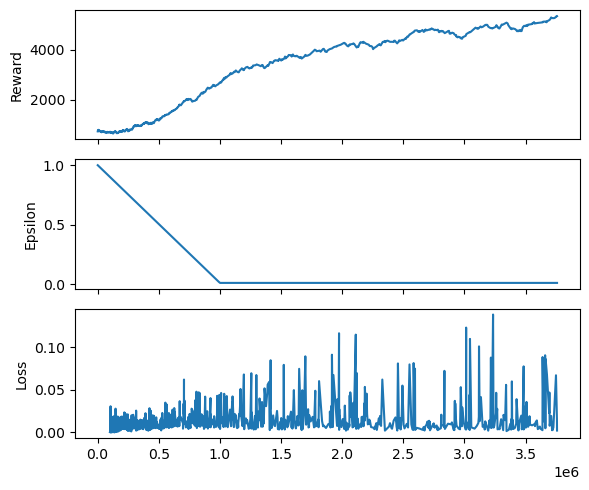

In [19]:
import pandas as pd

reward = pd.read_csv("metrics/rewards.csv")[['Step', 'Value']].values
epsilon = pd.read_csv("metrics/epsilon.csv")[['Step', 'Value']].values
loss = pd.read_csv("metrics/loss.csv")[['Step', 'Value']].values

fig, ax = plt.subplots(3, 1, figsize=(6, 5), tight_layout=True, sharex=True)
ax[0].plot(rewards[:, 0], rewards[:, 1])
ax[0].set_ylabel('Reward')
ax[1].plot(epsilon[:, 0], epsilon[:, 1])
ax[1].set_ylabel('Epsilon')
ax[2].plot(loss[:, 0], loss[:, 1])
ax[2].set_ylabel('Loss');
ax[2].set_xlabel('Epoca');

El mejor modelo se puede guardar en respaldar en disco con: 

In [22]:
model.save("dqn_breakout")

El modelo guardado se puede cargar desde disco para evaluarse o también seguir entrenándose volviendo a ejecutar `learn`

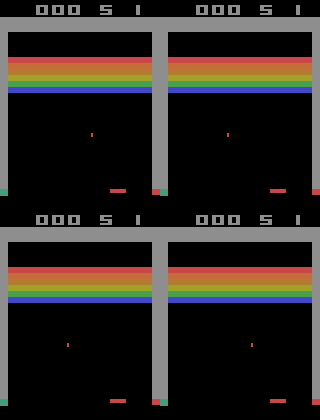

In [6]:
import numpy as np
import imageio
import IPython
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3 import DQN

env = VecFrameStack(make_atari_env(env_name, n_envs=4), n_stack=4)

loaded_model = DQN.load("dqn_breakout")

images = []

obs = env.reset()
for k in range(100):
    action, _state = loaded_model.predict(obs)
    obs, rewards, end, info = env.step(action)
    img = env.render("rgb_array")
    images.append(img)

!rm trained.gif
imageio.mimsave("trained.gif", [np.array(img) for img in images], format='GIF', duration=1)
IPython.display.Image("trained.gif")